In [ ]:
# default_exp multiscale_flow_embedder
from nbdev.showdoc import *
import numpy as np
import matplotlib.pyplot as plt
import torch
import directed_graphs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
%load_ext autoreload
%autoreload 2
device

device(type='cpu')

# 05c Multiscale Flow Embeddings with a Grid
The problem with the Diffusion Flow Embedder (05b) is that, although it minimizes the loss quite well, achieving 0 cost only requires the network to replicate the graph's *affinity* matrix within the embedding. Consequently, the embedding only preserves near neighbors; like tSNE, it willfully distorts global structure.

This manifests in, for example 05b05 and 05b05a, where we see that the spiral (and the swiss roll) are not *unrolled*, as we'd like -- but are either left coiled, as in their projections, or wrapped oddly. The affinity matrices of the embeddings are beautiful. They have no way of telling how weird the global structure is. 

As a result, the flows learnt by the method are unnecessarily complex, and tend to wrap around the manifold. The flows are only used for near neighbor connectivity, hence there is no incentive to learn anything that makes sense in long ranges.

This notebook is motivated by a suspicion that these effects can be greatly lessened with two novel additions:
1. *multiscale* diffusion probability comparisons  -- between $P_{graph}^t$ and $P_{embedding}^t$ for several values of $t$, but only in which
2. a *grid* connects points in the embedding space in a way the ambient points aren't connected.

Much of the machinery for this was already developed in 05b. We need only introduce the grid, and a multiscale loss.

I'm additionally going to try to make the class as *modular* as possible, to avoid the syndrome of doing everything within one giant code block with a class that has dozens of functions.

In [ ]:
# export
from directed_graphs.diffusion_flow_embedding import affinity_matrix_from_pointset_to_pointset, smoothness_of_vector_field
def compute_grid(X,grid_width=20):
  """ Returns a grid of points which bounds the points X. 
  The grid has 'grid_width' dots in both length and width.
  Accepts X, tensor of shape n x 2
  Returns tensor of shape grid_width^2 x 2"""
  # TODO: This currently only supports 
  # find support of points
  minx = (min(X[:,0])-1).detach()
  maxx = (max(X[:,0])+1).detach()
  miny = (min(X[:,1])-1).detach()
  maxy = (max(X[:,1])+1).detach()
  # form grid around points
  x, y = torch.meshgrid(torch.linspace(minx,maxx,steps=grid_width),torch.linspace(miny,maxy,steps=grid_width))
  xy_t = torch.concat([x[:,:,None],y[:,:,None]],dim=2).float()
  xy_t = xy_t.reshape(grid_width**2,2)
  return xy_t

A cornerstone of this method will be the powering of the diffusion matrix, which must intersperse jumping between points in the dataset and in the surrounding grid. Traditional matrix powering will do, provided we add the grid points to the dataset before powering, and then take them out afterwards.

In [ ]:
# export
from directed_graphs.diffusion_flow_embedding import affinity_matrix_from_pointset_to_pointset, GaussianVectorField
import torch.nn.functional as F
def diffusion_matrix_with_grid_points(X, grid, flow_function, t, sigma,flow_strength):
  n_points = X.shape[0]
  # combine the points and the grid
  points_and_grid = torch.concat([X,grid],dim=0)
  # get flows at each point
  flow_per_point = flow_function(points_and_grid)
  # take a diffusion matrix
  A = affinity_matrix_from_pointset_to_pointset(points_and_grid,points_and_grid, flows = flow_per_point, sigma = sigma, flow_strength=flow_strength)
  P = F.normalize(A, p=1, dim=-1)
  # TODO: Should we remove self affinities? Probably not, as lazy random walks are advantageous when powering
  # Power the matrix to t steps
  Pt = torch.matrix_power(P,t)
  # Recover the transition probabilities between the points, and renormalize them
  Pt_points = Pt[:n_points,:n_points]
  Pt_points = torch.diag(1/Pt_points.sum(1)) @ Pt_points
  # return diffusion probs between points
  return Pt_points

In [ ]:
A = torch.tensor([[1,2],[3,4],[5,6]])
B = torch.rand(5,2)
K = GaussianVectorField(2,25,device=torch.device('cpu'))
out = diffusion_matrix_with_grid_points(A,B,K,1, 0.5, 4)
out

tensor([[9.9999e-01, 9.0006e-06, 3.1444e-08],
        [2.6249e-06, 3.6853e-01, 6.3147e-01],
        [1.2139e-05, 3.4747e-03, 9.9651e-01]], grad_fn=<MmBackward0>)

## General embedding matrix
The architecture should support modular swapping of point embedding methods. A few of these include:
1. Feedforward embedder (paired with a decoder)
2. Learnable initialized points (random, or to a prior embedding initialization, like DMaps, UMAP, PHATE...)
3. Fixed initializations, if we want the flow to contort itself to the initialization
This will take the shape of swappable "embedder" classes, which can be supplied as input to the network.

For example, here is the simple FF net we use in the autoencoder:

In [ ]:
# export
import torch.nn as nn
from collections import OrderedDict
class FeedForwardReLU(nn.Module):
  def __init__(self, shape):
    super(FeedForwardReLU, self).__init__()
    d_len = len(shape)*2
    d = OrderedDict()
    d[str(0)] = nn.Linear(shape[0], shape[1])
    for i in range(1,d_len-3):
        if i%2 == 1:
            d[str(i)] = nn.LeakyReLU()
        else:
            d[str(i)] = nn.Linear(shape[int(i/2)], shape[int(i/2)+1])
    # create MLP
    self.FA = nn.Sequential(d)
  def forward(self, X):
    return self.FA(X)

In [ ]:
fa = FeedForwardReLU(shape=[2,3,4,5,6,5,4,3,2])
fa

FeedForwardReLU(
  (FA): Sequential(
    (0): Linear(in_features=2, out_features=3, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=3, out_features=4, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=4, out_features=5, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=5, out_features=6, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Linear(in_features=6, out_features=5, bias=True)
    (9): LeakyReLU(negative_slope=0.01)
    (10): Linear(in_features=5, out_features=4, bias=True)
    (11): LeakyReLU(negative_slope=0.01)
    (12): Linear(in_features=4, out_features=3, bias=True)
    (13): LeakyReLU(negative_slope=0.01)
    (14): Linear(in_features=3, out_features=2, bias=True)
  )
)

In [ ]:
# export
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import trange
import numpy as np
import matplotlib.pyplot as plt
from directed_graphs.diffusion_flow_embedding import GaussianVectorField, smoothness_of_vector_field, FlowArtist

class MultiscaleDiffusionFlowEmbedder(torch.nn.Module):
	def __init__(self, 
							X, 
							flows, 
							ts = [1,2,4,8], 
							sigma_graph = 0.5, 
							sigma_embedding=0.5, 
							flow_strength_graph=5, 
							flow_strength_embedding=5, 
							embedding_dimension=2, 
							learning_rate = 1e-3,
							flow_artist = "ReLU",
							flow_artist_shape = [2,4,8,4,2],
							num_flow_gaussians = 25,
							embedder = FeedForwardReLU(shape=[3,4,8,4,2]),
							decoder = FeedForwardReLU(shape=[2,4,8,4,3]),
							labels = None,   
							loss_weights = {
								"diffusion":1,
								"smoothness":0,
								"reconstruction":0,
							},
							device=torch.device('cpu'),
							):
		# initialize parameters
		super(MultiscaleDiffusionFlowEmbedder, self).__init__()
		self.X = X
		self.ground_truth_flows = flows
		self.ts = ts
		self.sigma_embedding = sigma_embedding
		self.sigma_graph = sigma_graph
		self.nnodes = X.shape[0]
		self.data_dimension = X.shape[1]
		
		self.eps = 0.001
		self.loss_weights = loss_weights
		self.labels = labels
		self.flow_strength = nn.Parameter(torch.tensor(flow_strength_embedding).float())
		self.embedding_dimension = embedding_dimension
		# set device (used for shuffling points around during visualization)
		self.device = device
		# Used for 
		self.losses = {}
		for k in self.loss_weights.keys():
			self.losses[k] = []
		
		self.P_graph = affinity_matrix_from_pointset_to_pointset(X,X,flows,sigma=sigma_graph,flow_strength=flow_strength_graph)
		self.P_graph = torch.diag(1/self.P_graph.sum(axis=1)) @ self.P_graph
		# compute matrix powers 
		# TODO: Could reuse previous powers to speed this up
		self.P_graph_ts = [torch.matrix_power(self.P_graph,t) for t in self.ts]
		self.P_embedding_ts = [None for i in self.ts]
		# Flow field
		self.FlowArtist = FlowArtist(flow_artist, dim=self.embedding_dimension, num_gauss = num_flow_gaussians, shape = flow_artist_shape, device = self.device).to(self.device)

		# Autoencoder to embed the points into a low dimension
		self.embedder = embedder.to(self.device)
		if decoder is not None:
			self.decoder = decoder.to(self.device)
		else:
			self.decoder = None

		# training ops
		self.KLD = nn.KLDivLoss(reduction='batchmean',log_target=False)
		self.MSE = nn.MSELoss()
		self.epsilon = 1e-6 # set zeros to eps
		self.optim = torch.optim.Adam(self.parameters(), lr = learning_rate)
									
	def diffusion_loss(self):
		# compute grid around points
		self.grid = compute_grid(self.embedded_points).to(self.device)
		# normalize embedded points to lie within -self.embedding_bounds, self.embedding_bounds
		# if any are trying to escape, constrain them to lie on the edges
		# self.embedded_points[:,0][torch.abs(self.embedded_points[:,0]) > self.embedding_bounds] = self.embedding_bounds * (self.embedded_points[:,0][torch.abs(self.embedded_points[:,0]) > self.embedding_bounds])/torch.abs(self.embedded_points[:,0][torch.abs(self.embedded_points[:,0]) > self.embedding_bounds])
		# self.embedded_points[:,1][torch.abs(self.embedded_points[:,1]) > self.embedding_bounds] = self.embedding_bounds * (self.embedded_points[:,1][torch.abs(self.embedded_points[:,1]) > self.embedding_bounds])/torch.abs(self.embedded_points[:,0][torch.abs(self.embedded_points[:,1]) > self.embedding_bounds])
		# compute embedding diffusion matrix, using including diffusion to grid points
		for i,t in enumerate(self.ts):
			self.P_embedding_ts[i] = diffusion_matrix_with_grid_points(X = self.embedded_points, grid=self.grid, flow_function = self.FlowArtist, t = t, sigma = self.sigma_embedding, flow_strength=self.flow_strength)
			# set any affinities of zero to a very small amount, to prevent the KL divergence from becoming infinite.
			self.P_embedding_ts[i][self.P_embedding_ts[i] == 0] = self.epsilon
		# take KL divergence between P embedding ts and P graph ts
		diffusion_loss = 0
		for i in range(len(self.ts)):
			log_P_embedding_t = torch.log(self.P_embedding_ts[i])
			if log_P_embedding_t.is_sparse:
				diffusion_loss_for_t = self.KLD(log_P_embedding_t.to_dense(),self.P_graph_ts[i].to_dense())
			else:
				diffusion_loss_for_t = self.KLD(log_P_embedding_t,self.P_graph_ts[i])
			diffusion_loss += (2**(-i))*diffusion_loss_for_t
		self.losses['diffusion'].append(diffusion_loss.detach().cpu().float())
		return diffusion_loss

	def loss(self):
		# embed points
		self.embedded_points = self.embedder(self.X)
		# compute diffusion loss on embedded points
		diffusion_loss = self.diffusion_loss()
		# compute autoencoder loss
		if self.decoder is not None:
			X_reconstructed = self.decoder(self.embedded_points)
			reconstruction_loss = self.MSE(X_reconstructed, self.X)
			self.losses['reconstruction'].append(reconstruction_loss.detach().cpu().float())
		else:
			reconstruction_loss = 0
		# regularizations
		if self.loss_weights['smoothness'] != 0:
			smoothness_loss = smoothness_of_vector_field(self.embedded_points,self.FlowArtist,device=self.device,grid_width=20)
			self.losses['smoothness'].append(smoothness_loss.detach().cpu().float())
		else:
			smoothness_loss = 0

		cost = (self.loss_weights['diffusion']*diffusion_loss 
		+ self.loss_weights['reconstruction']*reconstruction_loss 
		+ self.loss_weights['smoothness']*smoothness_loss
		)
		return cost

	def visualize_points(self, labels = None):
		# controls the x and y axes of the plot
		# linspace(min on axis, max on axis, spacing on plot -- large number = more field arrows)
		if labels is None:
			labels = self.labels
		uv = self.FlowArtist(self.grid).detach().cpu()
		u = uv[:,0].cpu()
		v = uv[:,1].cpu()
		x = self.grid.detach().cpu()[:,0]
		y = self.grid.detach().cpu()[:,1]
		# quiver 
		# 	plots a 2D field of arrows
		# 	quiver([X, Y], U, V, [C], **kw); 
		# 	X, Y define the arrow locations, U, V define the arrow directions, and C optionally sets the color.
		if labels is not None:
			sc = plt.scatter(self.embedded_points[:,0].detach().cpu(),self.embedded_points[:,1].detach().cpu(), c=labels)
			plt.legend()
		else:
			sc = plt.scatter(self.embedded_points[:,0].detach().cpu(),self.embedded_points[:,1].detach().cpu())
		plt.suptitle("Flow Embedding")
		plt.quiver(x,y,u,v)
		# Display all open figures.
		plt.show()
		
	def visualize_diffusion_matrices(self):
		fig, axs = plt.subplots(3,2, figsize=(10,15))
		axs[0][0].set_title(f"Ambient $P^{self.ts[0]}$")
		axs[0][0].imshow(self.P_graph_ts[0].detach().cpu().numpy())
		axs[0][1].set_title(f"Embedding $P^{self.ts[0]}$")
		axs[0][1].imshow(self.P_embedding_ts[0].detach().cpu().numpy())
		
		axs[1][0].set_title(f"Ambient $P^{self.ts[1]}$")
		axs[1][0].imshow(self.P_graph_ts[1].detach().cpu().numpy())
		axs[1][1].set_title(f"Embedding $P^{self.ts[1]}$")
		axs[1][1].imshow(self.P_embedding_ts[1].detach().cpu().numpy())

		axs[2][0].set_title(f"Ambient $P^{self.ts[2]}$")
		axs[2][0].imshow(self.P_graph_ts[2].detach().cpu().numpy())
		axs[2][1].set_title(f"Embedding $P^{self.ts[2]}$")
		axs[2][1].imshow(self.P_embedding_ts[2].detach().cpu().numpy())

		plt.show()

	def fit(self,n_steps = 1000):
		# train Flow Embedder on the provided graph
		self.train()
		# self.weight_of_flow = 0
		for step in trange(n_steps):
			# if step == 100:
			# 	self.weight_of_flow = 1
			# if step == 200:
			# 	self.weight_of_flow = 0.5
			self.optim.zero_grad()
			# compute loss
			loss = self.loss()
			# print("loss is ",loss)
			# compute gradient and step backwards
			loss.backward()
			self.optim.step()
			if step % 100 == 0:
				print(f"EPOCH {step}. Loss {loss}. Flow strength {self.flow_strength}. Heatmap of P embedding is ")
				self.visualize_diffusion_matrices()
				self.visualize_points()
			# TODO: Criteria to automatically end training
		print("Exiting training with loss ",loss)
		return self.embedded_points

# Basic Tests/Sanity Checks
More comprehensive explorations will be in the notebooks under 05c. For now, we ensure the network *works*.

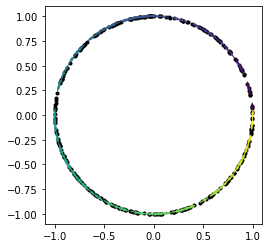

In [ ]:
from directed_graphs.datasets import directed_circle, directed_cylinder, directed_spiral, directed_swiss_roll, directed_spiral_uniform, directed_swiss_roll_uniform
from directed_graphs.datasets import plot_directed_2d, plot_directed_3d
from directed_graphs.diffusion_flow_embedding import DiffusionFlowEmbedder
import torch
import numpy as np
X, flow, labels = directed_circle(num_nodes=300, radius=1)
plot_directed_2d(X, flow, labels)
X = torch.tensor(X).float().to(device)
flow = torch.tensor(flow).float().to(device)

In [ ]:
MFE = MultiscaleDiffusionFlowEmbedder(X, flow, device=device).to(device)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0. Loss 4.5993757247924805. Flow strength 4.999000072479248. Heatmap of P embedding is 


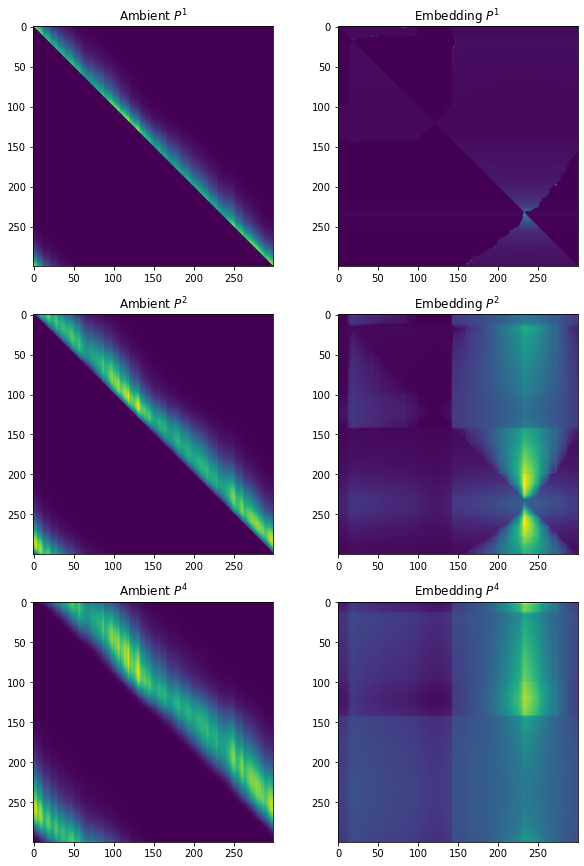

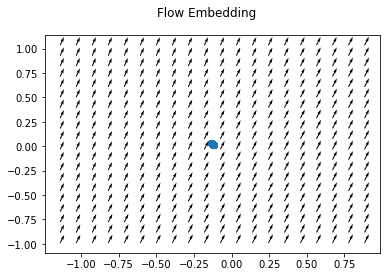

100%|██████████| 10/10 [00:07<00:00,  1.35it/s]

Exiting training with loss  tensor(4.3576, grad_fn=<AddBackward0>)


tensor([[-0.1252,  0.0429],
        [-0.1250,  0.0427],
        [-0.1244,  0.0421],
        [-0.1242,  0.0418],
        [-0.1242,  0.0418],
        [-0.1242,  0.0419],
        [-0.1242,  0.0419],
        [-0.1242,  0.0419],
        [-0.1242,  0.0419],
        [-0.1242,  0.0419],
        [-0.1242,  0.0419],
        [-0.1243,  0.0420],
        [-0.1244,  0.0422],
        [-0.1244,  0.0423],
        [-0.1245,  0.0424],
        [-0.1245,  0.0424],
        [-0.1245,  0.0424],
        [-0.1245,  0.0424],
        [-0.1246,  0.0425],
        [-0.1246,  0.0425],
        [-0.1247,  0.0426],
        [-0.1246,  0.0426],
        [-0.1246,  0.0426],
        [-0.1246,  0.0426],
        [-0.1246,  0.0426],
        [-0.1246,  0.0425],
        [-0.1246,  0.0425],
        [-0.1246,  0.0425],
        [-0.1246,  0.0425],
        [-0.1246,  0.0425],
        [-0.1246,  0.0425],
        [-0.1245,  0.0425],
        [-0.1245,  0.0425],
        [-0.1245,  0.0425],
        [-0.1245,  0.0425],
        [-0.1245,  0

In [ ]:
MFE.fit(n_steps=10)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


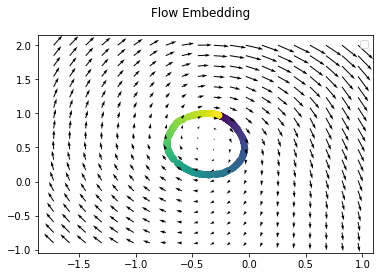

In [ ]:
MFE.visualize_points(labels=labels)

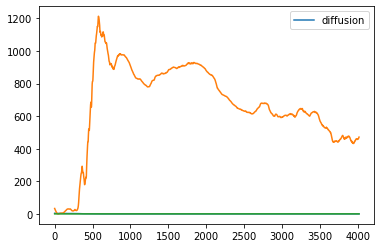

In [ ]:
plt.plot(MFE.losses["diffusion"], label = "diffusion")
plt.plot(MFE.losses["smoothness"], label = 'smoothness')
plt.plot(MFE.losses["reconstruction"])
plt.legend()

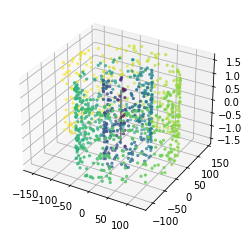

In [ ]:
X, flow, labels = directed_swiss_roll_uniform(num_nodes=1000, num_spirals=2.5, radius=10, height=3, xtilt=0, ytilt=0)
plot_directed_3d(X, flow, labels, mask_prob=0.5)

In [ ]:
X = torch.tensor(X)
flow = torch.tensor(flow)
X = X.float().to(device)
flow = flow.float().to(device)

In [ ]:
MFE = MultiscaleDiffusionFlowEmbedder(X, flow, device=device).to(device)


  0%|          | 0/10000 [00:00<?, ?it/s]

EPOCH 0. Loss 10.014656066894531. Flow strength 4.999000072479248. Heatmap of P embedding is 


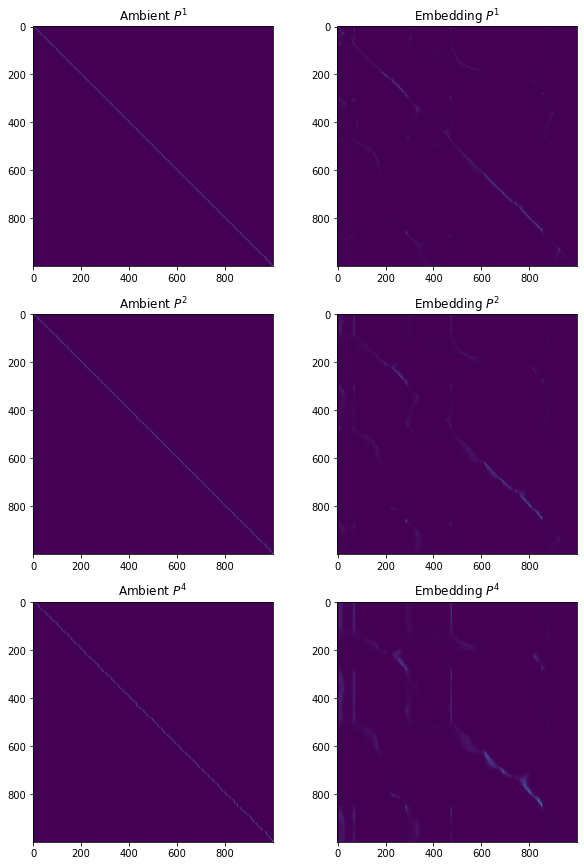

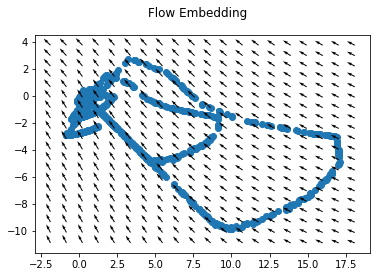

  1%|          | 100/10000 [00:19<29:10,  5.66it/s]

EPOCH 100. Loss 5.579775810241699. Flow strength 4.94921875. Heatmap of P embedding is 


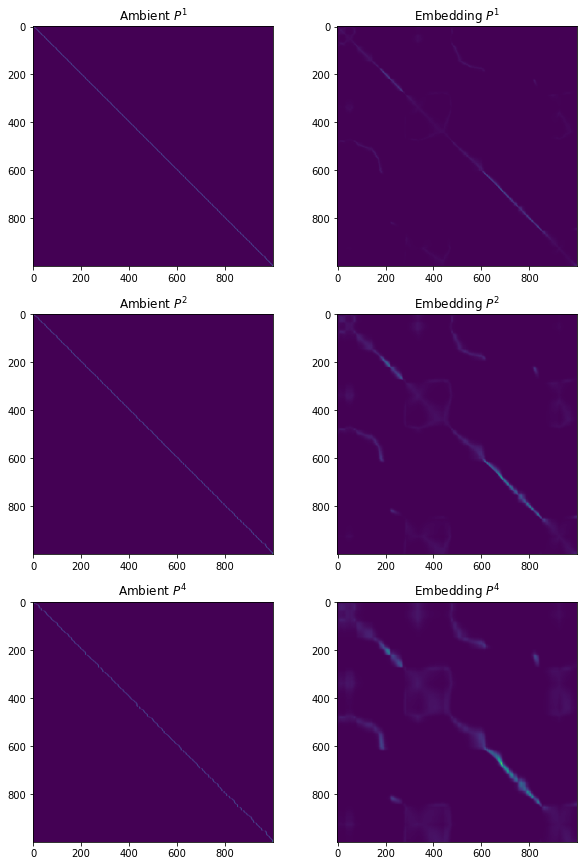

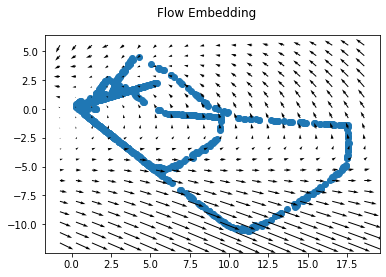

  2%|▏         | 200/10000 [00:38<28:49,  5.67it/s]  

EPOCH 200. Loss 4.965915203094482. Flow strength 4.94945764541626. Heatmap of P embedding is 


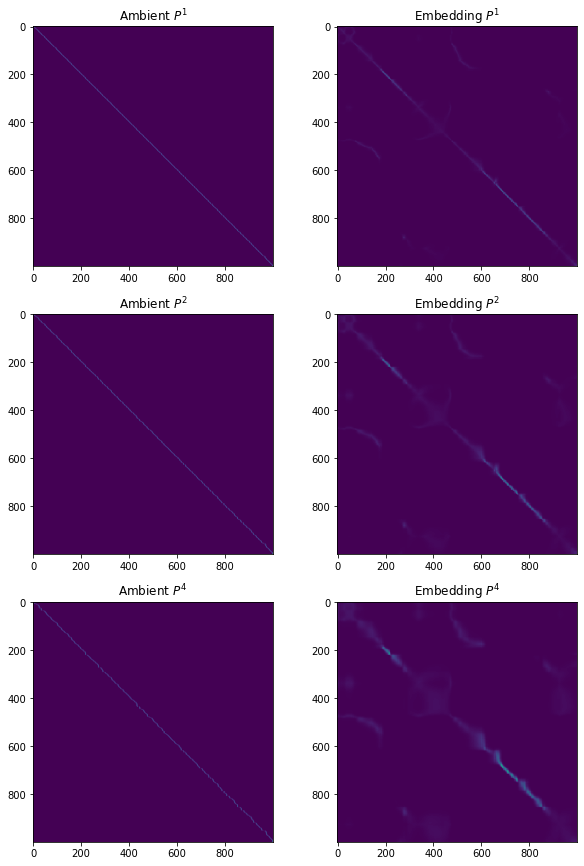

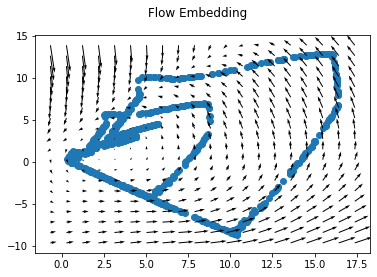

  3%|▎         | 300/10000 [00:57<29:02,  5.57it/s]  

EPOCH 300. Loss 4.561107158660889. Flow strength 4.9527740478515625. Heatmap of P embedding is 


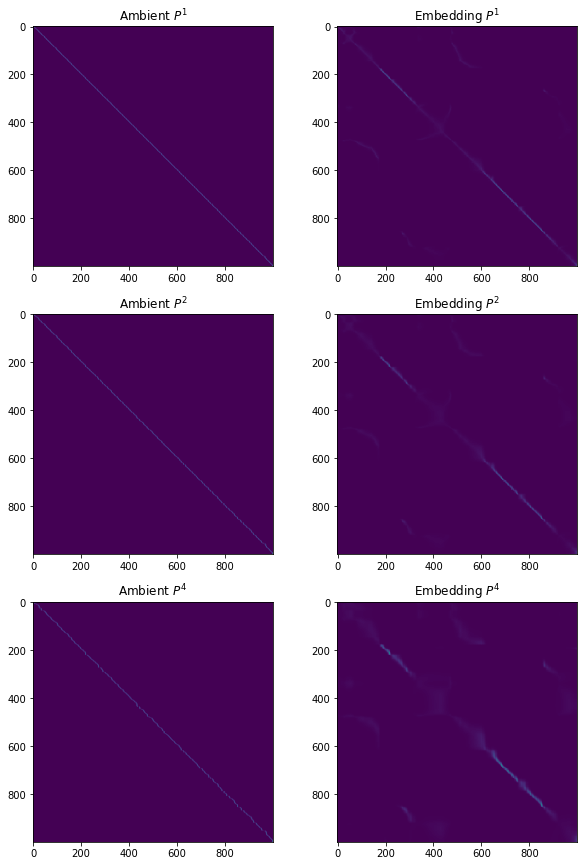

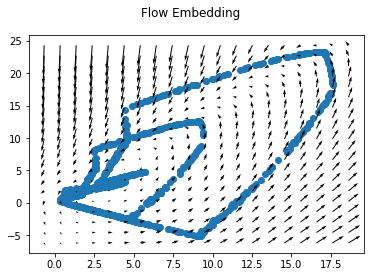

  4%|▍         | 400/10000 [01:15<27:56,  5.73it/s]  

EPOCH 400. Loss 4.64077615737915. Flow strength 4.954347133636475. Heatmap of P embedding is 


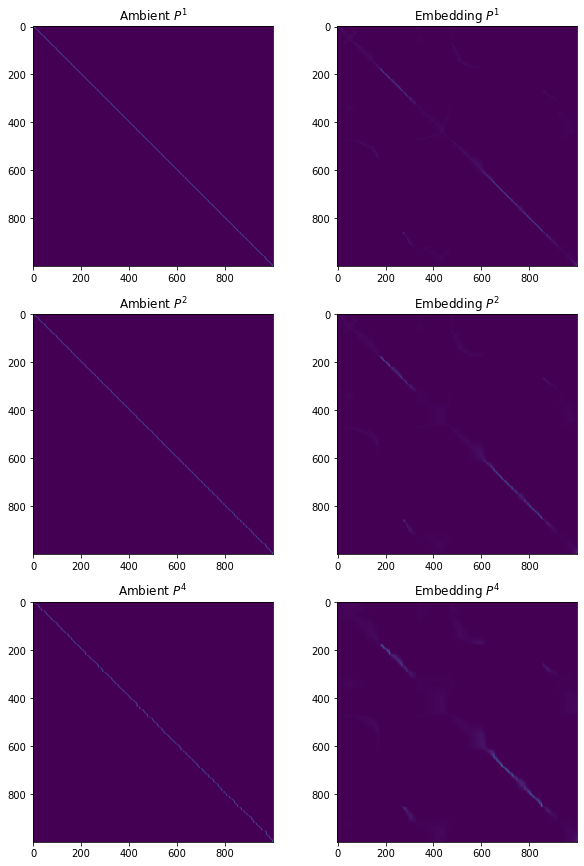

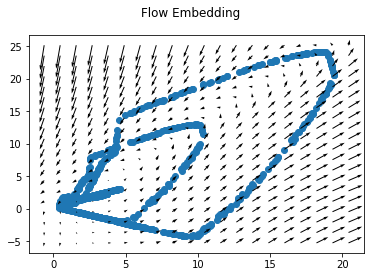

  5%|▌         | 500/10000 [01:34<27:26,  5.77it/s]  

EPOCH 500. Loss 4.0742878913879395. Flow strength 4.956845283508301. Heatmap of P embedding is 


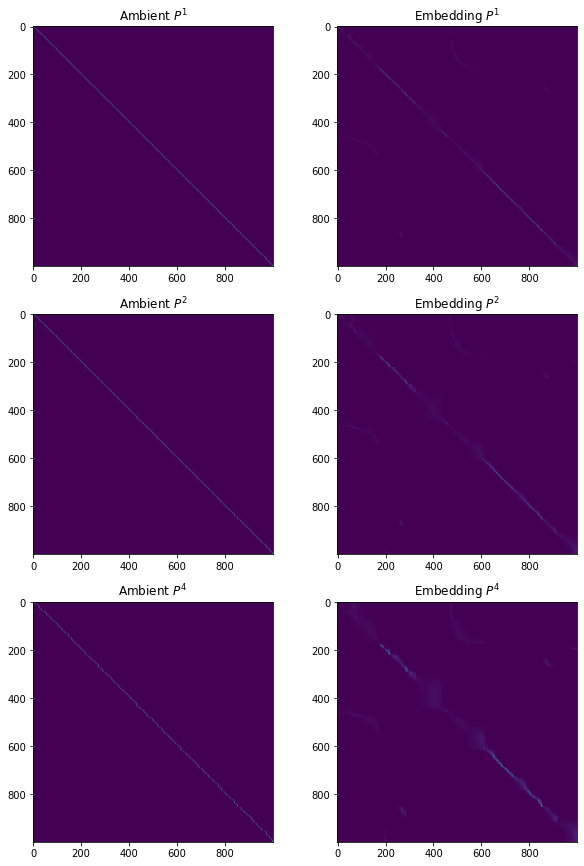

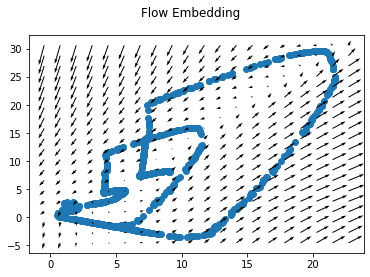

  6%|▌         | 600/10000 [01:53<27:24,  5.72it/s]  

EPOCH 600. Loss 3.679619550704956. Flow strength 4.959902286529541. Heatmap of P embedding is 


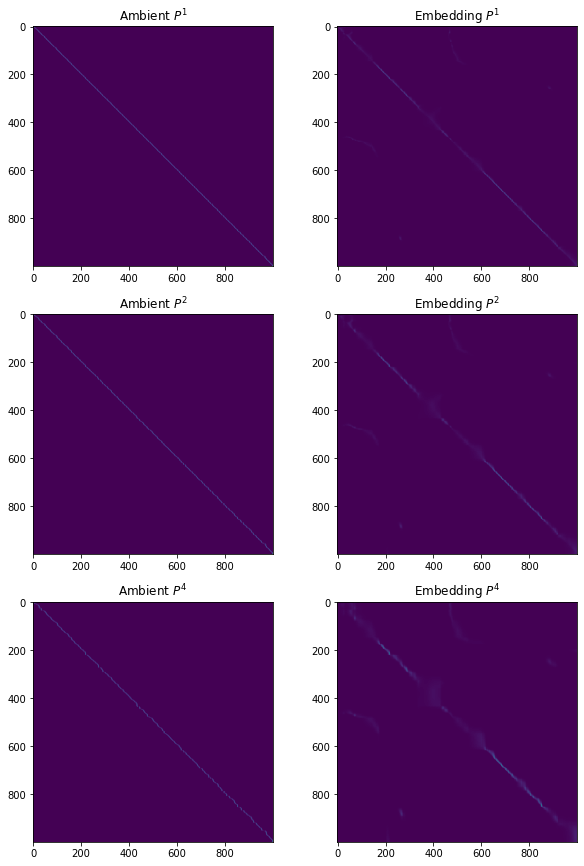

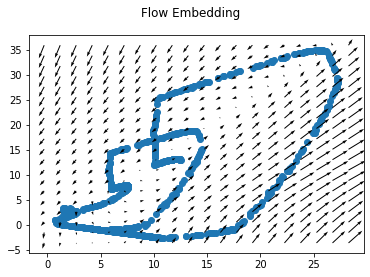

  7%|▋         | 700/10000 [02:12<27:25,  5.65it/s]  

EPOCH 700. Loss 3.6257710456848145. Flow strength 4.961740970611572. Heatmap of P embedding is 


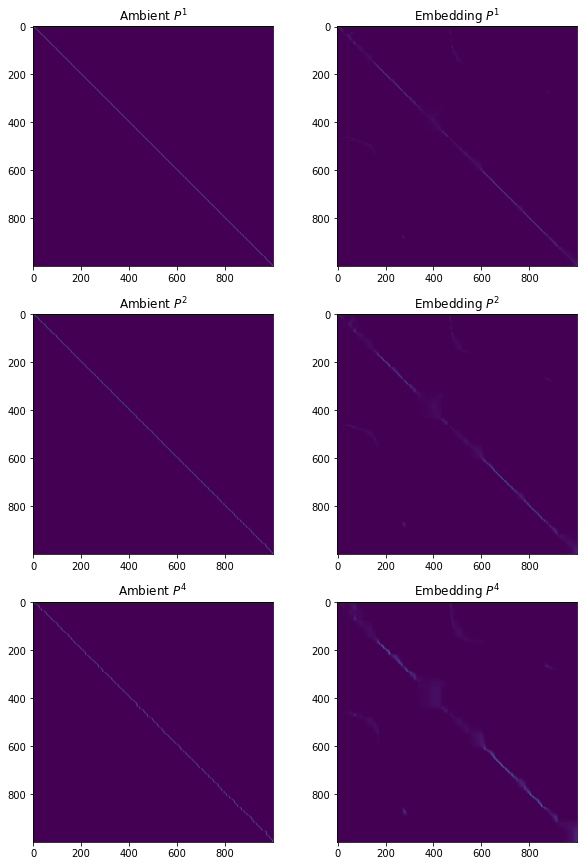

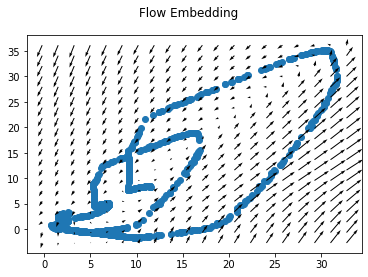

  8%|▊         | 800/10000 [02:31<27:06,  5.66it/s]  

EPOCH 800. Loss 3.60038685798645. Flow strength 4.965167999267578. Heatmap of P embedding is 


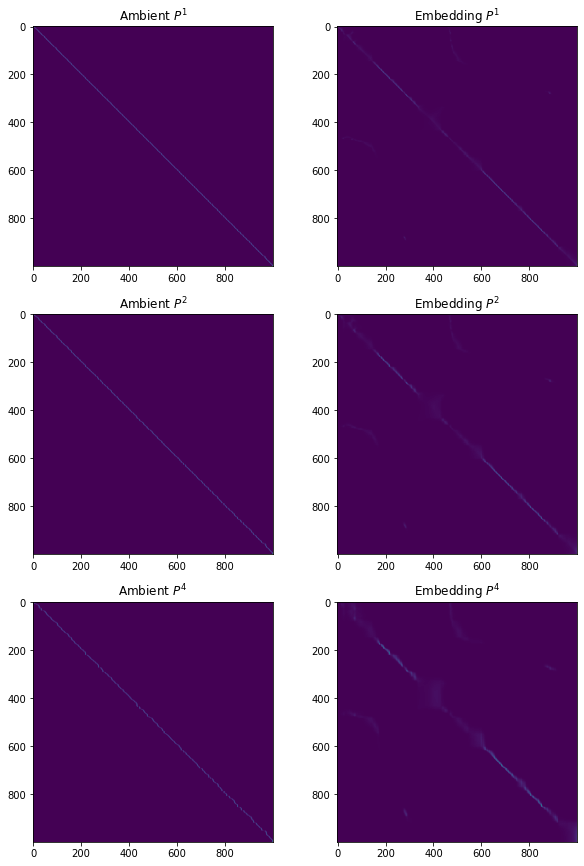

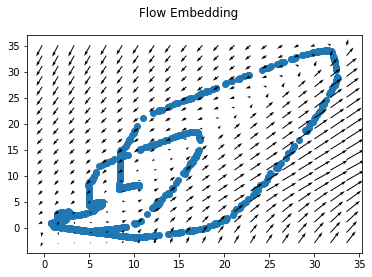

  9%|▉         | 900/10000 [02:50<26:47,  5.66it/s]  

EPOCH 900. Loss nan. Flow strength nan. Heatmap of P embedding is 


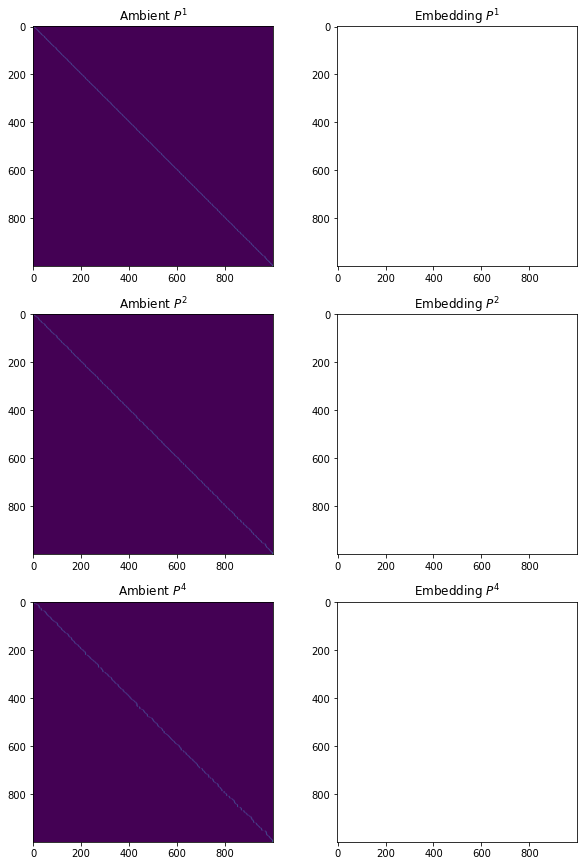

/gpfs/loomis/project/krishnaswamy_smita/kjm76/conda_envs/flowembed/lib/python3.9/site-packages/matplotlib/quiver.py:633: RuntimeWarning: Mean of empty slice.
  amean = a[~self.Umask].mean()
/gpfs/loomis/project/krishnaswamy_smita/kjm76/conda_envs/flowembed/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


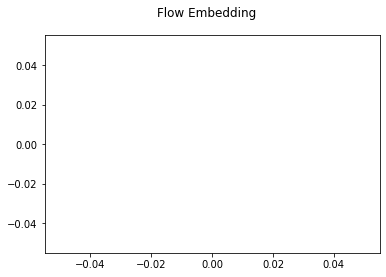

 10%|█         | 1000/10000 [03:09<26:49,  5.59it/s] 

EPOCH 1000. Loss nan. Flow strength nan. Heatmap of P embedding is 


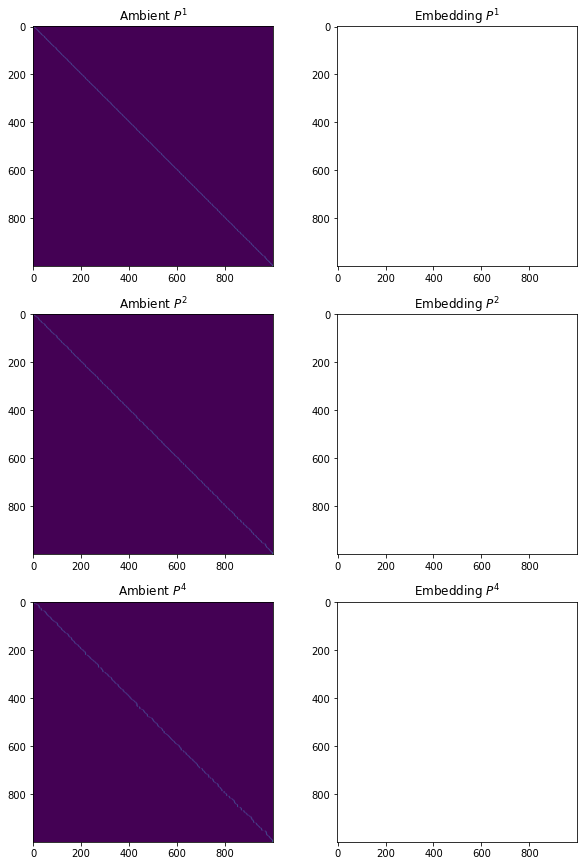

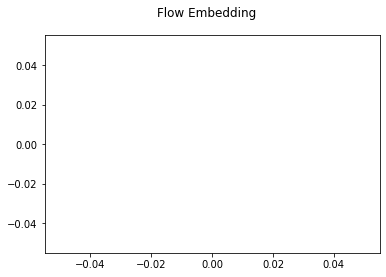

 11%|█         | 1100/10000 [03:28<26:22,  5.62it/s]  

EPOCH 1100. Loss nan. Flow strength nan. Heatmap of P embedding is 


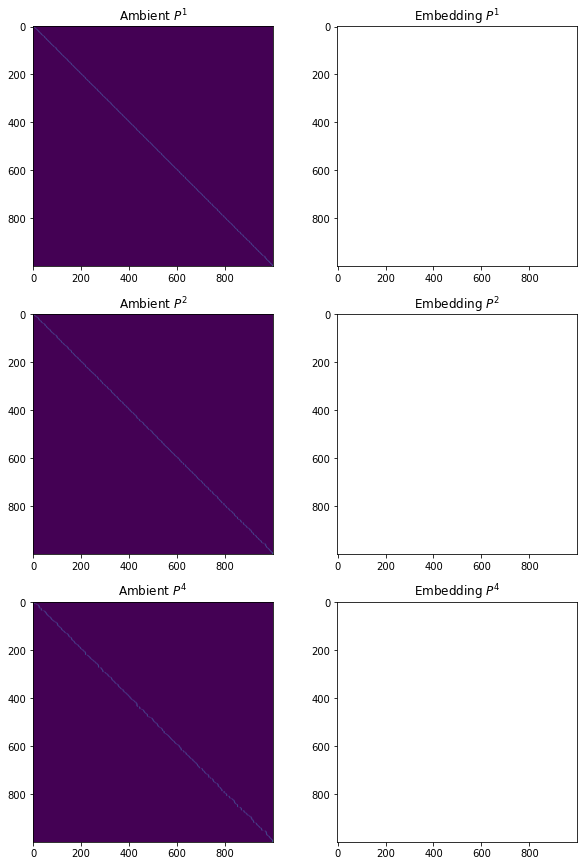

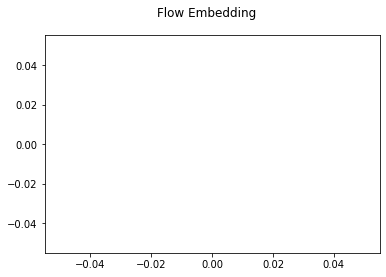

 12%|█▏        | 1200/10000 [03:47<25:46,  5.69it/s]  

EPOCH 1200. Loss nan. Flow strength nan. Heatmap of P embedding is 


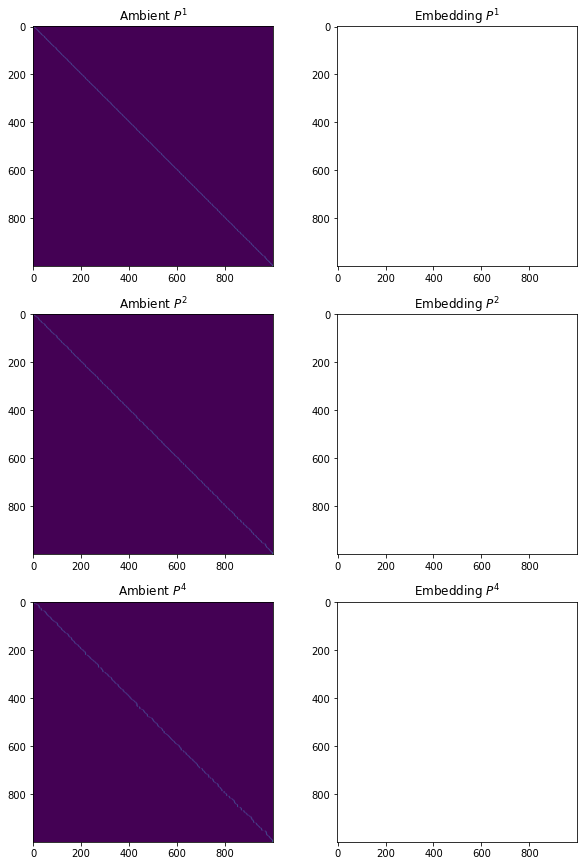

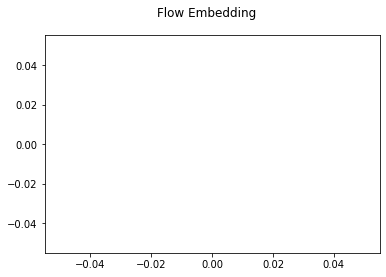

 13%|█▎        | 1300/10000 [04:06<25:41,  5.64it/s]  

EPOCH 1300. Loss nan. Flow strength nan. Heatmap of P embedding is 


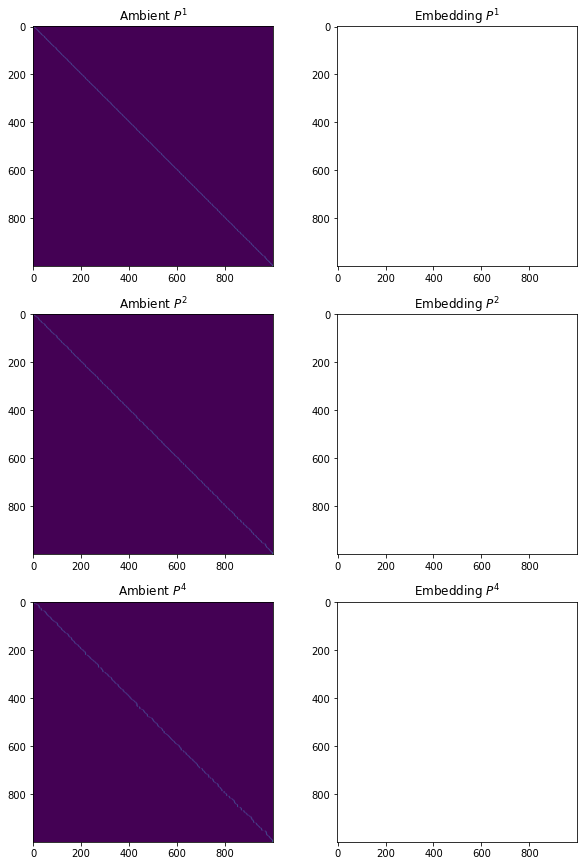

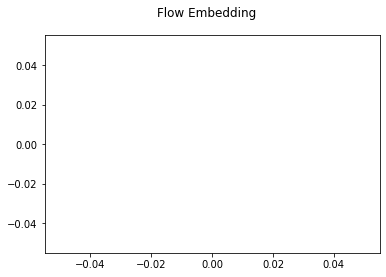

 14%|█▍        | 1400/10000 [04:25<25:36,  5.60it/s]  

EPOCH 1400. Loss nan. Flow strength nan. Heatmap of P embedding is 


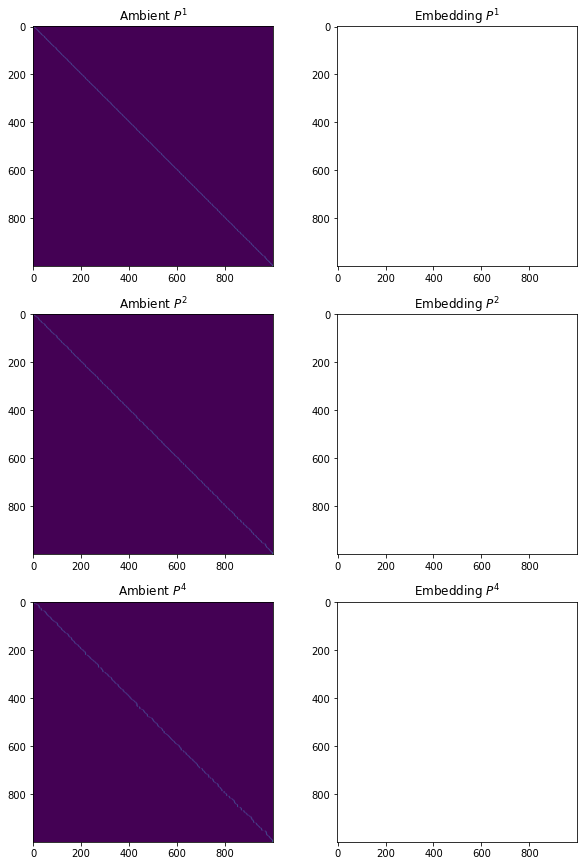

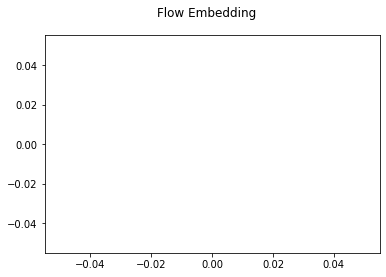

 15%|█▌        | 1500/10000 [04:45<25:17,  5.60it/s]  

EPOCH 1500. Loss nan. Flow strength nan. Heatmap of P embedding is 


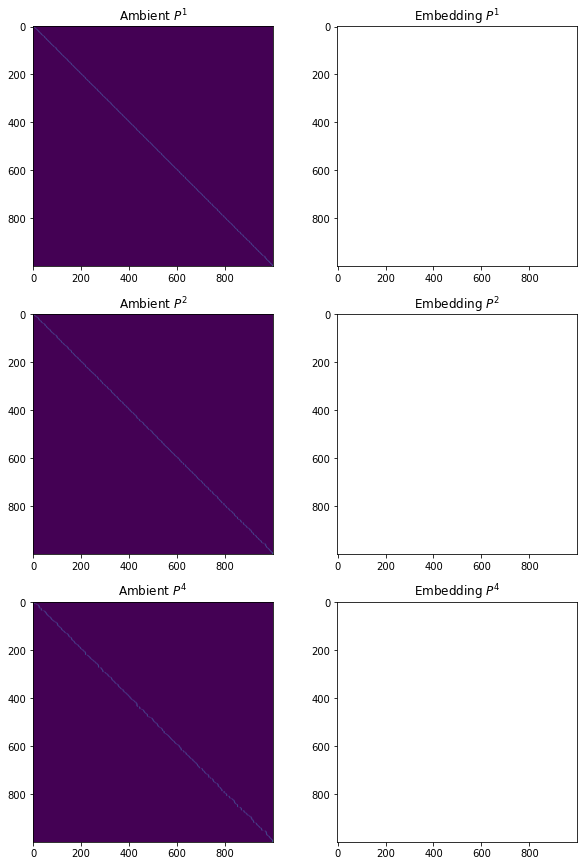

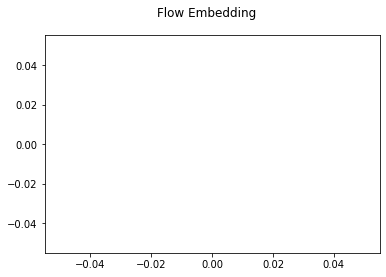

 16%|█▌        | 1600/10000 [05:03<24:10,  5.79it/s]  

EPOCH 1600. Loss nan. Flow strength nan. Heatmap of P embedding is 


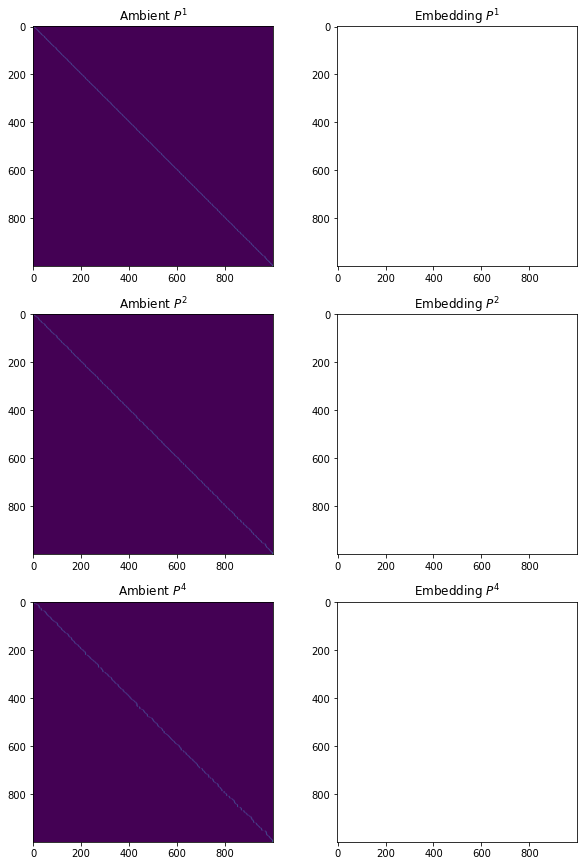

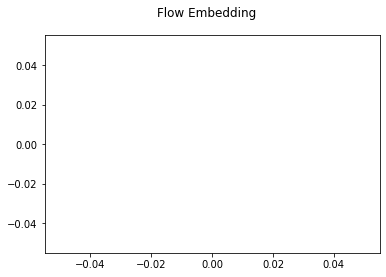

 17%|█▋        | 1700/10000 [05:22<23:59,  5.76it/s]  

EPOCH 1700. Loss nan. Flow strength nan. Heatmap of P embedding is 


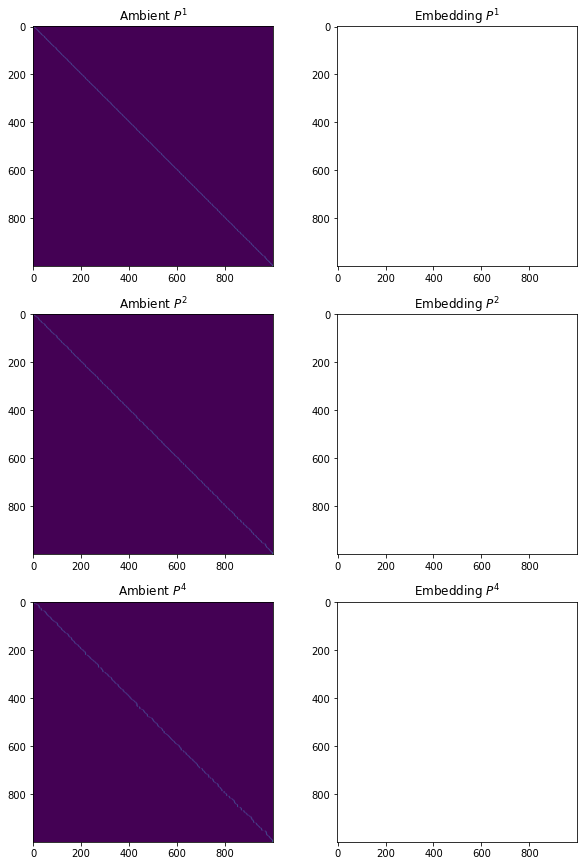

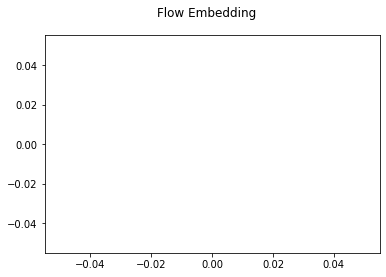

 18%|█▊        | 1800/10000 [05:40<23:48,  5.74it/s]  

EPOCH 1800. Loss nan. Flow strength nan. Heatmap of P embedding is 


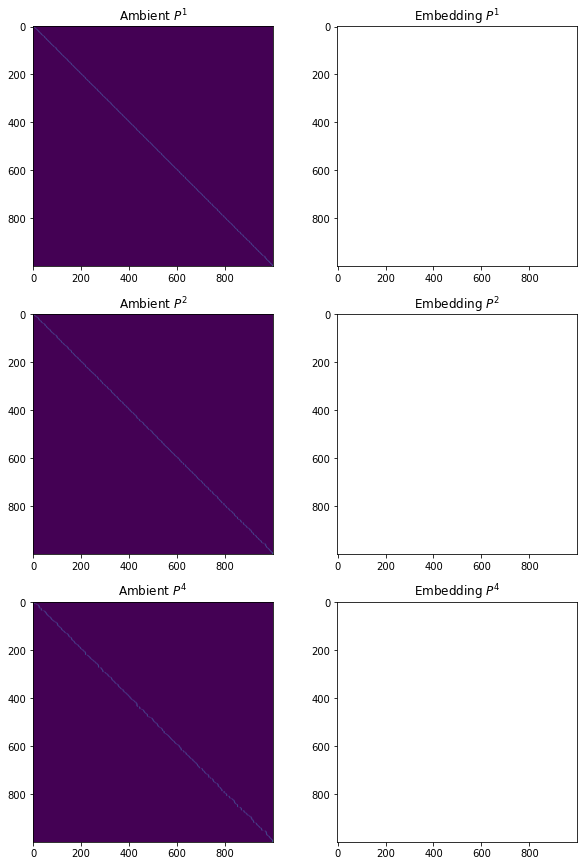

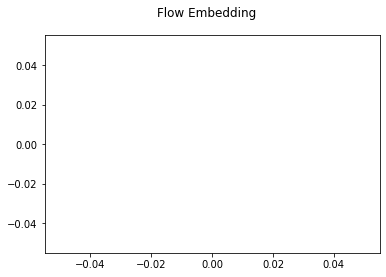

 19%|█▉        | 1900/10000 [05:59<23:31,  5.74it/s]  

EPOCH 1900. Loss nan. Flow strength nan. Heatmap of P embedding is 


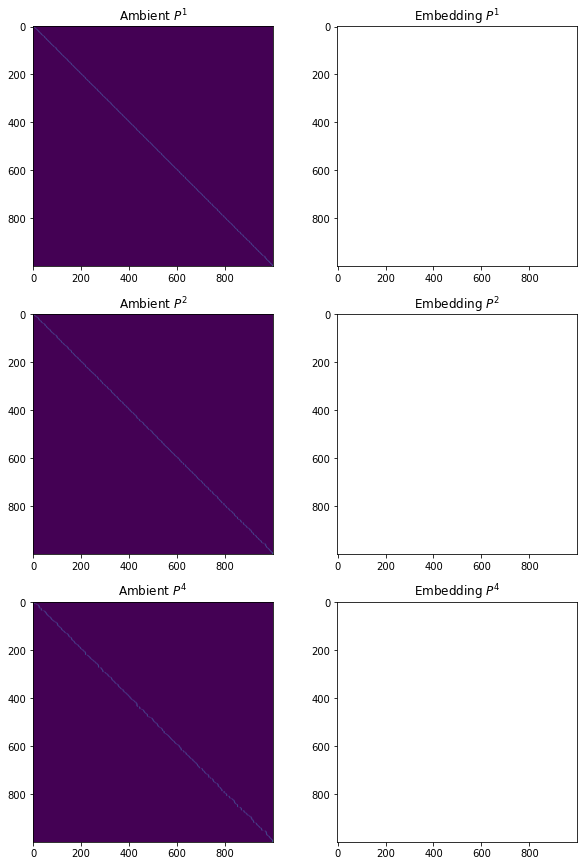

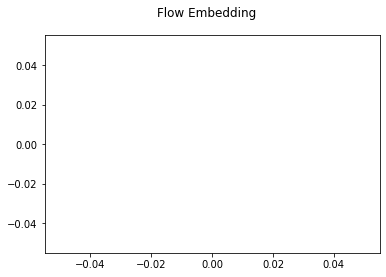

 20%|██        | 2000/10000 [06:18<23:07,  5.77it/s]  

EPOCH 2000. Loss nan. Flow strength nan. Heatmap of P embedding is 


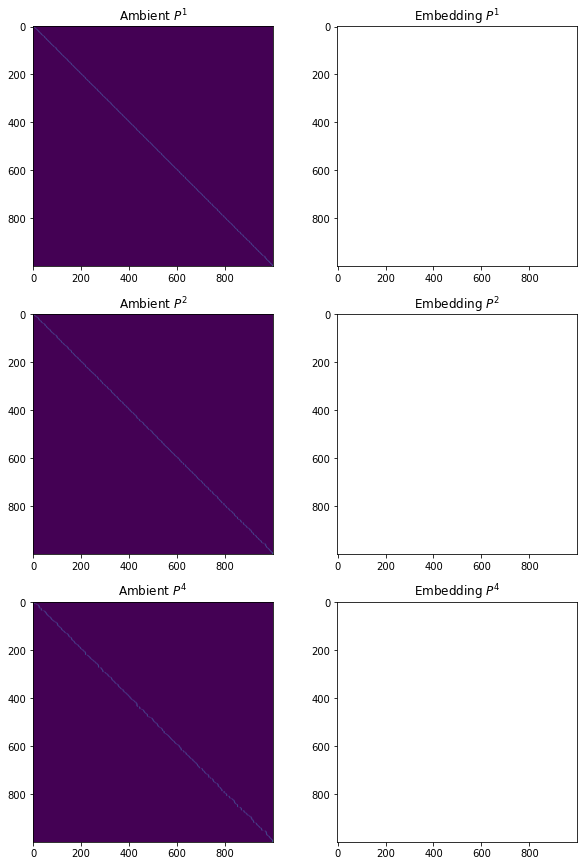

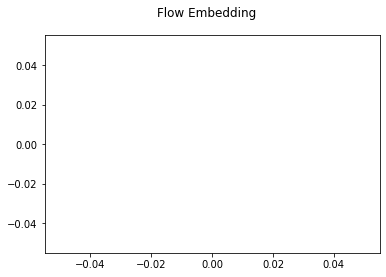

 21%|██        | 2100/10000 [06:37<22:52,  5.76it/s]  

EPOCH 2100. Loss nan. Flow strength nan. Heatmap of P embedding is 


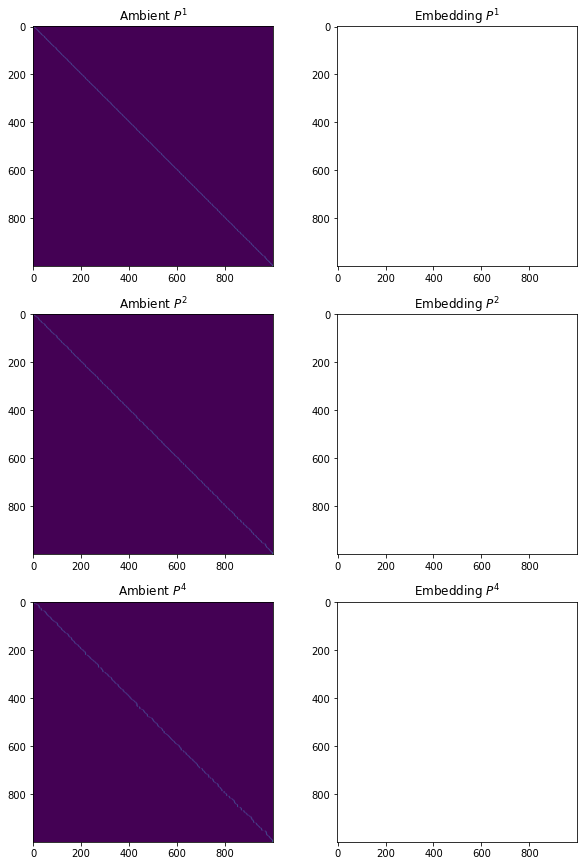

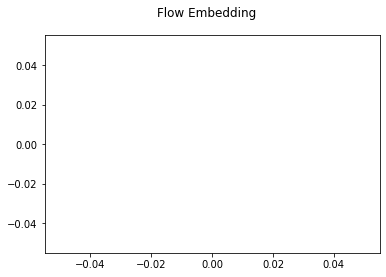

 22%|██▏       | 2200/10000 [06:55<22:27,  5.79it/s]  

EPOCH 2200. Loss nan. Flow strength nan. Heatmap of P embedding is 


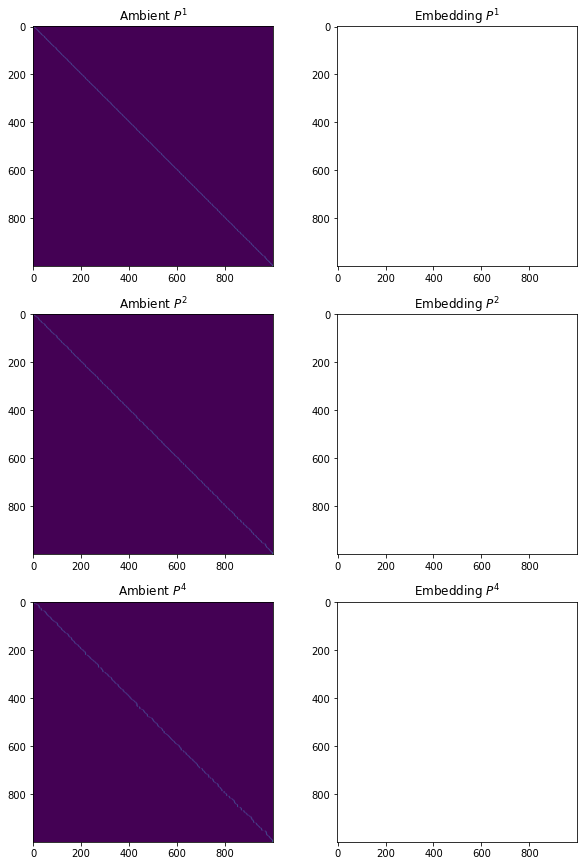

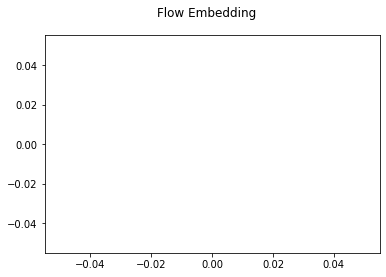

 23%|██▎       | 2300/10000 [07:14<22:13,  5.77it/s]  

EPOCH 2300. Loss nan. Flow strength nan. Heatmap of P embedding is 


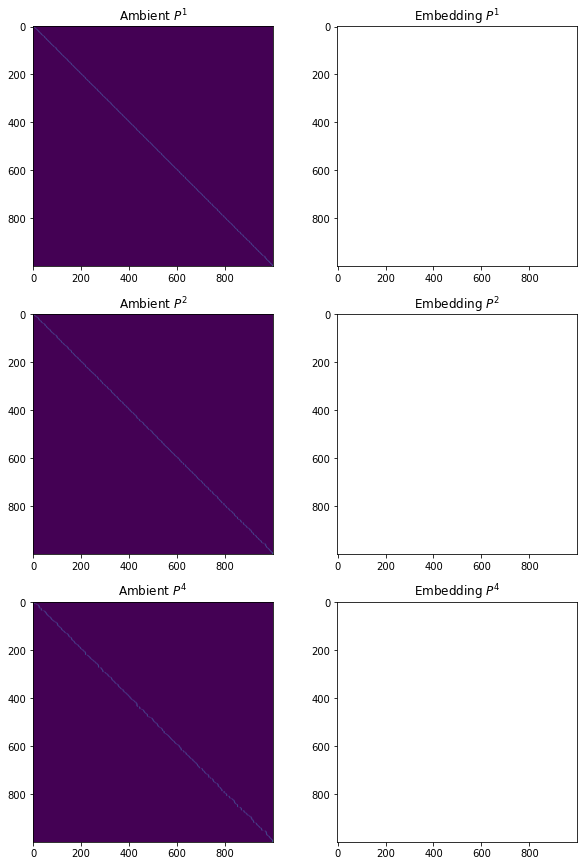

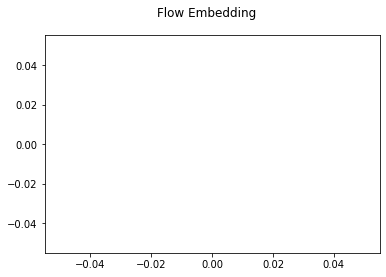

 24%|██▍       | 2400/10000 [07:32<22:04,  5.74it/s]  

EPOCH 2400. Loss nan. Flow strength nan. Heatmap of P embedding is 


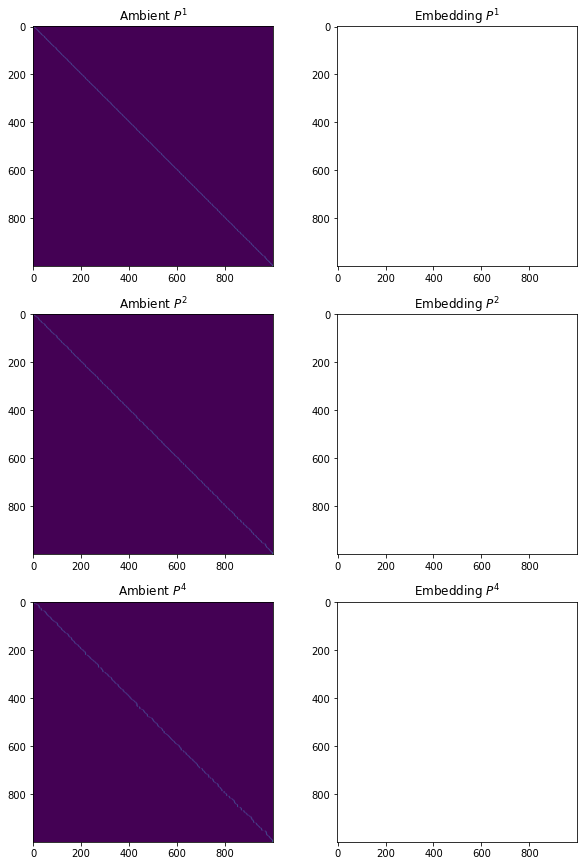

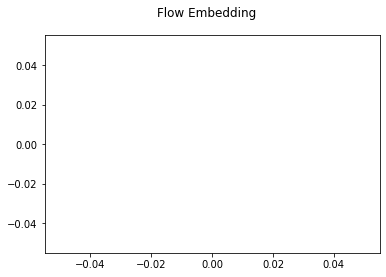

 25%|██▌       | 2500/10000 [07:51<21:48,  5.73it/s]  

EPOCH 2500. Loss nan. Flow strength nan. Heatmap of P embedding is 


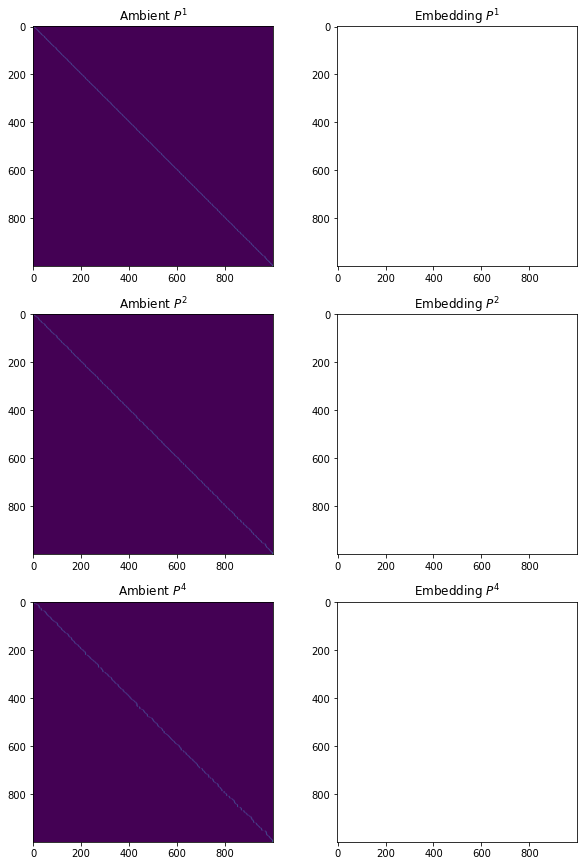

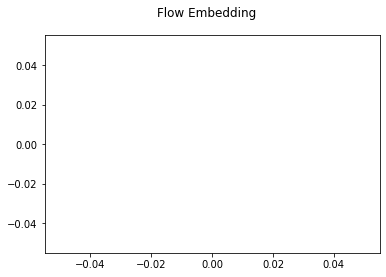

 26%|██▌       | 2600/10000 [08:10<21:25,  5.76it/s]  

EPOCH 2600. Loss nan. Flow strength nan. Heatmap of P embedding is 


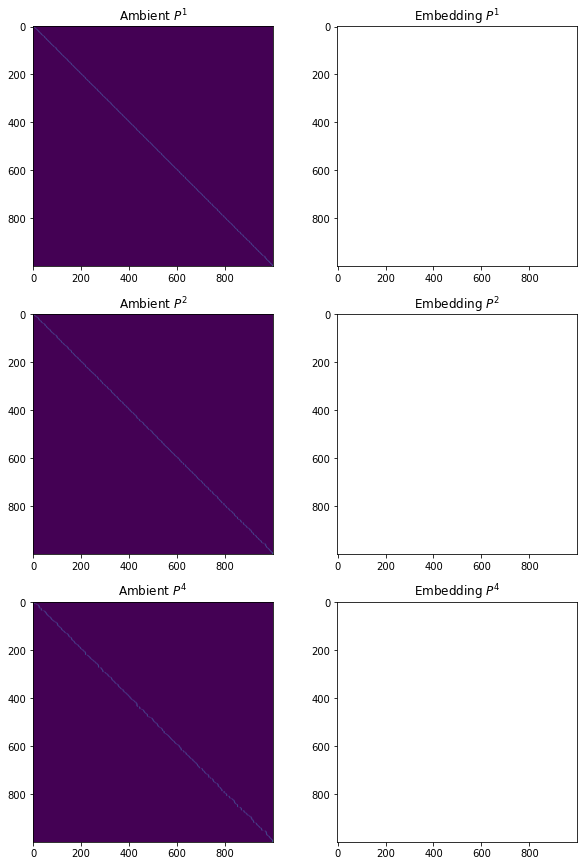

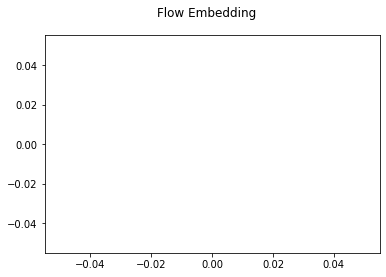

 27%|██▋       | 2700/10000 [08:29<21:17,  5.72it/s]  

EPOCH 2700. Loss nan. Flow strength nan. Heatmap of P embedding is 


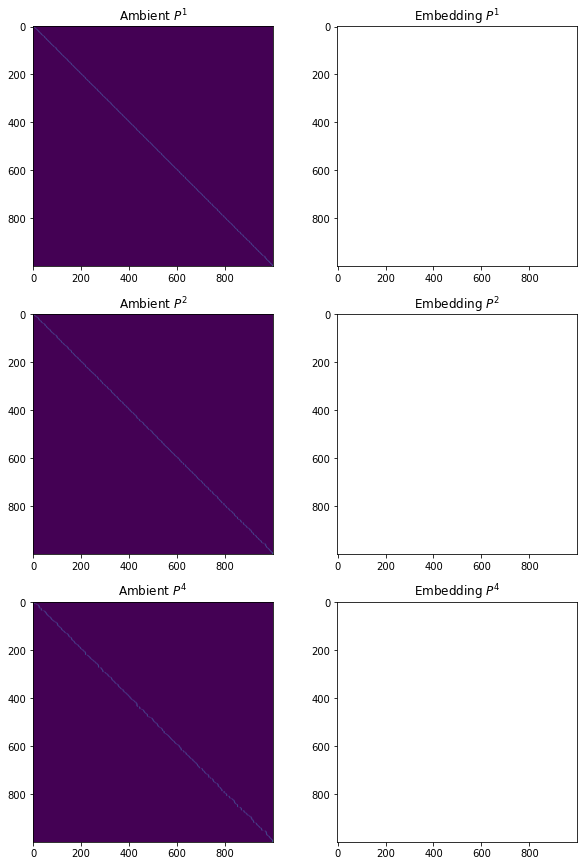

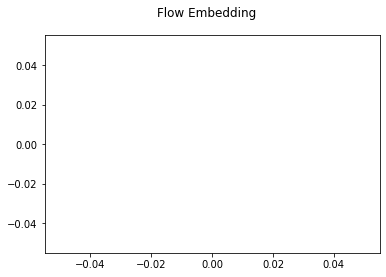

 28%|██▊       | 2800/10000 [08:47<20:49,  5.76it/s]  

EPOCH 2800. Loss nan. Flow strength nan. Heatmap of P embedding is 


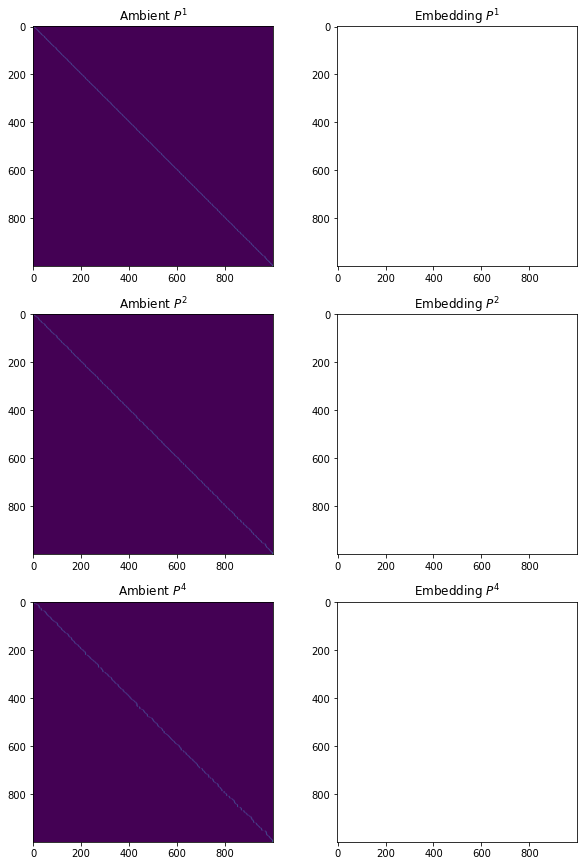

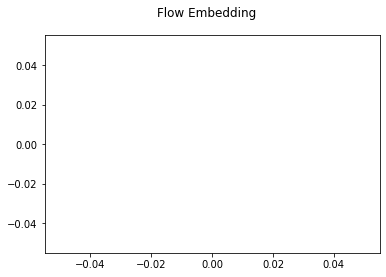

 29%|██▉       | 2900/10000 [09:06<20:24,  5.80it/s]  

EPOCH 2900. Loss nan. Flow strength nan. Heatmap of P embedding is 


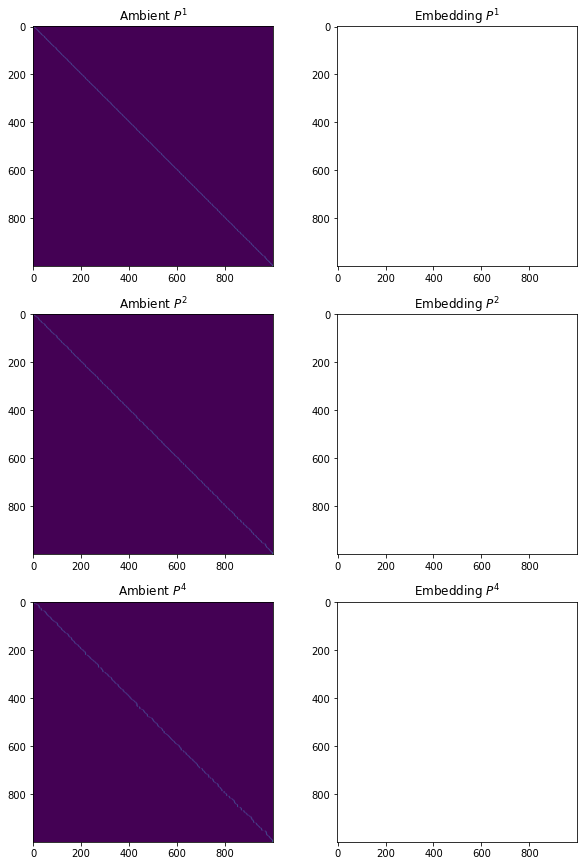

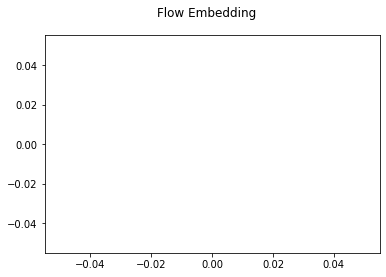

 30%|███       | 3000/10000 [09:24<20:17,  5.75it/s]  

EPOCH 3000. Loss nan. Flow strength nan. Heatmap of P embedding is 


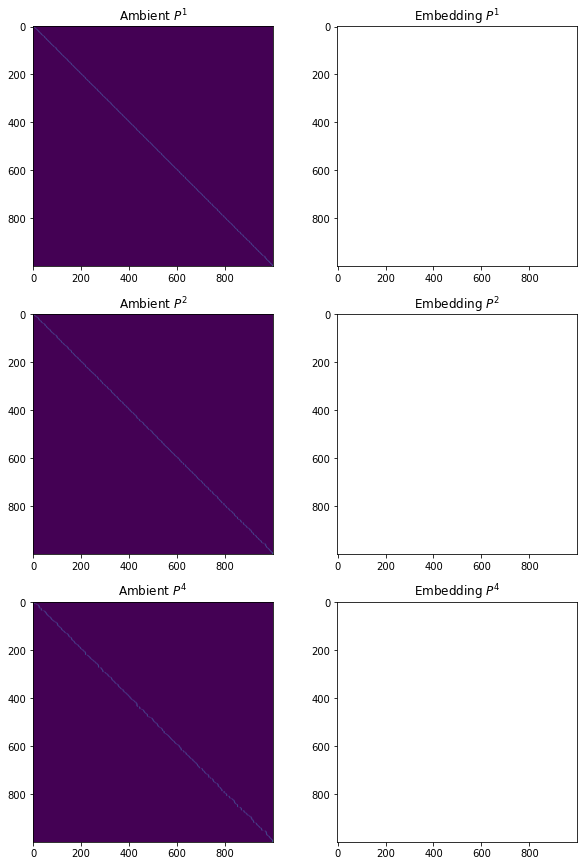

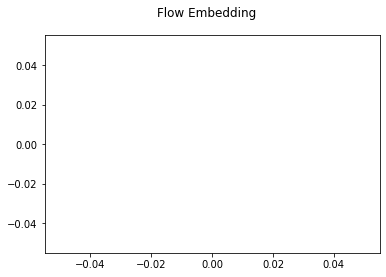

 31%|███       | 3100/10000 [09:43<20:13,  5.69it/s]  

EPOCH 3100. Loss nan. Flow strength nan. Heatmap of P embedding is 


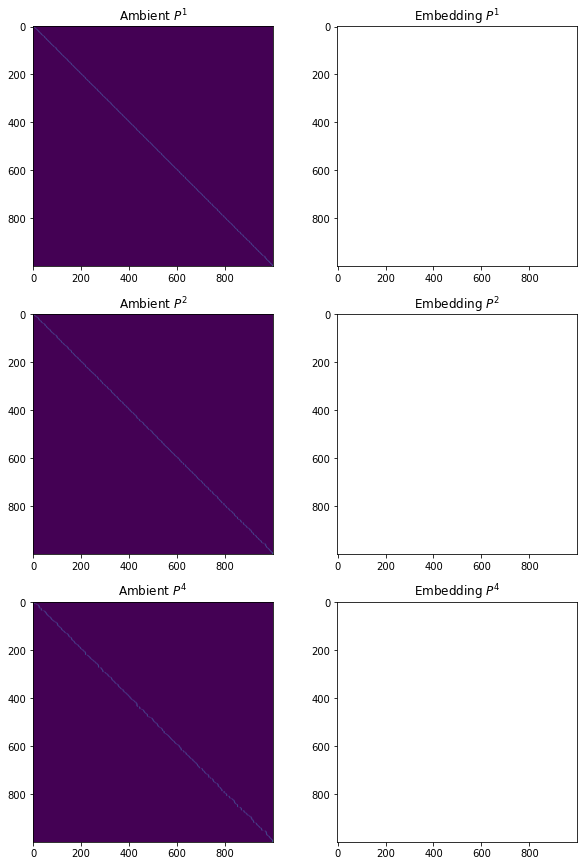

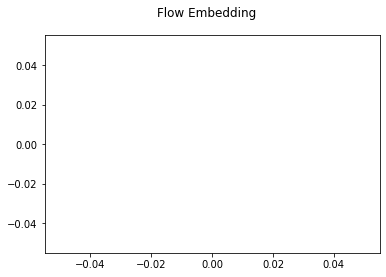

 32%|███▏      | 3200/10000 [10:01<19:34,  5.79it/s]

EPOCH 3200. Loss nan. Flow strength nan. Heatmap of P embedding is 


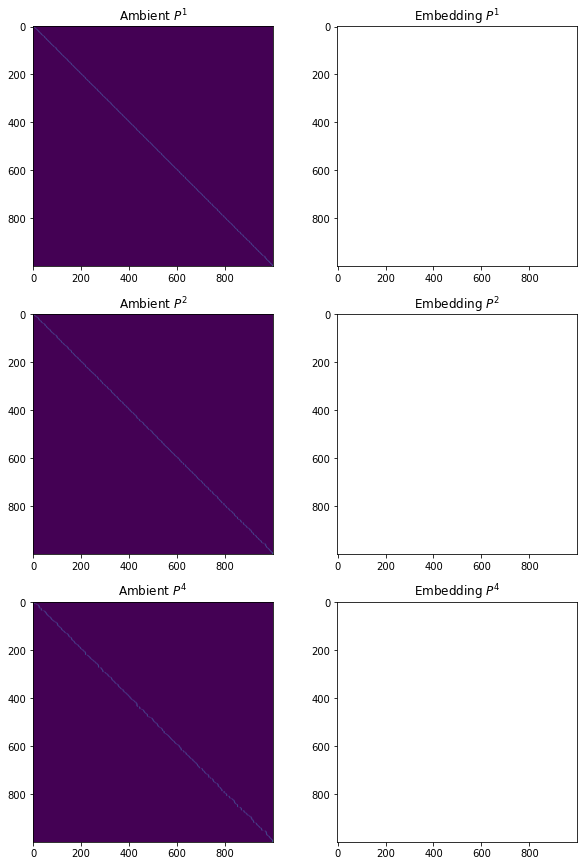

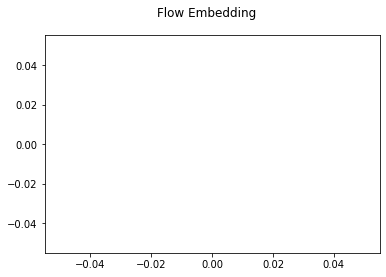

 33%|███▎      | 3300/10000 [10:21<19:20,  5.77it/s]  

EPOCH 3300. Loss nan. Flow strength nan. Heatmap of P embedding is 


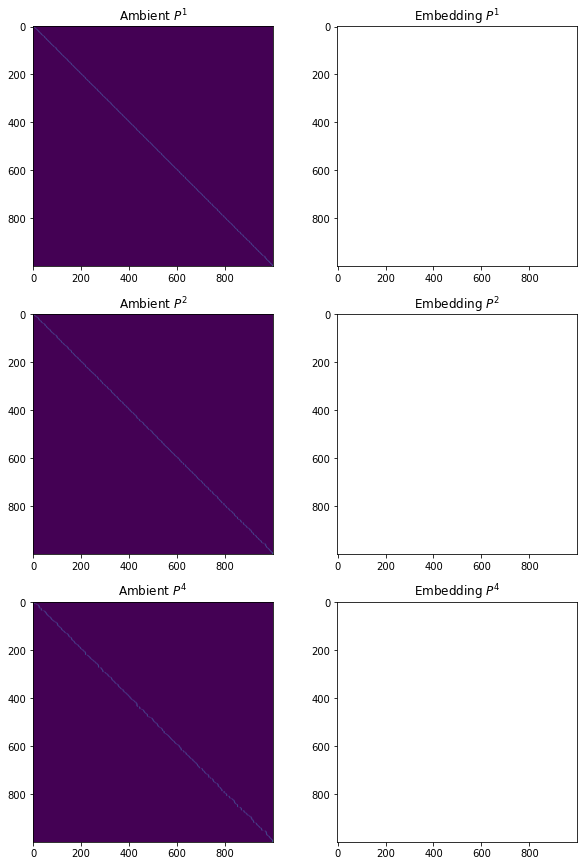

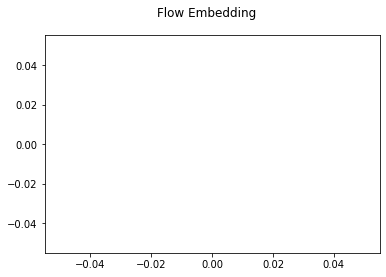

 34%|███▍      | 3400/10000 [10:39<19:10,  5.74it/s]

EPOCH 3400. Loss nan. Flow strength nan. Heatmap of P embedding is 


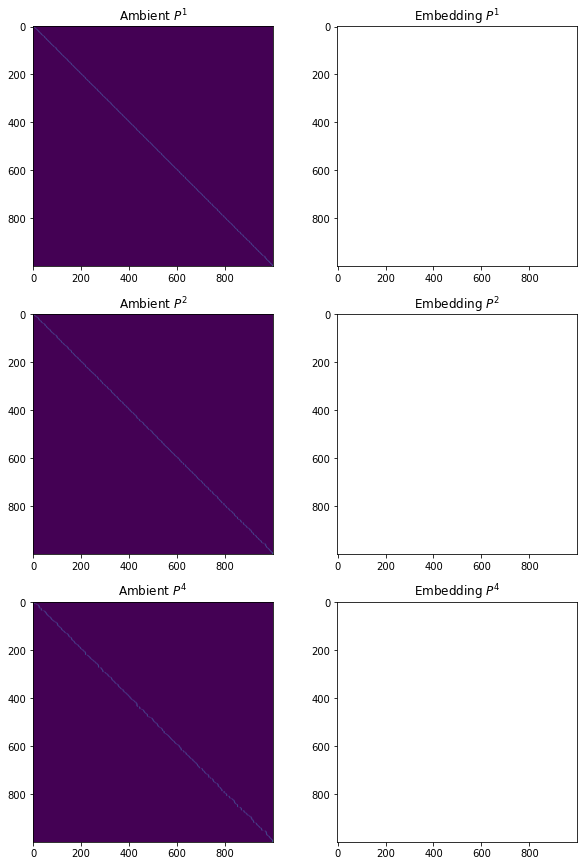

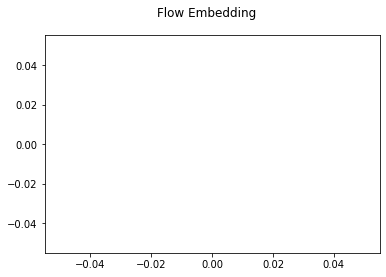

 35%|███▌      | 3500/10000 [10:58<21:56,  4.94it/s]

EPOCH 3500. Loss nan. Flow strength nan. Heatmap of P embedding is 


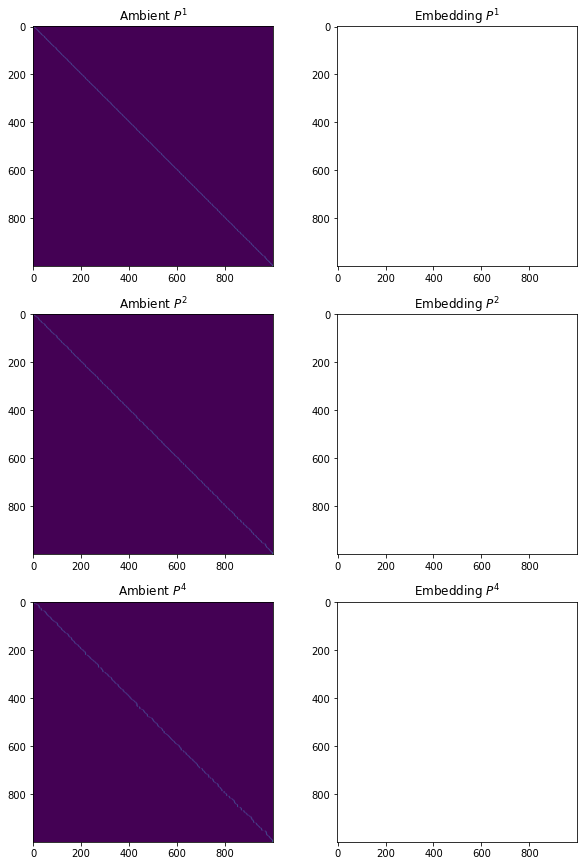

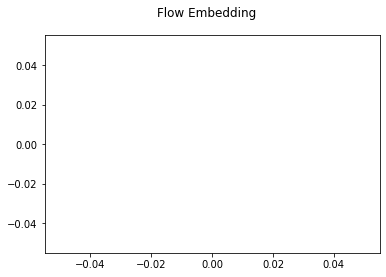

 36%|███▌      | 3600/10000 [11:16<18:28,  5.77it/s]

EPOCH 3600. Loss nan. Flow strength nan. Heatmap of P embedding is 


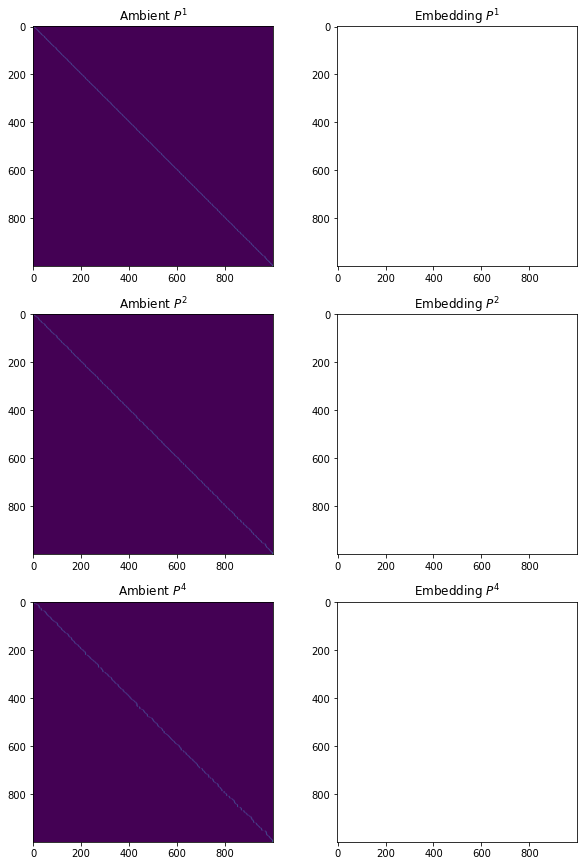

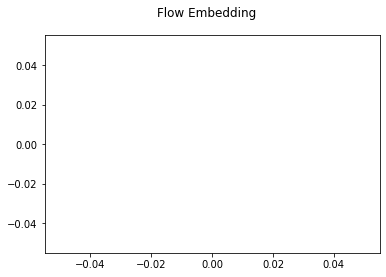

 37%|███▋      | 3700/10000 [11:35<18:07,  5.79it/s]

EPOCH 3700. Loss nan. Flow strength nan. Heatmap of P embedding is 


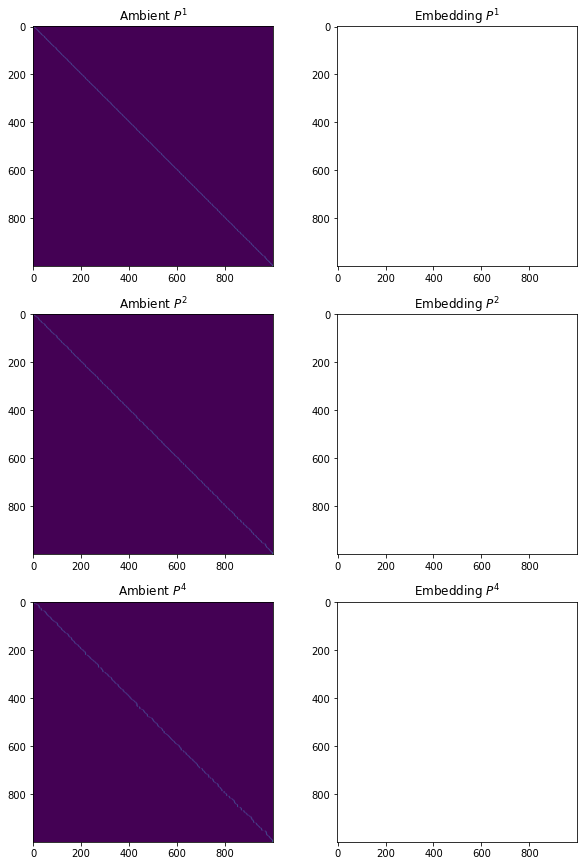

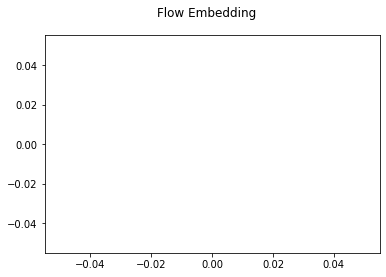

 38%|███▊      | 3800/10000 [11:54<17:51,  5.79it/s]

EPOCH 3800. Loss nan. Flow strength nan. Heatmap of P embedding is 


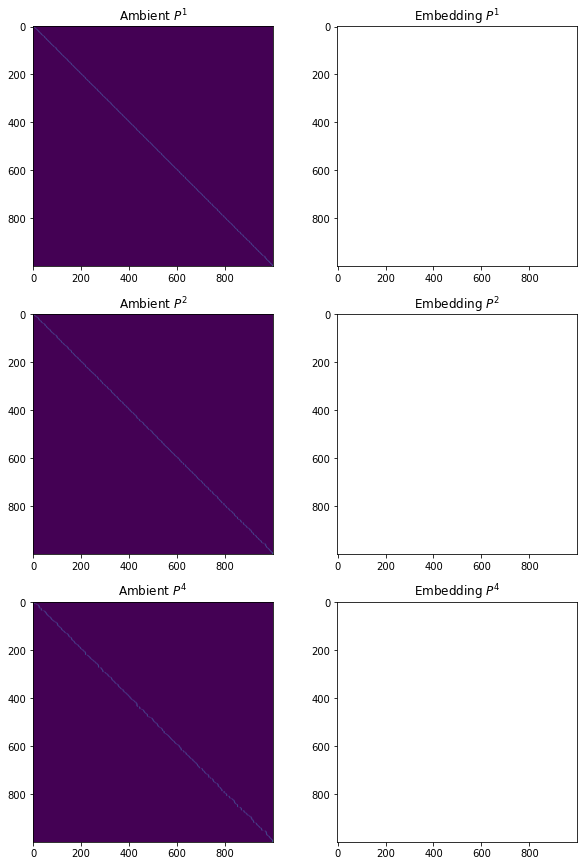

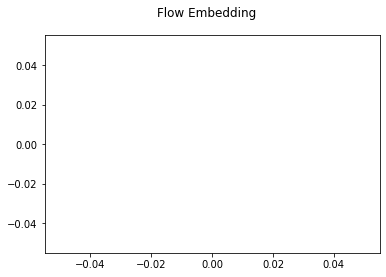

 39%|███▉      | 3900/10000 [12:12<18:01,  5.64it/s]

EPOCH 3900. Loss nan. Flow strength nan. Heatmap of P embedding is 


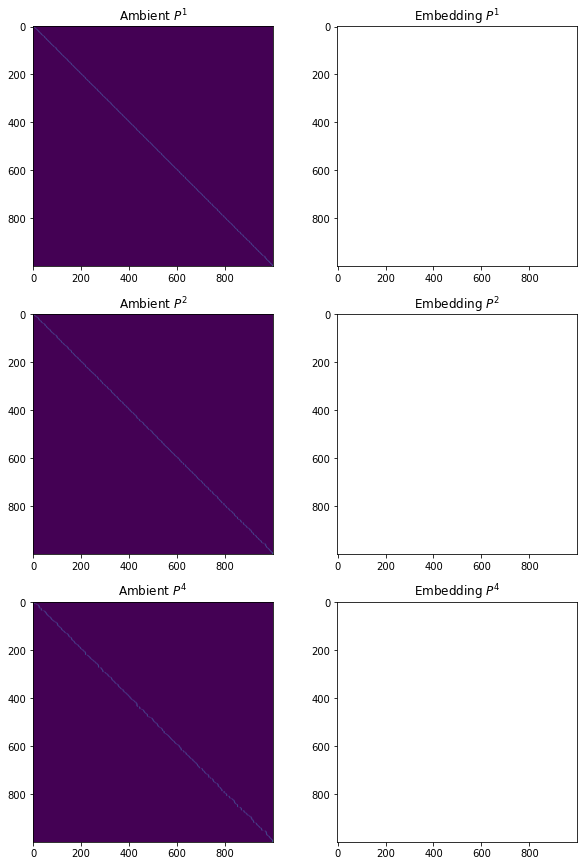

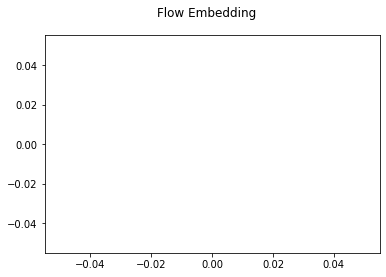

 40%|████      | 4000/10000 [12:31<17:26,  5.73it/s]

EPOCH 4000. Loss nan. Flow strength nan. Heatmap of P embedding is 


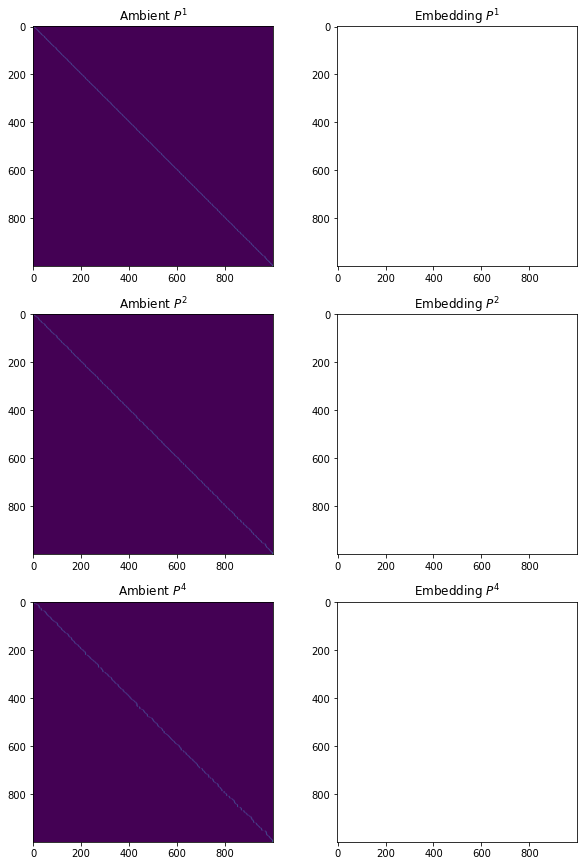

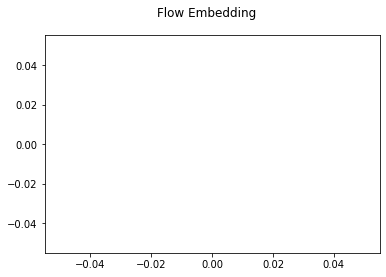

 41%|████      | 4100/10000 [12:50<17:10,  5.72it/s]

EPOCH 4100. Loss nan. Flow strength nan. Heatmap of P embedding is 


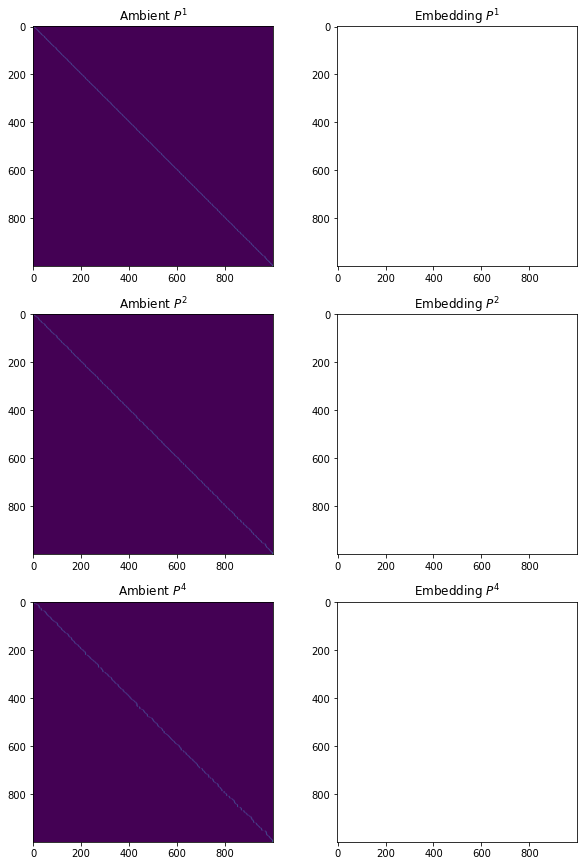

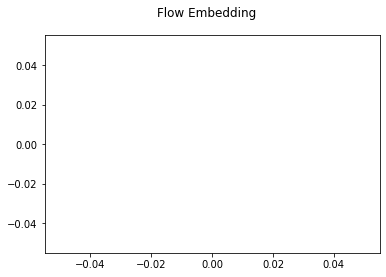

 42%|████▏     | 4200/10000 [13:09<16:49,  5.75it/s]

EPOCH 4200. Loss nan. Flow strength nan. Heatmap of P embedding is 


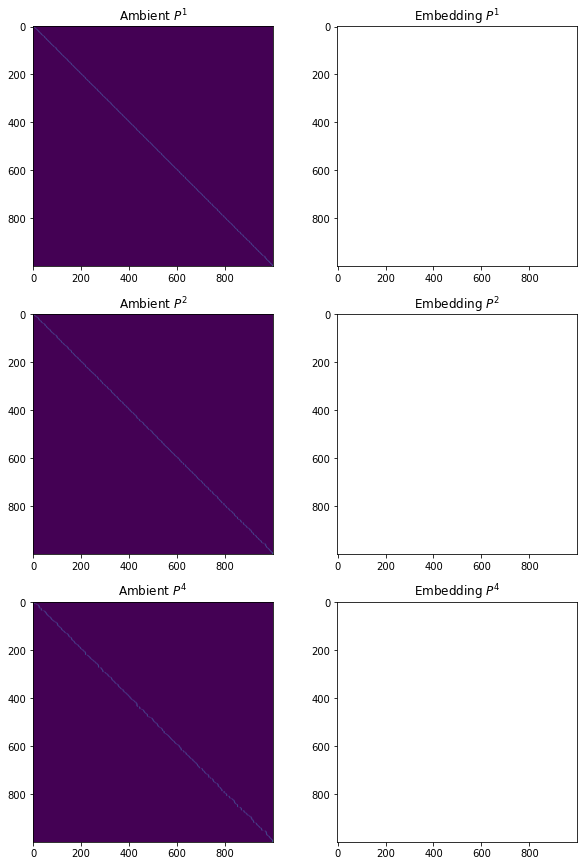

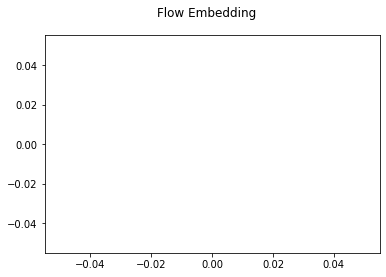

 43%|████▎     | 4300/10000 [13:27<16:30,  5.75it/s]

EPOCH 4300. Loss nan. Flow strength nan. Heatmap of P embedding is 


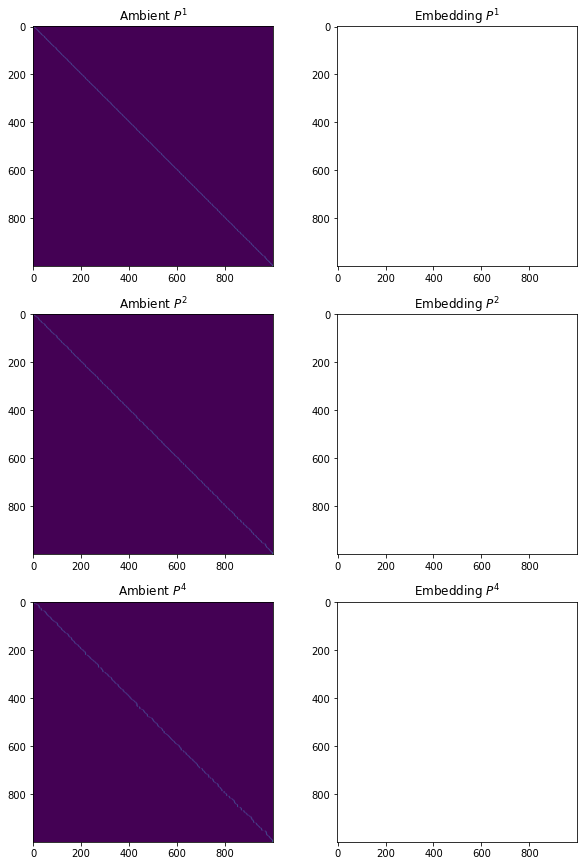

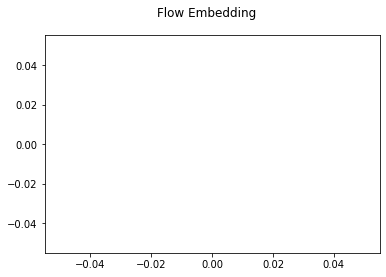

 44%|████▍     | 4400/10000 [13:46<16:24,  5.69it/s]

EPOCH 4400. Loss nan. Flow strength nan. Heatmap of P embedding is 


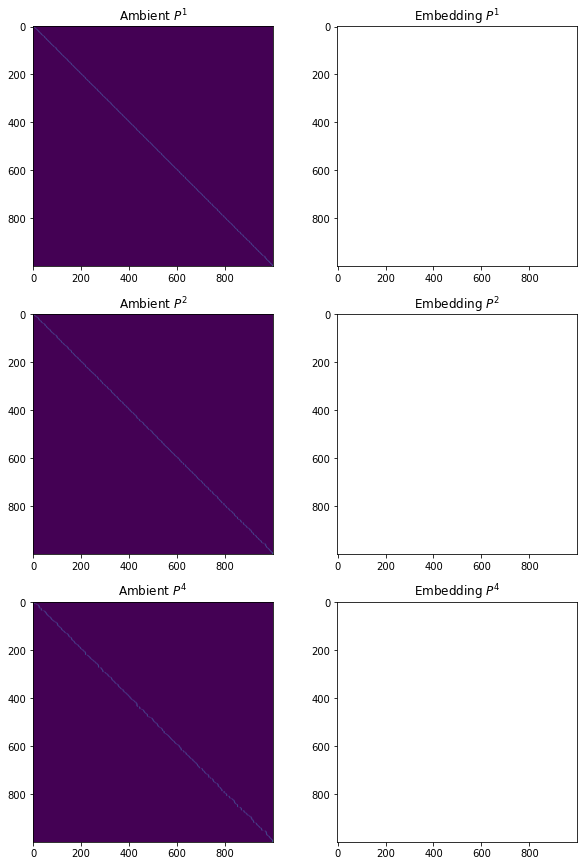

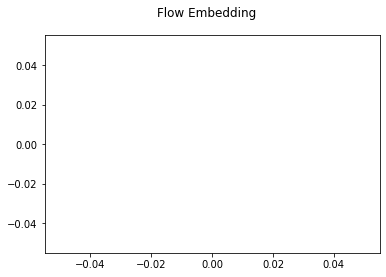

 45%|████▌     | 4500/10000 [14:05<16:12,  5.65it/s]

EPOCH 4500. Loss nan. Flow strength nan. Heatmap of P embedding is 


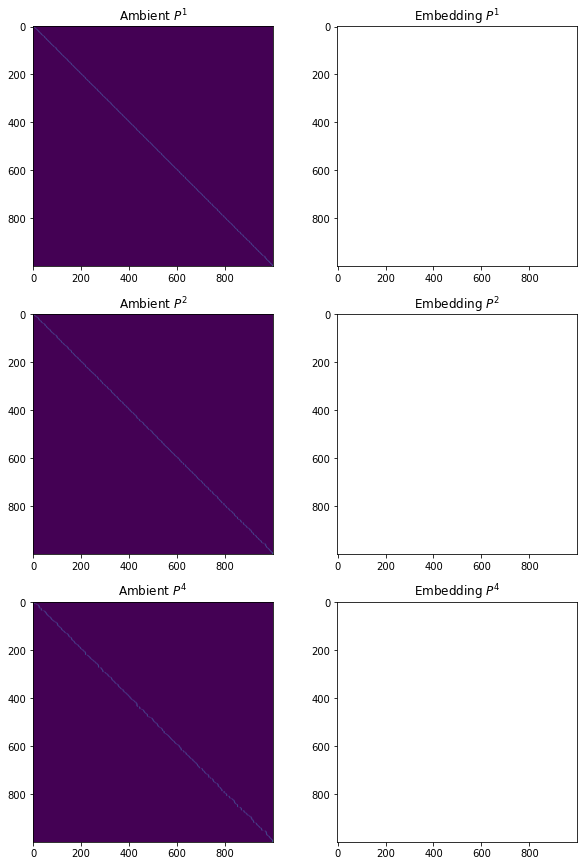

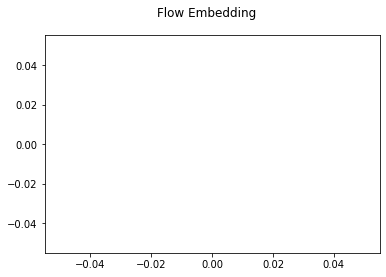

 46%|████▌     | 4600/10000 [14:24<16:37,  5.41it/s]

EPOCH 4600. Loss nan. Flow strength nan. Heatmap of P embedding is 


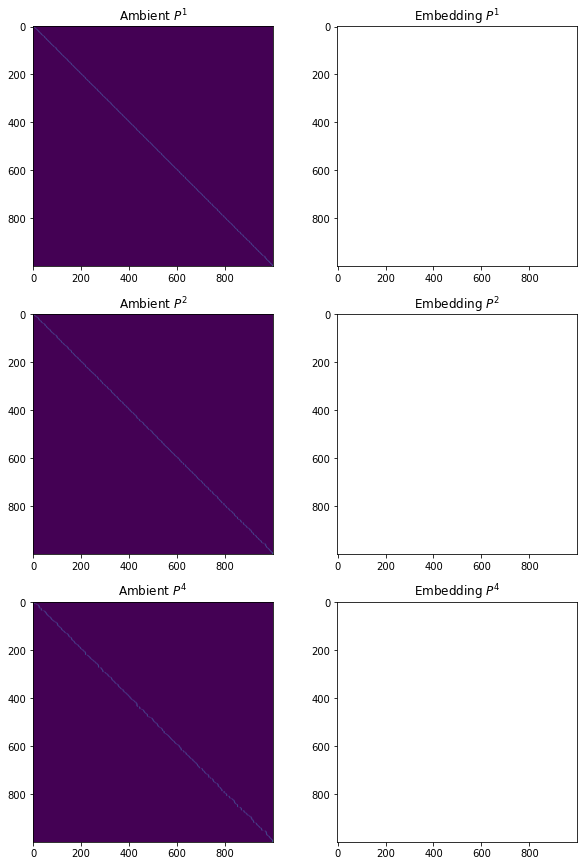

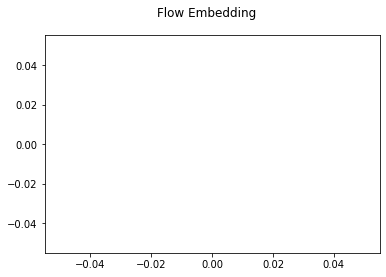

 47%|████▋     | 4700/10000 [14:43<15:28,  5.71it/s]

EPOCH 4700. Loss nan. Flow strength nan. Heatmap of P embedding is 


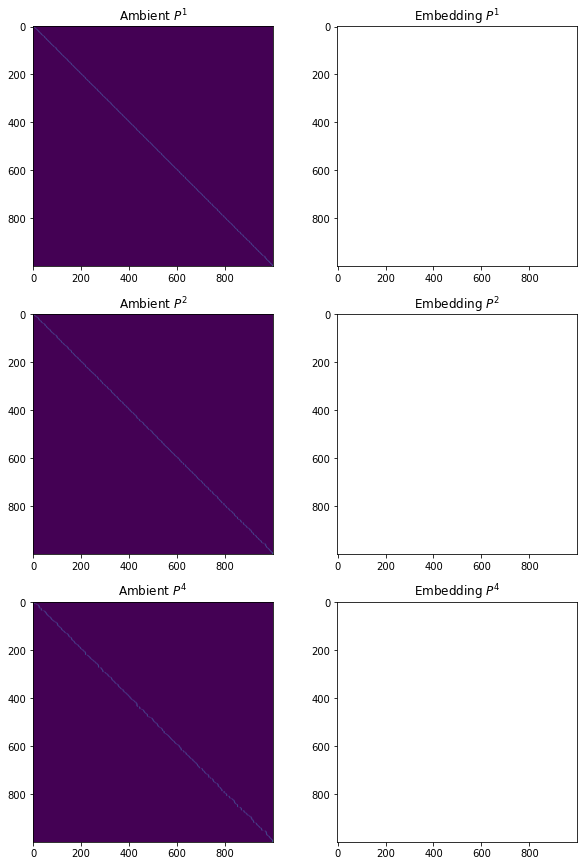

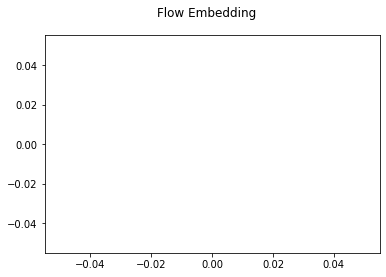

 48%|████▊     | 4800/10000 [15:01<15:03,  5.75it/s]

EPOCH 4800. Loss nan. Flow strength nan. Heatmap of P embedding is 


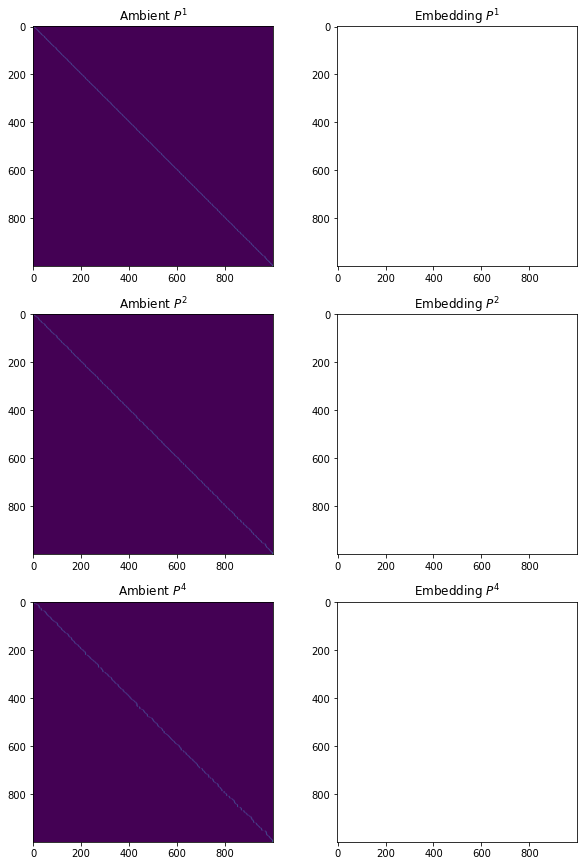

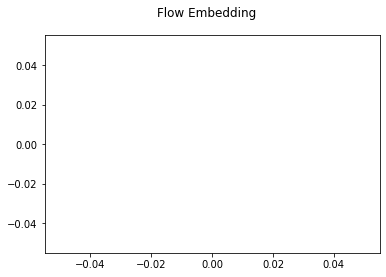

 49%|████▉     | 4900/10000 [15:20<14:43,  5.77it/s]

EPOCH 4900. Loss nan. Flow strength nan. Heatmap of P embedding is 


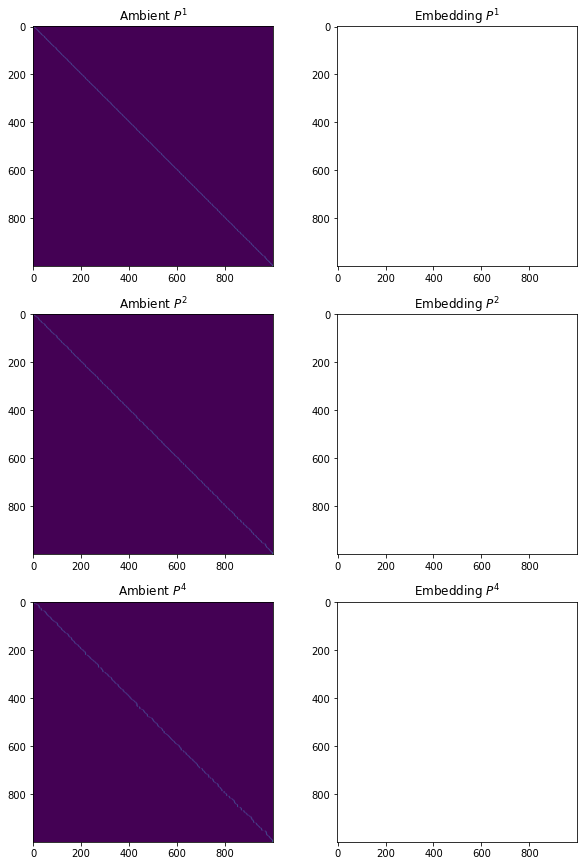

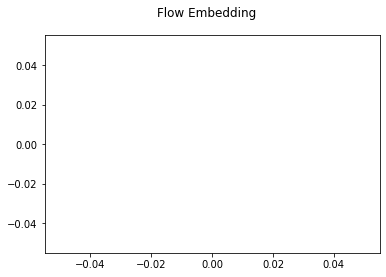

 50%|█████     | 5000/10000 [15:38<14:24,  5.78it/s]

EPOCH 5000. Loss nan. Flow strength nan. Heatmap of P embedding is 


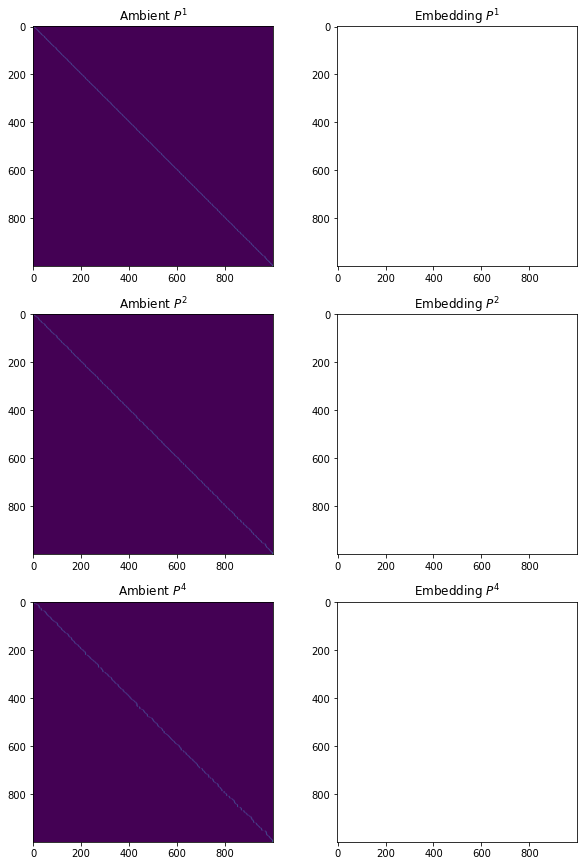

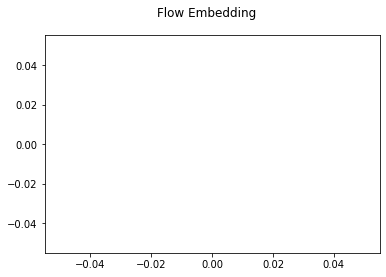

 51%|█████     | 5100/10000 [15:57<14:11,  5.76it/s]

EPOCH 5100. Loss nan. Flow strength nan. Heatmap of P embedding is 


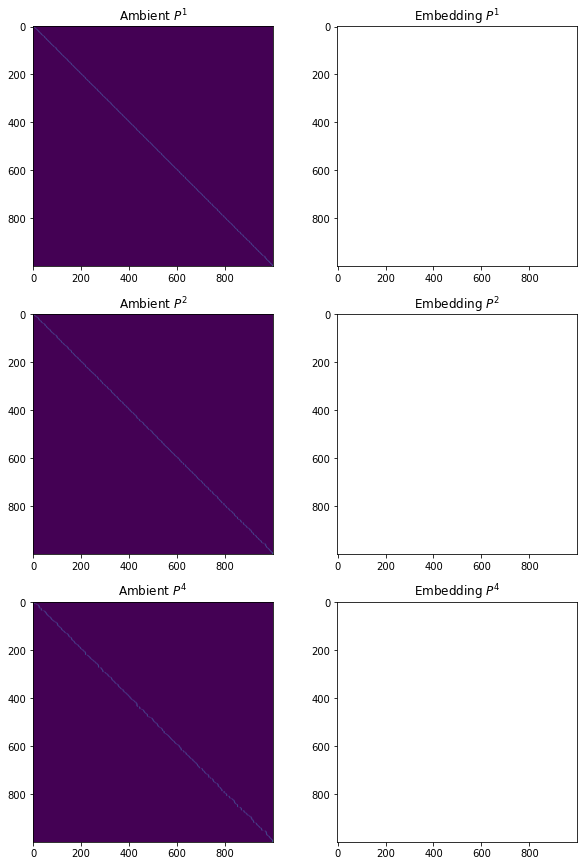

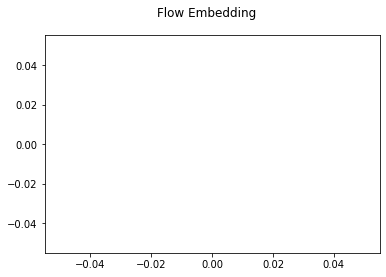

 52%|█████▏    | 5200/10000 [16:16<13:57,  5.73it/s]

EPOCH 5200. Loss nan. Flow strength nan. Heatmap of P embedding is 


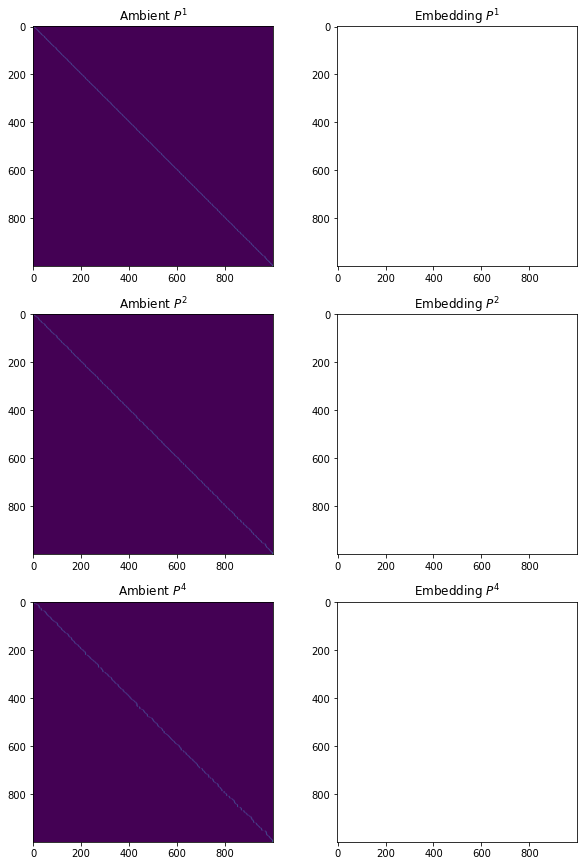

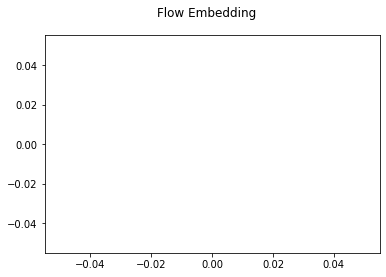

 53%|█████▎    | 5300/10000 [16:35<13:36,  5.75it/s]

EPOCH 5300. Loss nan. Flow strength nan. Heatmap of P embedding is 


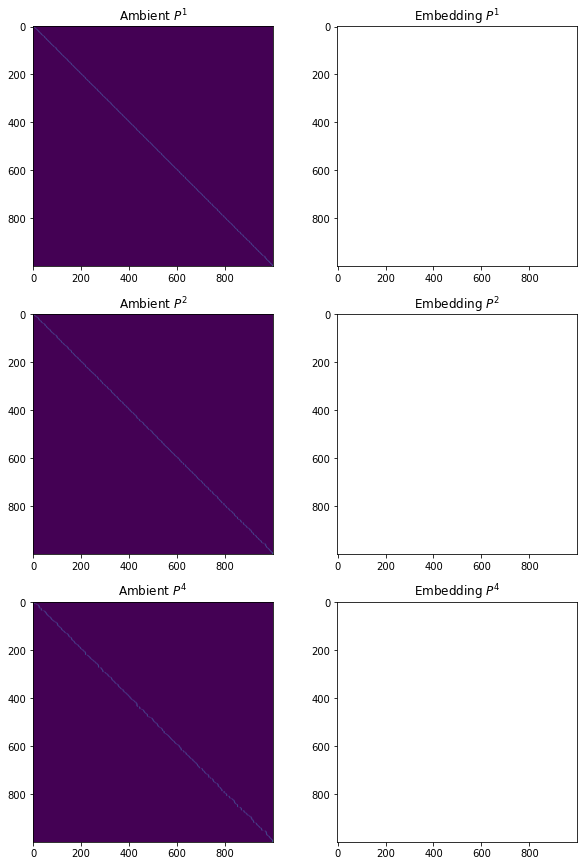

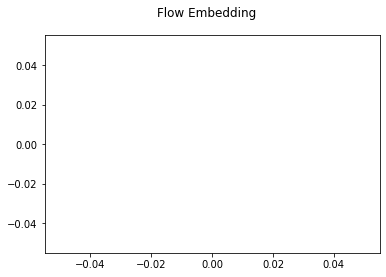

 54%|█████▍    | 5400/10000 [16:53<13:20,  5.74it/s]

EPOCH 5400. Loss nan. Flow strength nan. Heatmap of P embedding is 


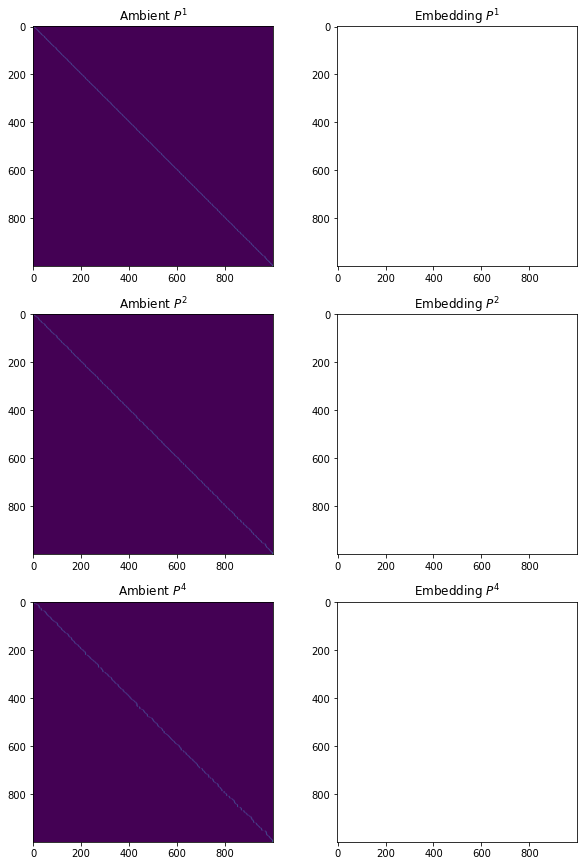

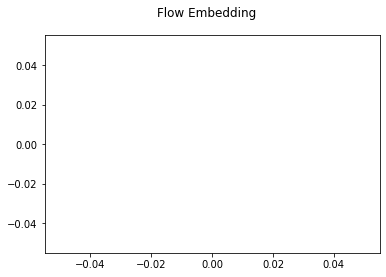

 55%|█████▌    | 5500/10000 [17:12<13:05,  5.73it/s]

EPOCH 5500. Loss nan. Flow strength nan. Heatmap of P embedding is 


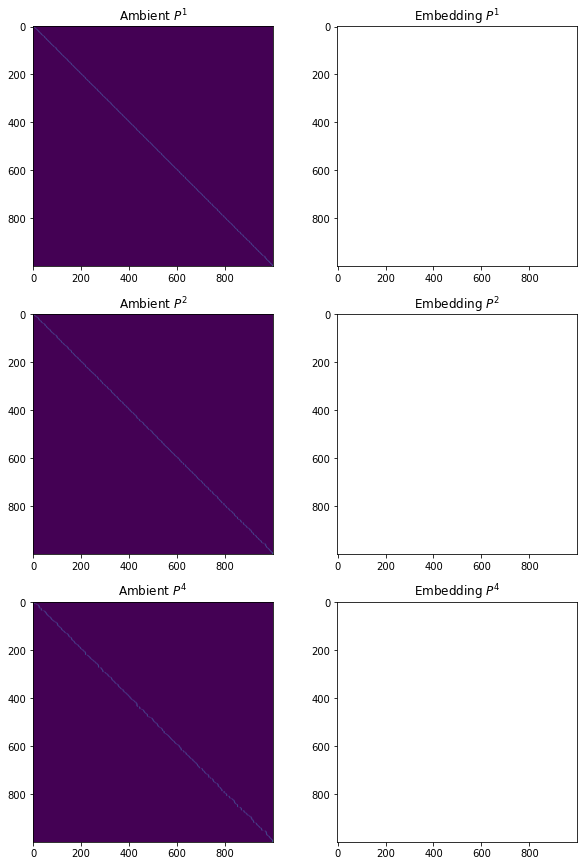

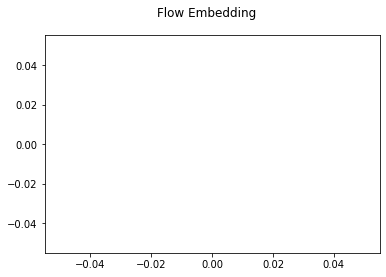

 56%|█████▌    | 5600/10000 [17:31<12:49,  5.72it/s]

EPOCH 5600. Loss nan. Flow strength nan. Heatmap of P embedding is 


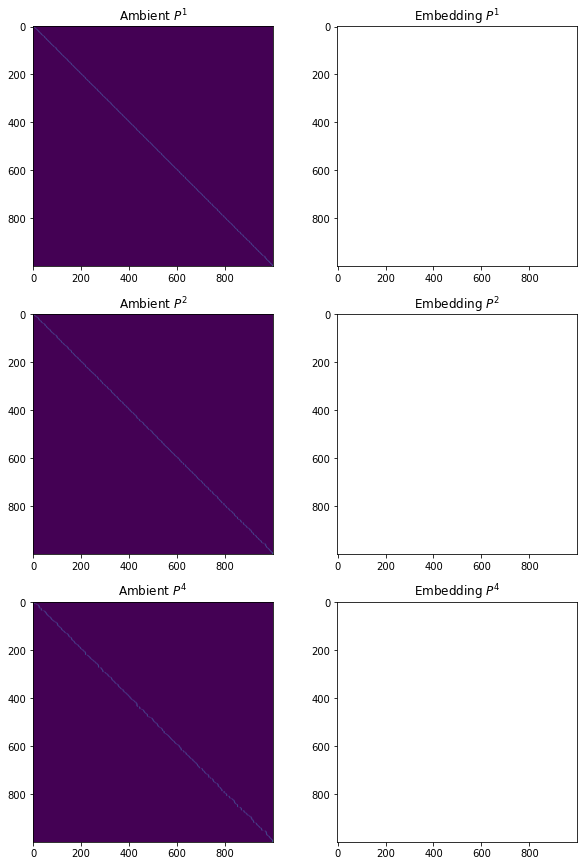

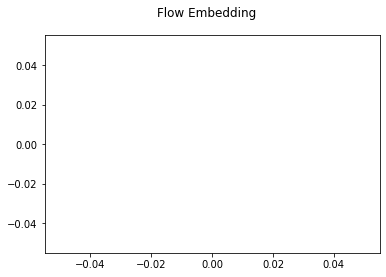

 57%|█████▋    | 5700/10000 [17:50<12:33,  5.70it/s]

EPOCH 5700. Loss nan. Flow strength nan. Heatmap of P embedding is 


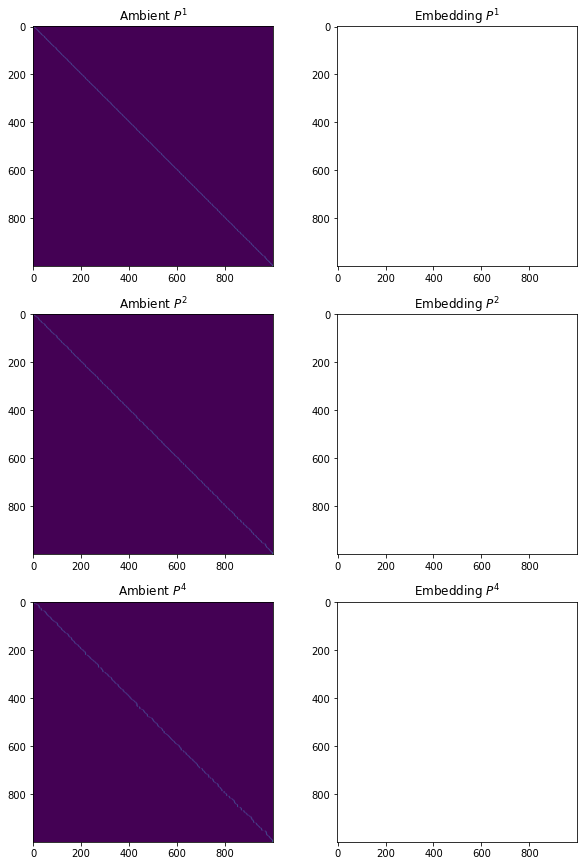

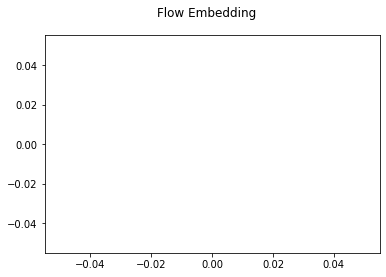

 58%|█████▊    | 5800/10000 [18:08<12:13,  5.73it/s]

EPOCH 5800. Loss nan. Flow strength nan. Heatmap of P embedding is 


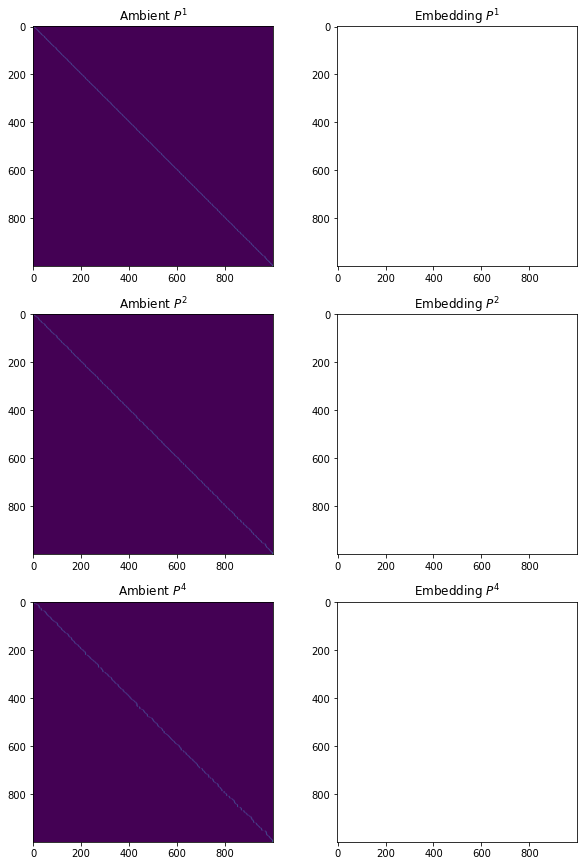

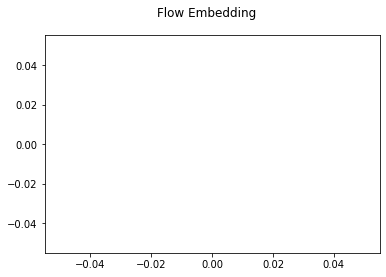

 59%|█████▉    | 5900/10000 [18:28<12:10,  5.61it/s]

EPOCH 5900. Loss nan. Flow strength nan. Heatmap of P embedding is 


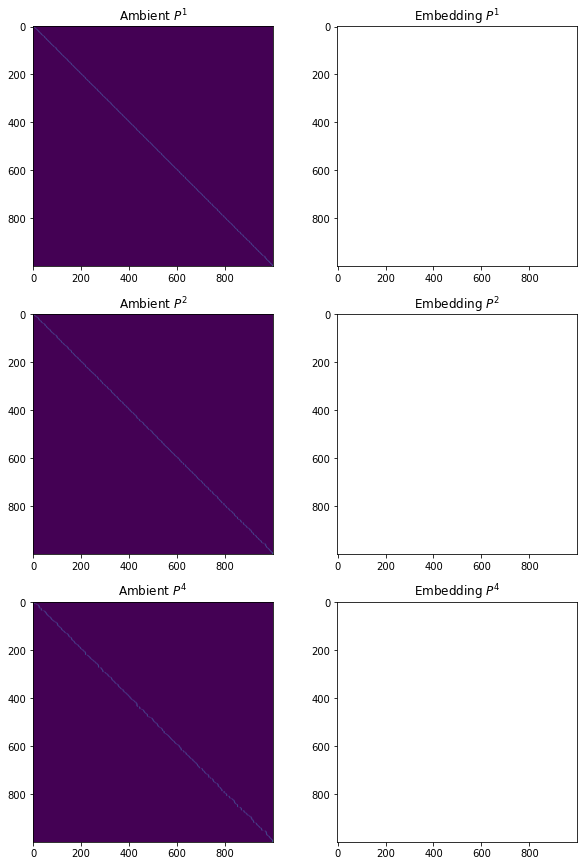

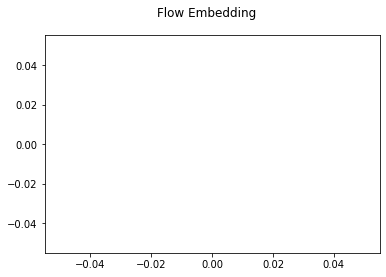

 60%|██████    | 6000/10000 [18:47<11:49,  5.64it/s]

EPOCH 6000. Loss nan. Flow strength nan. Heatmap of P embedding is 


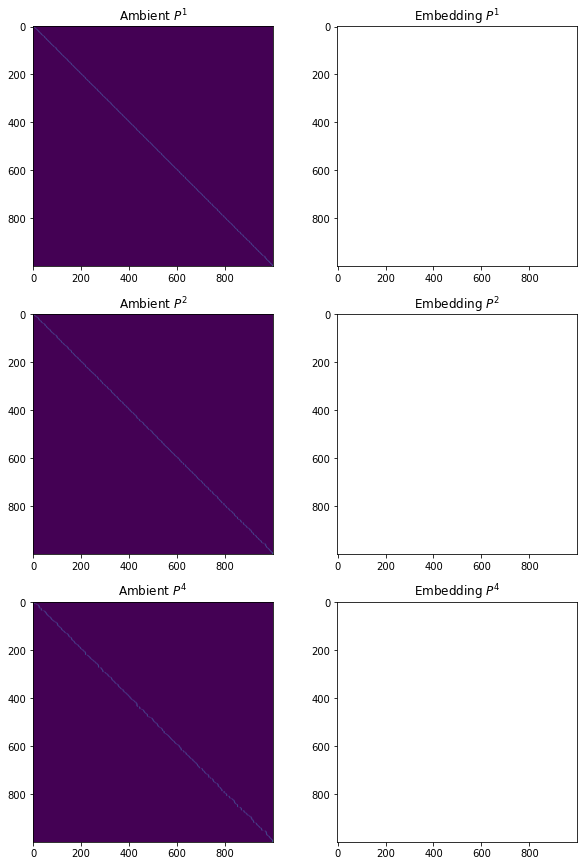

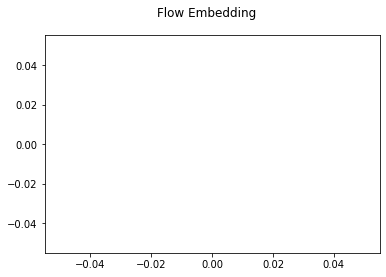

 61%|██████    | 6100/10000 [19:06<11:26,  5.68it/s]

EPOCH 6100. Loss nan. Flow strength nan. Heatmap of P embedding is 


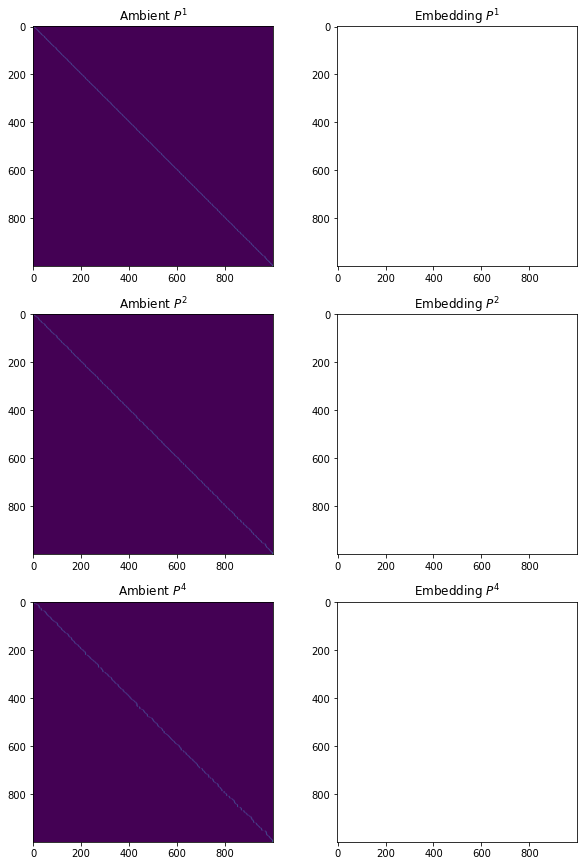

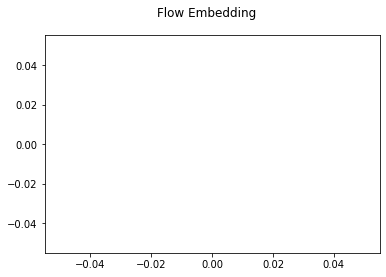

 62%|██████▏   | 6200/10000 [19:25<11:07,  5.69it/s]

EPOCH 6200. Loss nan. Flow strength nan. Heatmap of P embedding is 


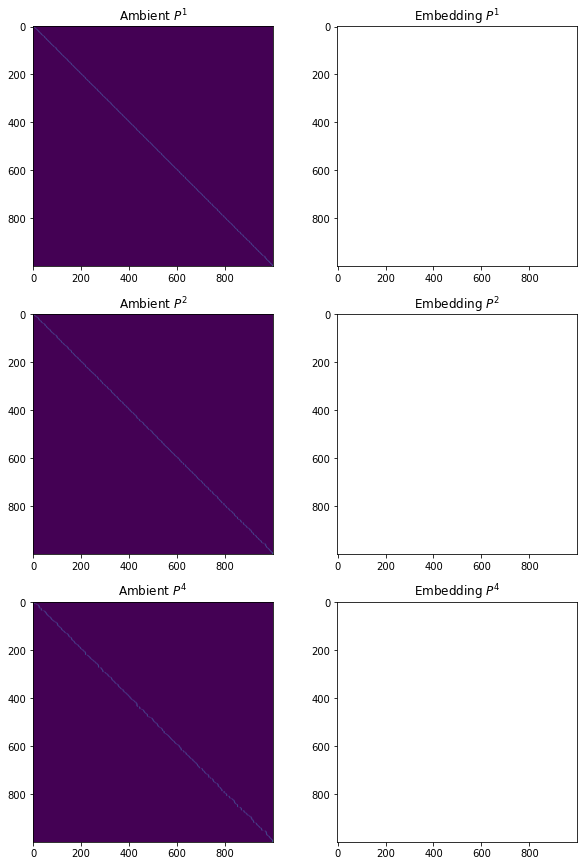

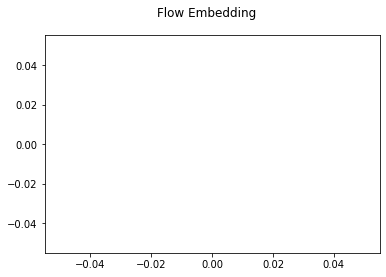

 63%|██████▎   | 6300/10000 [19:44<10:38,  5.80it/s]

EPOCH 6300. Loss nan. Flow strength nan. Heatmap of P embedding is 


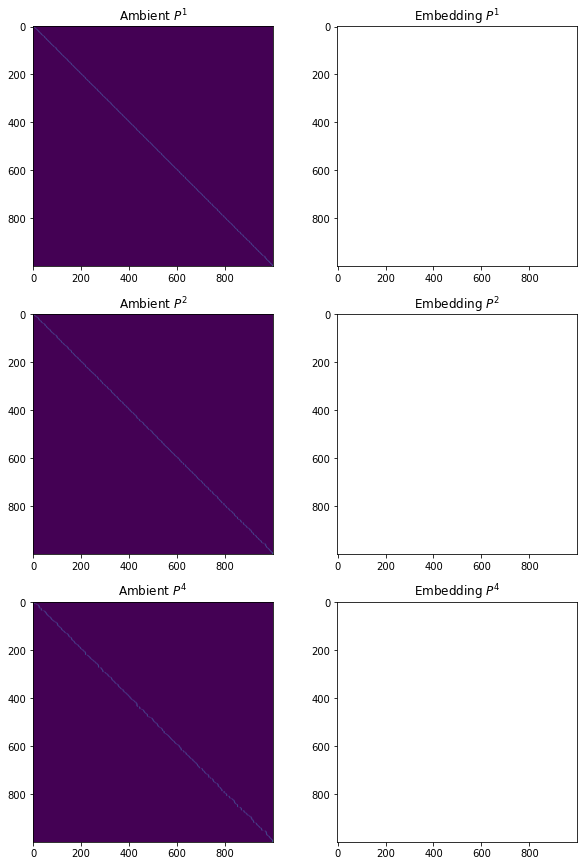

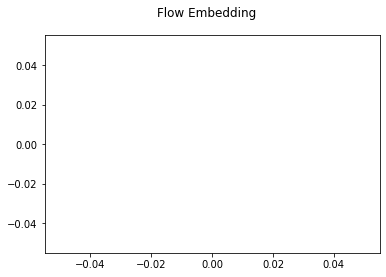

 64%|██████▍   | 6400/10000 [20:02<10:23,  5.77it/s]

EPOCH 6400. Loss nan. Flow strength nan. Heatmap of P embedding is 


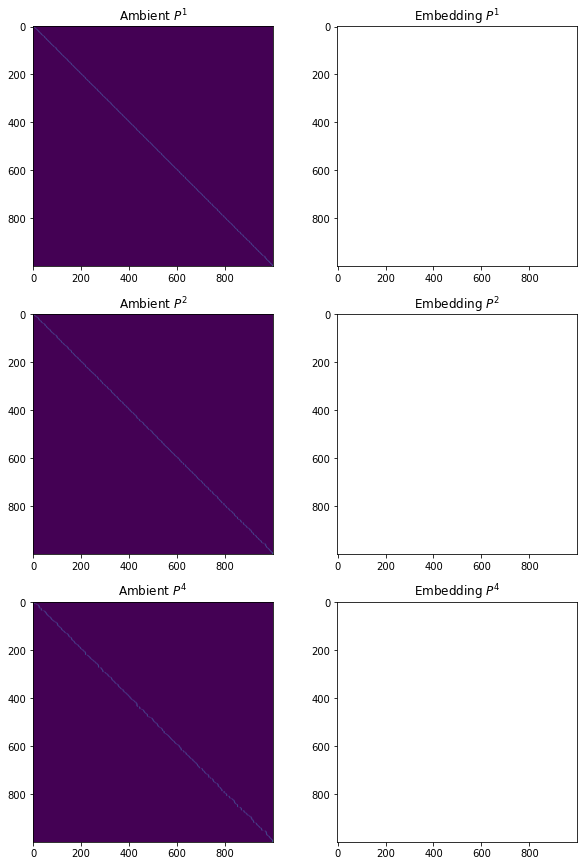

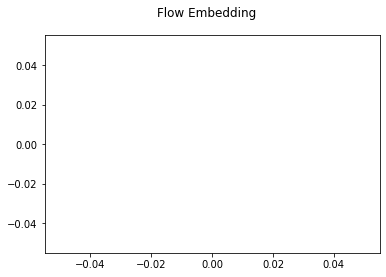

 65%|██████▌   | 6500/10000 [20:21<10:08,  5.75it/s]

EPOCH 6500. Loss nan. Flow strength nan. Heatmap of P embedding is 


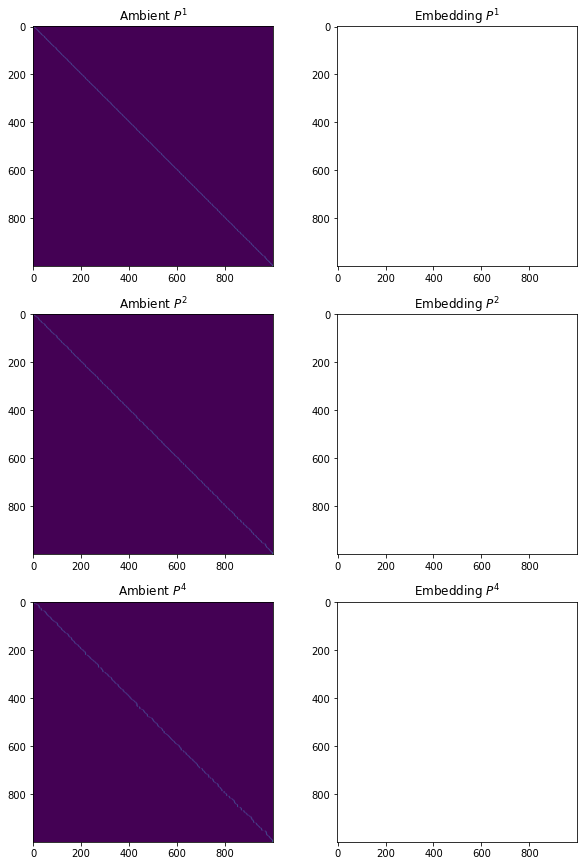

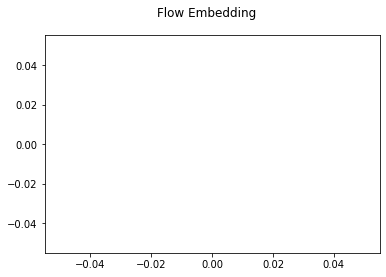

 66%|██████▌   | 6600/10000 [20:40<09:46,  5.80it/s]

EPOCH 6600. Loss nan. Flow strength nan. Heatmap of P embedding is 


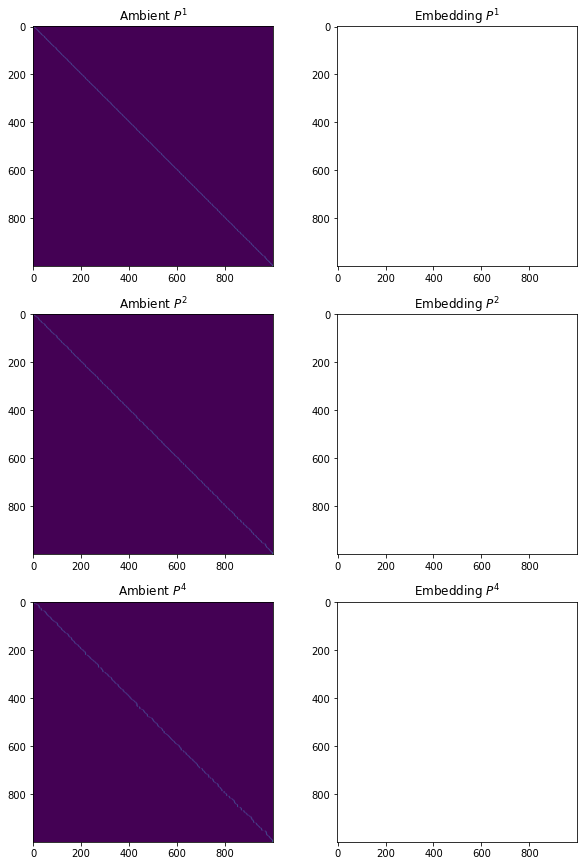

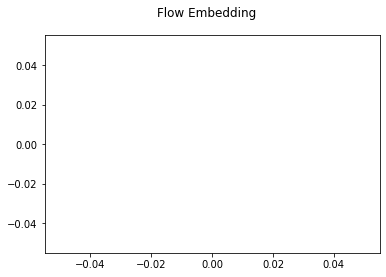

 67%|██████▋   | 6700/10000 [20:58<09:43,  5.66it/s]

EPOCH 6700. Loss nan. Flow strength nan. Heatmap of P embedding is 


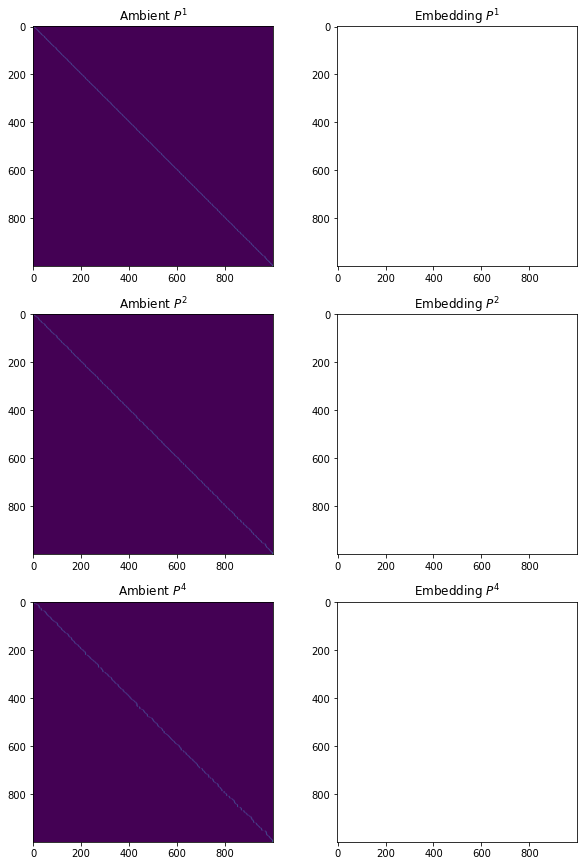

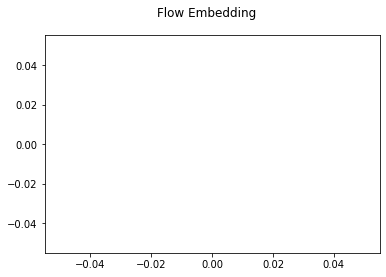

 68%|██████▊   | 6800/10000 [21:17<09:29,  5.62it/s]

EPOCH 6800. Loss nan. Flow strength nan. Heatmap of P embedding is 


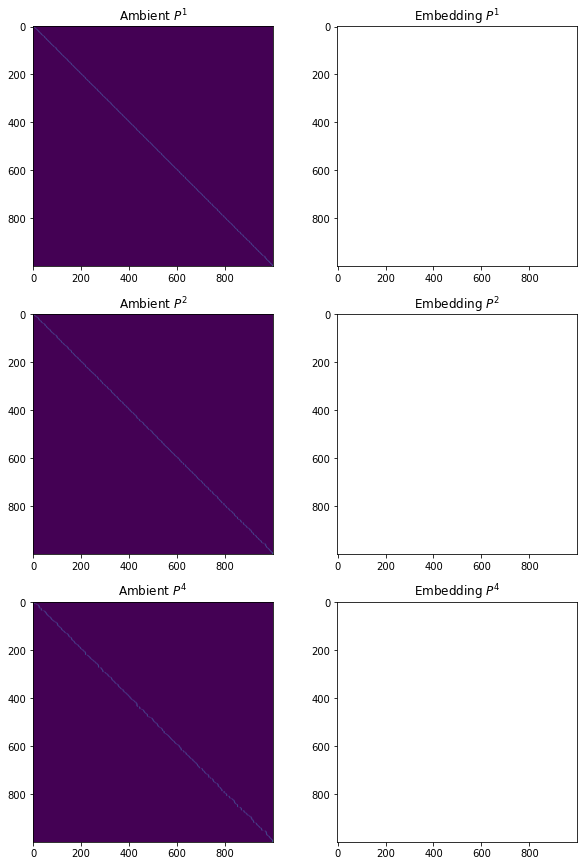

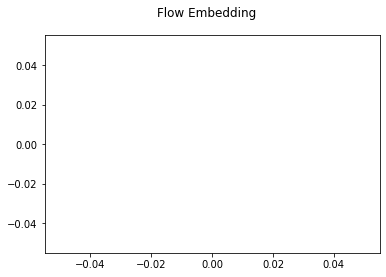

 69%|██████▉   | 6900/10000 [21:36<09:00,  5.74it/s]

EPOCH 6900. Loss nan. Flow strength nan. Heatmap of P embedding is 


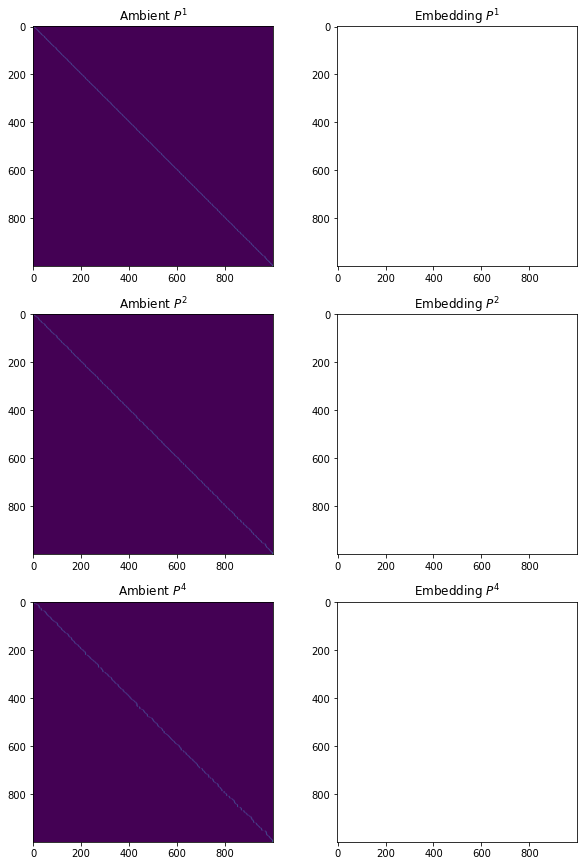

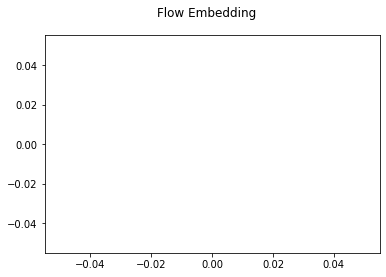

 70%|███████   | 7000/10000 [21:54<08:45,  5.71it/s]

EPOCH 7000. Loss nan. Flow strength nan. Heatmap of P embedding is 


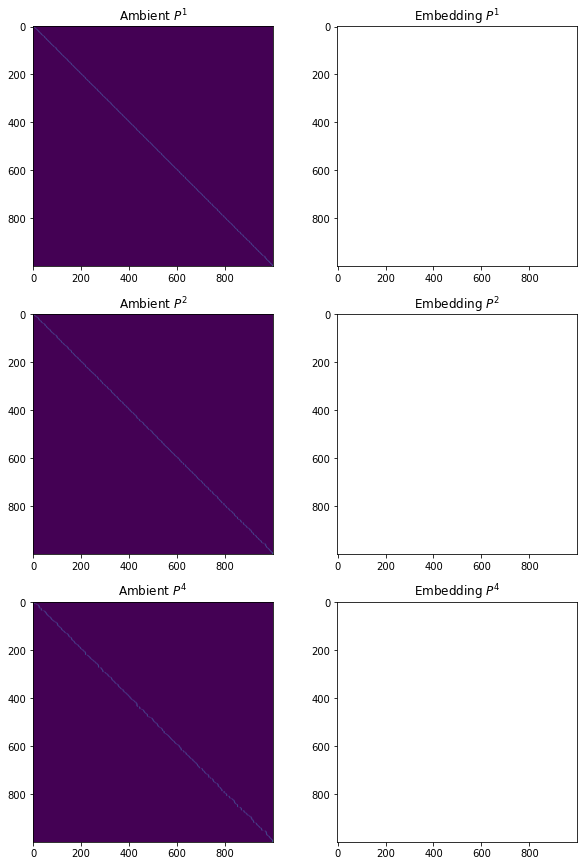

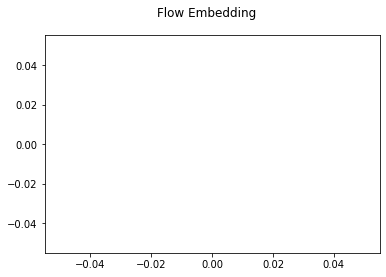

 71%|███████   | 7100/10000 [22:14<08:29,  5.70it/s]

EPOCH 7100. Loss nan. Flow strength nan. Heatmap of P embedding is 


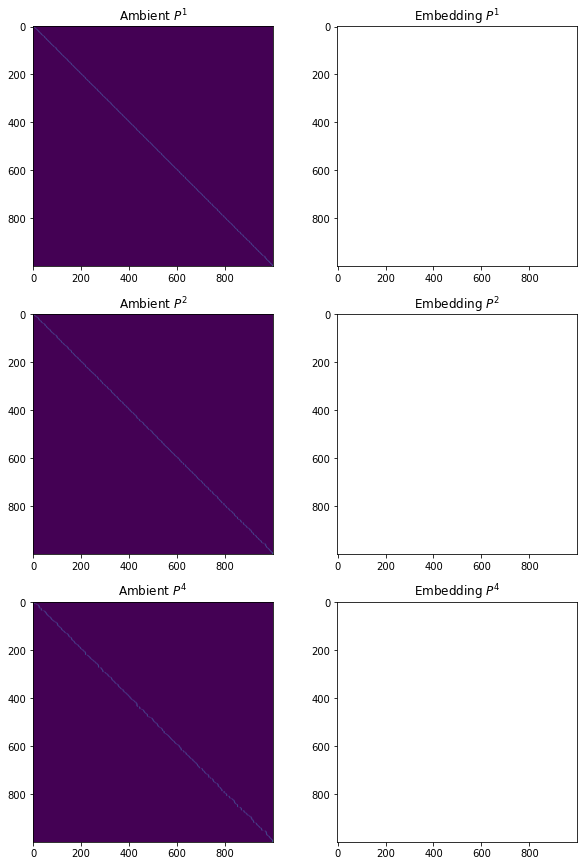

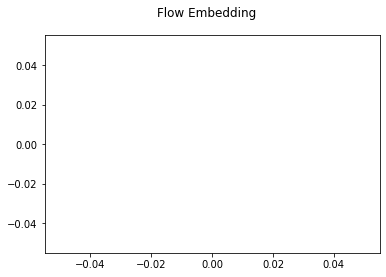

 72%|███████▏  | 7200/10000 [22:32<08:07,  5.74it/s]

EPOCH 7200. Loss nan. Flow strength nan. Heatmap of P embedding is 


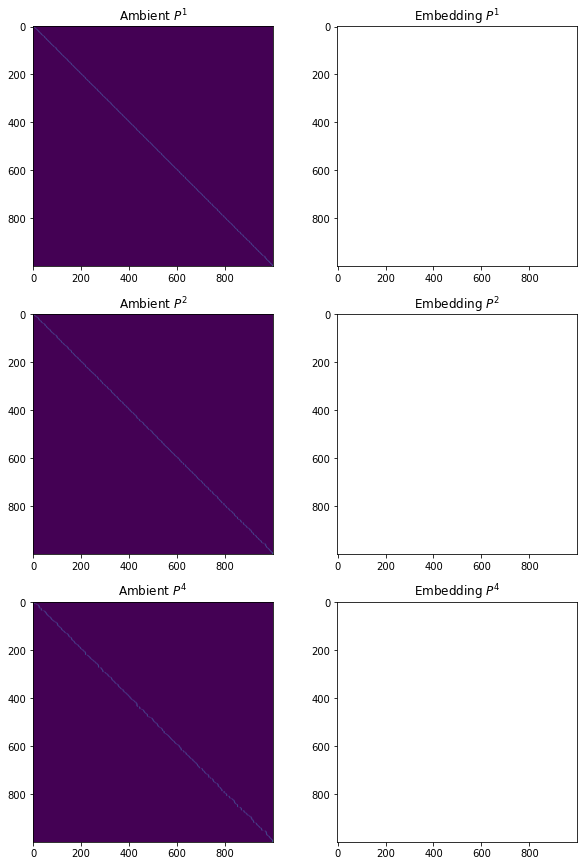

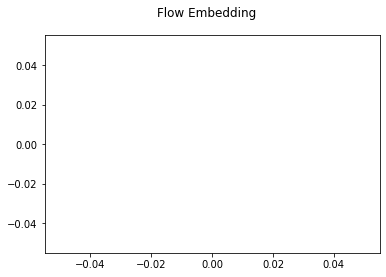

 73%|███████▎  | 7300/10000 [22:51<07:48,  5.77it/s]

EPOCH 7300. Loss nan. Flow strength nan. Heatmap of P embedding is 


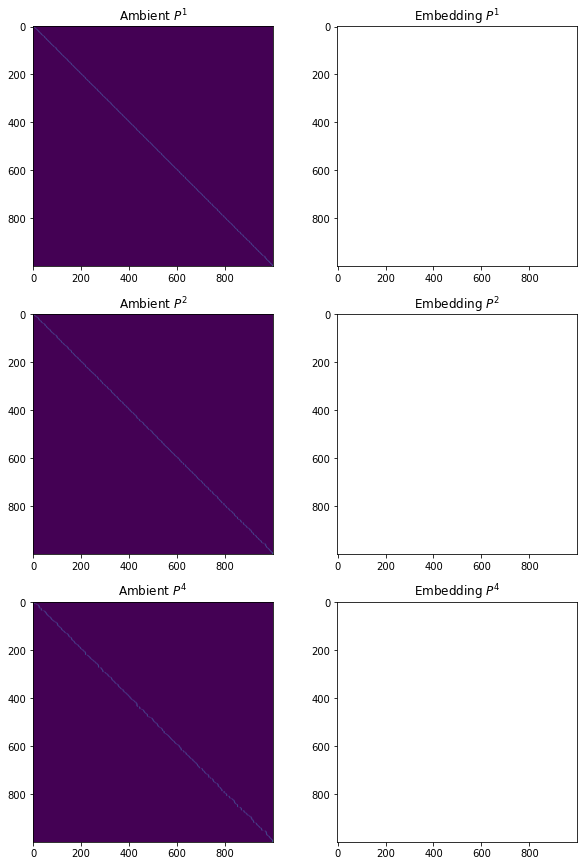

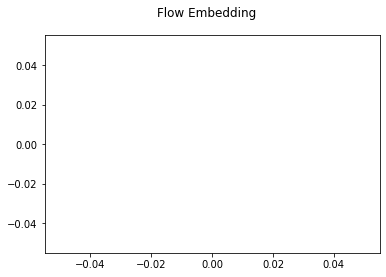

 74%|███████▍  | 7400/10000 [23:10<07:34,  5.73it/s]

EPOCH 7400. Loss nan. Flow strength nan. Heatmap of P embedding is 


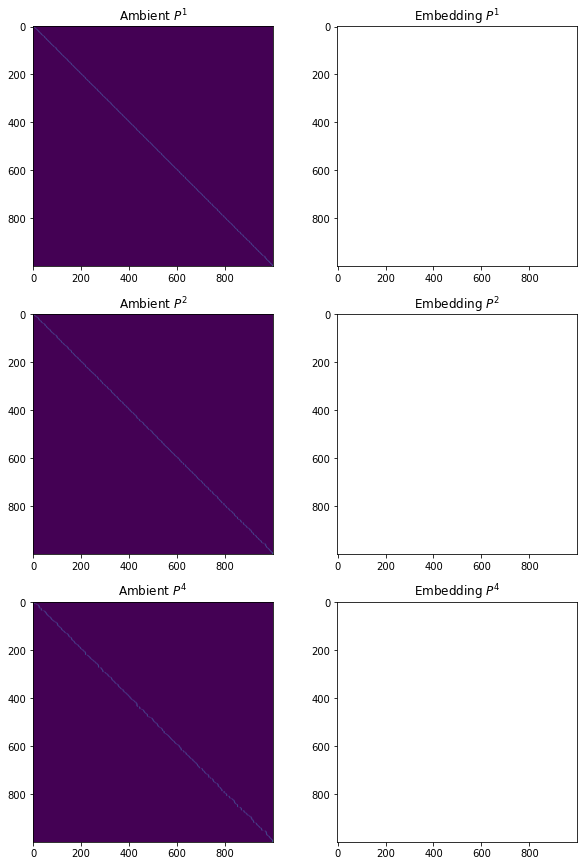

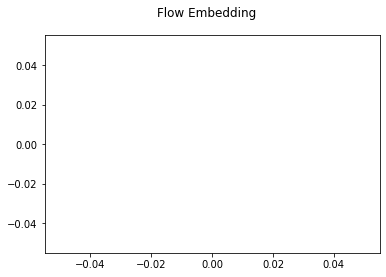

 75%|███████▌  | 7500/10000 [23:28<07:36,  5.48it/s]

EPOCH 7500. Loss nan. Flow strength nan. Heatmap of P embedding is 


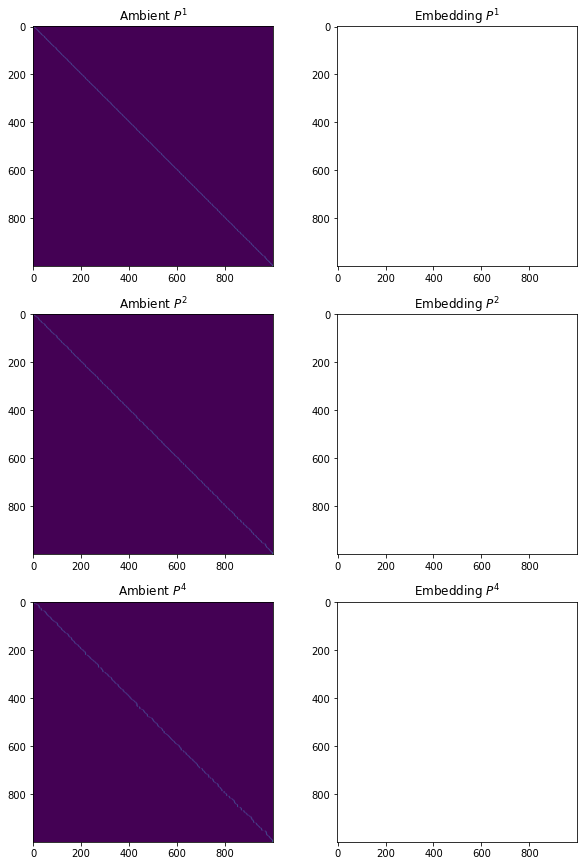

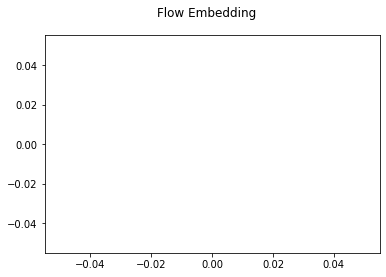

 76%|███████▌  | 7600/10000 [23:47<06:54,  5.79it/s]

EPOCH 7600. Loss nan. Flow strength nan. Heatmap of P embedding is 


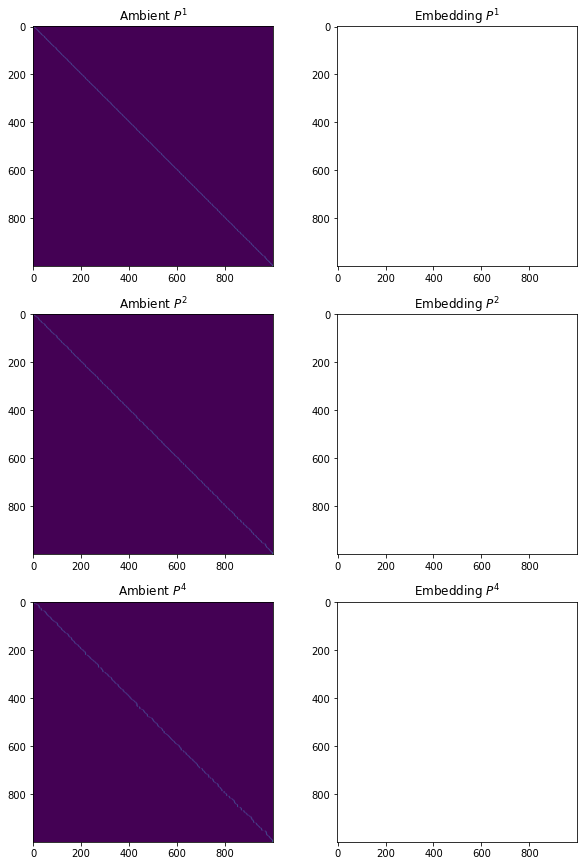

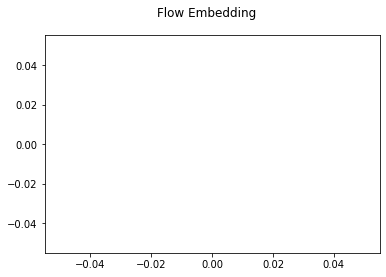

 77%|███████▋  | 7700/10000 [24:05<06:37,  5.78it/s]

EPOCH 7700. Loss nan. Flow strength nan. Heatmap of P embedding is 


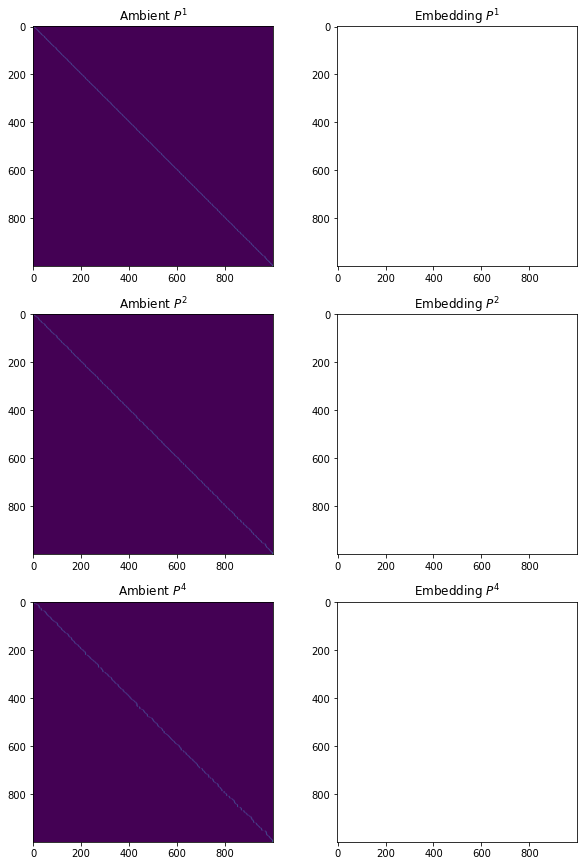

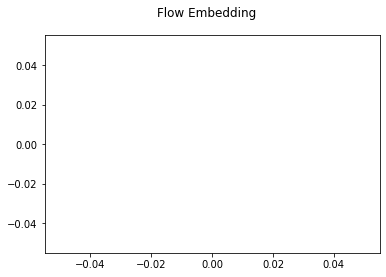

 78%|███████▊  | 7800/10000 [24:25<06:22,  5.74it/s]

EPOCH 7800. Loss nan. Flow strength nan. Heatmap of P embedding is 


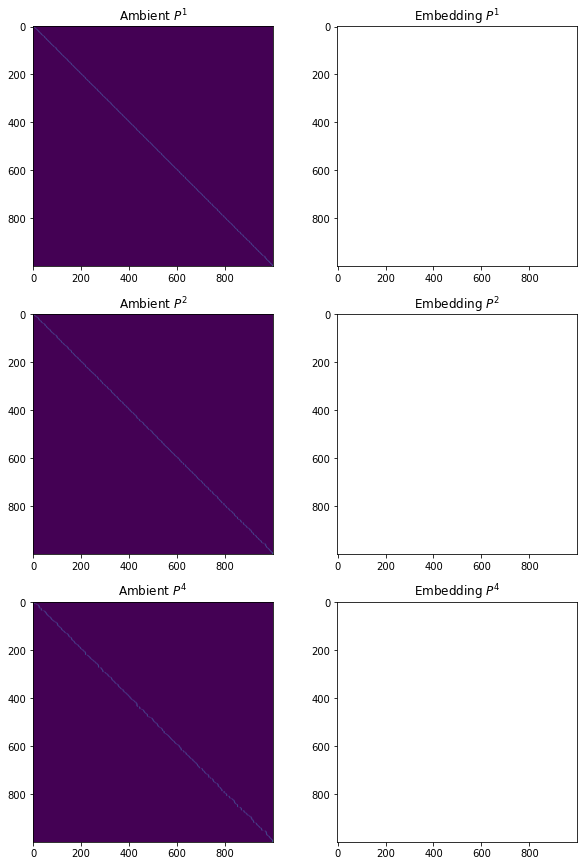

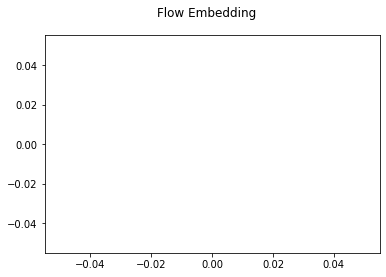

 79%|███████▉  | 7900/10000 [24:43<06:05,  5.75it/s]

EPOCH 7900. Loss nan. Flow strength nan. Heatmap of P embedding is 


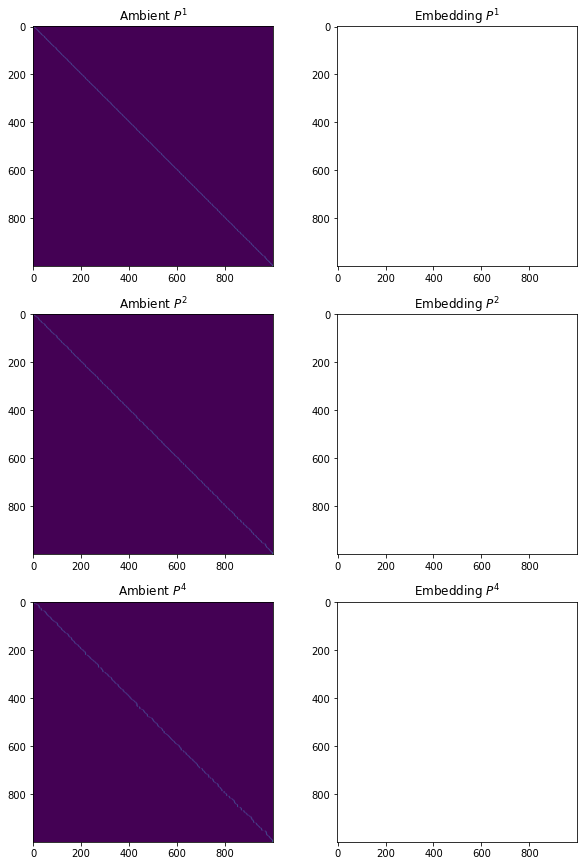

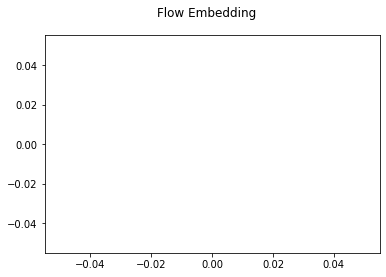

 80%|████████  | 8000/10000 [25:02<05:46,  5.77it/s]

EPOCH 8000. Loss nan. Flow strength nan. Heatmap of P embedding is 


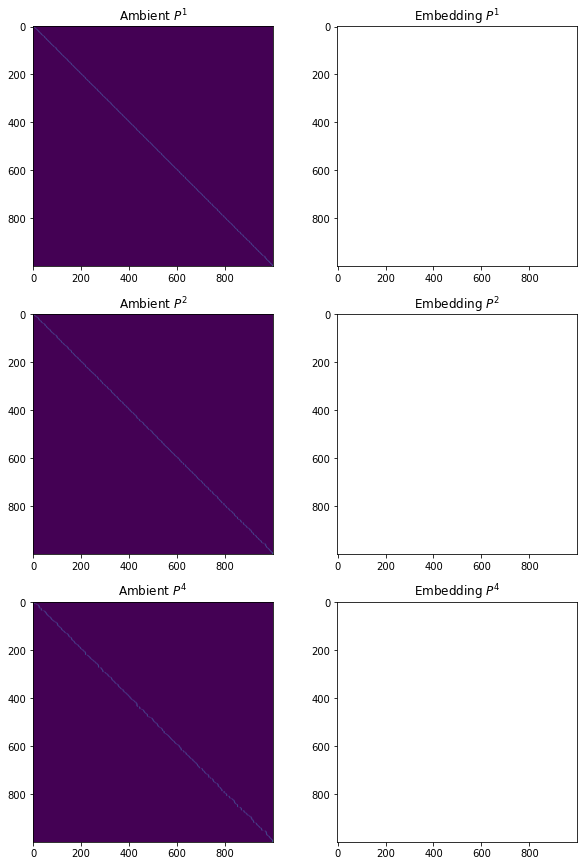

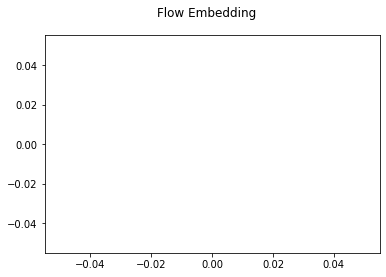

 81%|████████  | 8100/10000 [25:20<05:30,  5.75it/s]

EPOCH 8100. Loss nan. Flow strength nan. Heatmap of P embedding is 


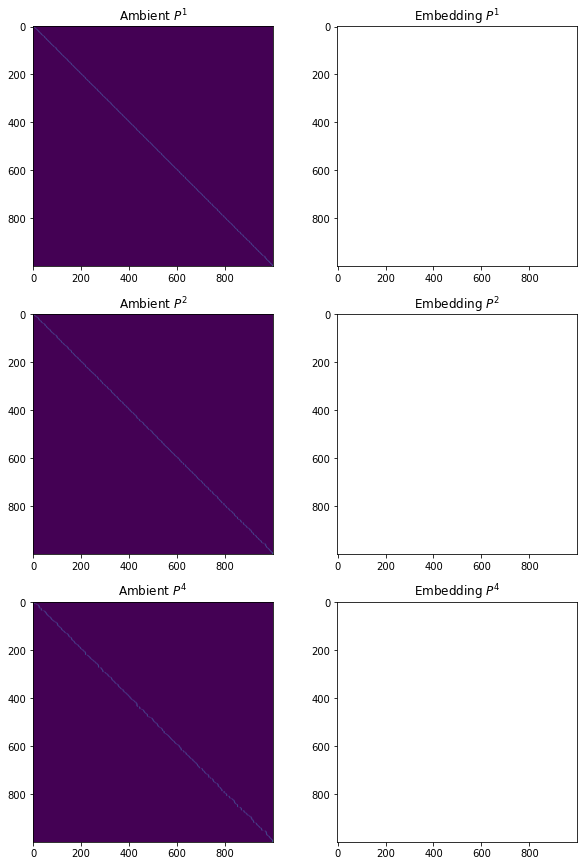

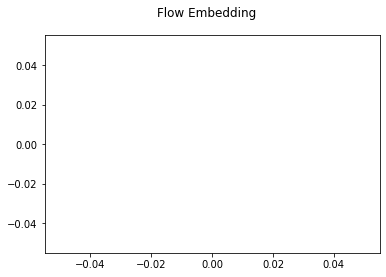

 82%|████████▏ | 8200/10000 [25:39<05:29,  5.46it/s]

EPOCH 8200. Loss nan. Flow strength nan. Heatmap of P embedding is 


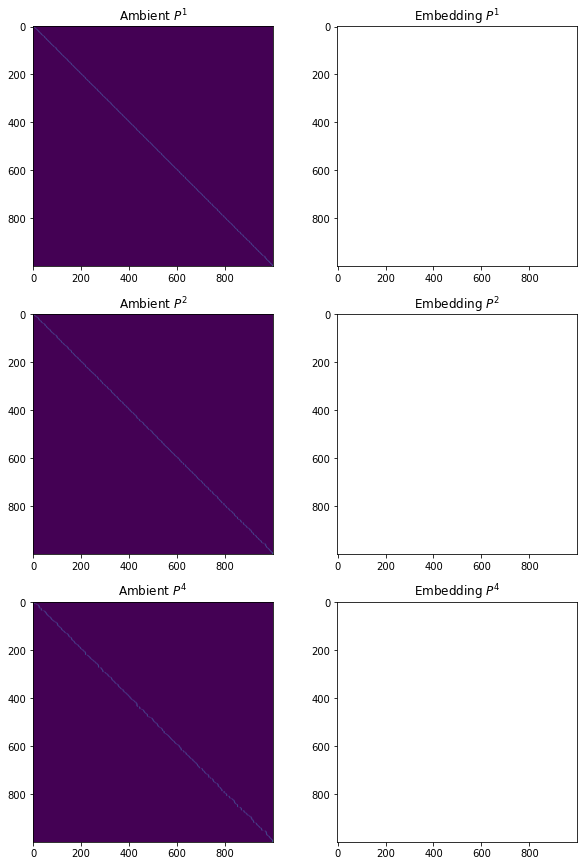

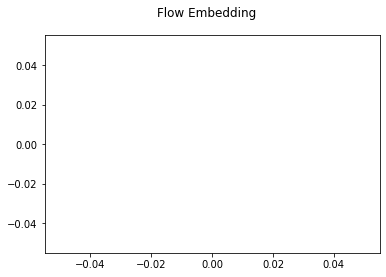

 83%|████████▎ | 8300/10000 [25:57<04:55,  5.75it/s]

EPOCH 8300. Loss nan. Flow strength nan. Heatmap of P embedding is 


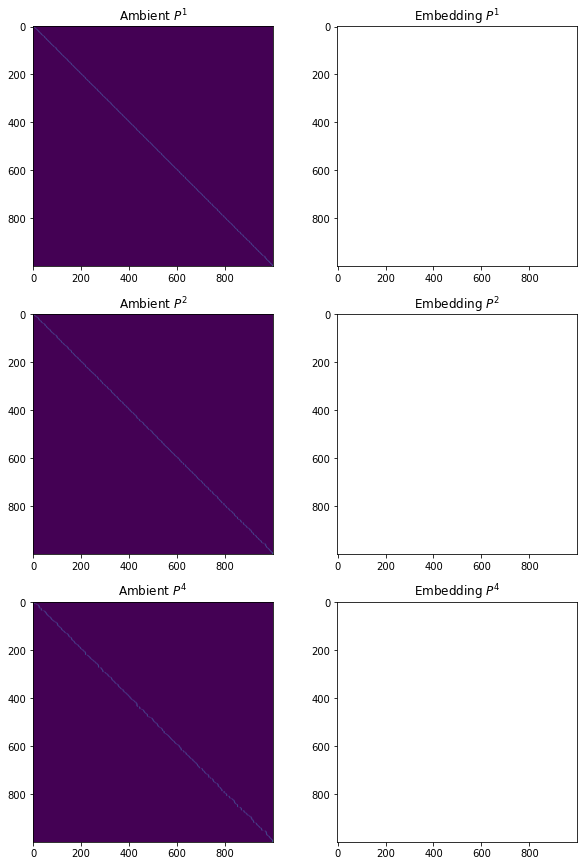

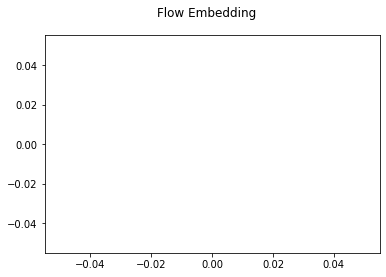

 84%|████████▍ | 8400/10000 [26:17<04:38,  5.74it/s]

EPOCH 8400. Loss nan. Flow strength nan. Heatmap of P embedding is 


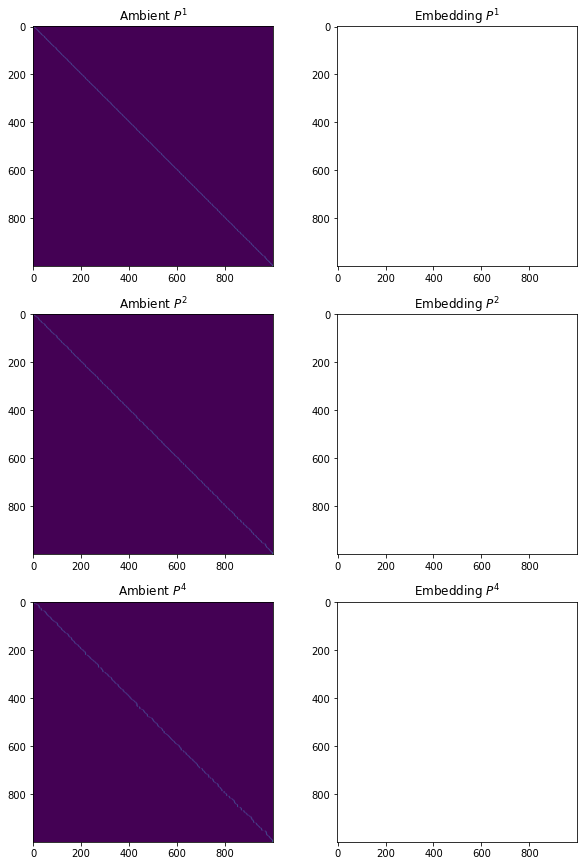

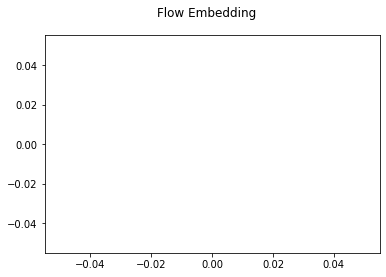

 85%|████████▌ | 8500/10000 [26:35<04:19,  5.78it/s]

EPOCH 8500. Loss nan. Flow strength nan. Heatmap of P embedding is 


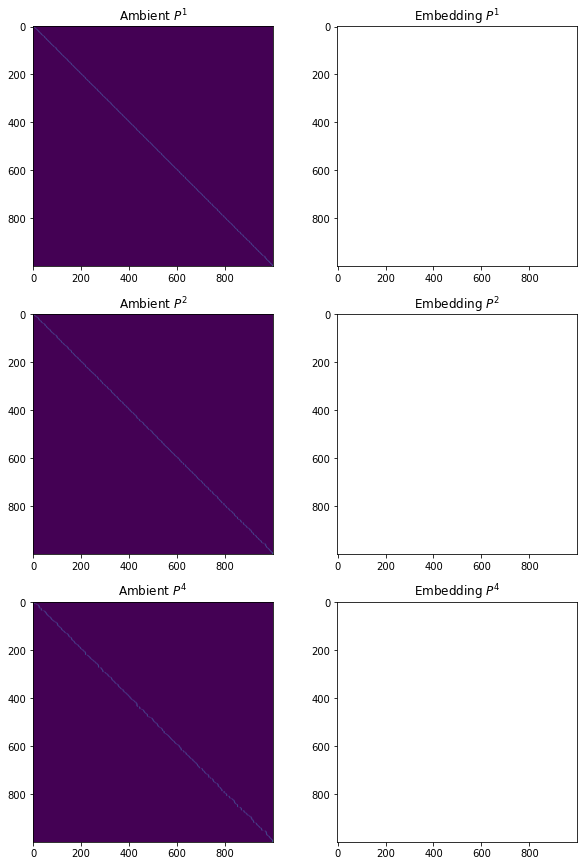

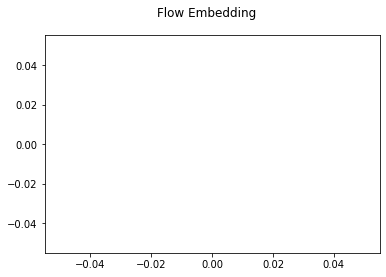

 86%|████████▌ | 8600/10000 [26:54<04:02,  5.77it/s]

EPOCH 8600. Loss nan. Flow strength nan. Heatmap of P embedding is 


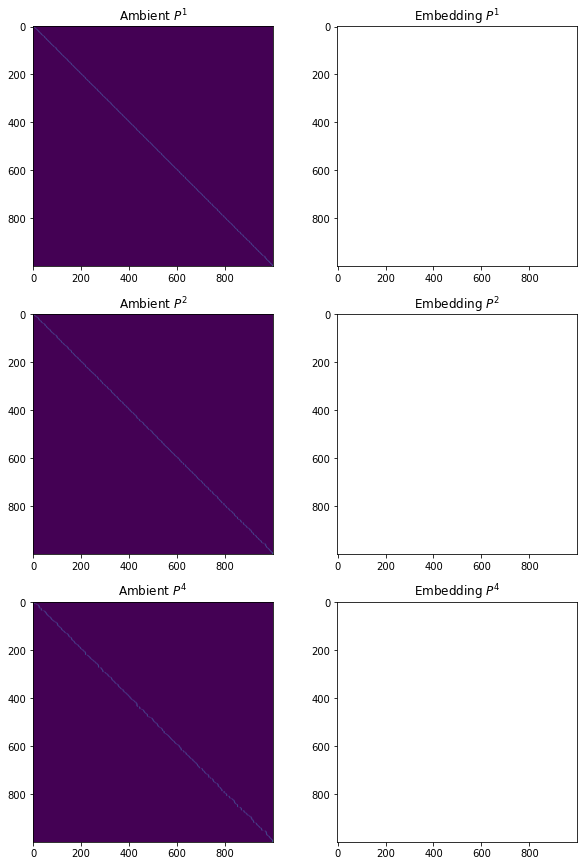

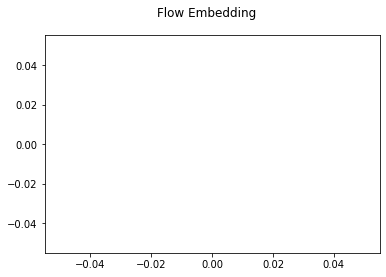

 87%|████████▋ | 8700/10000 [27:12<03:44,  5.79it/s]

EPOCH 8700. Loss nan. Flow strength nan. Heatmap of P embedding is 


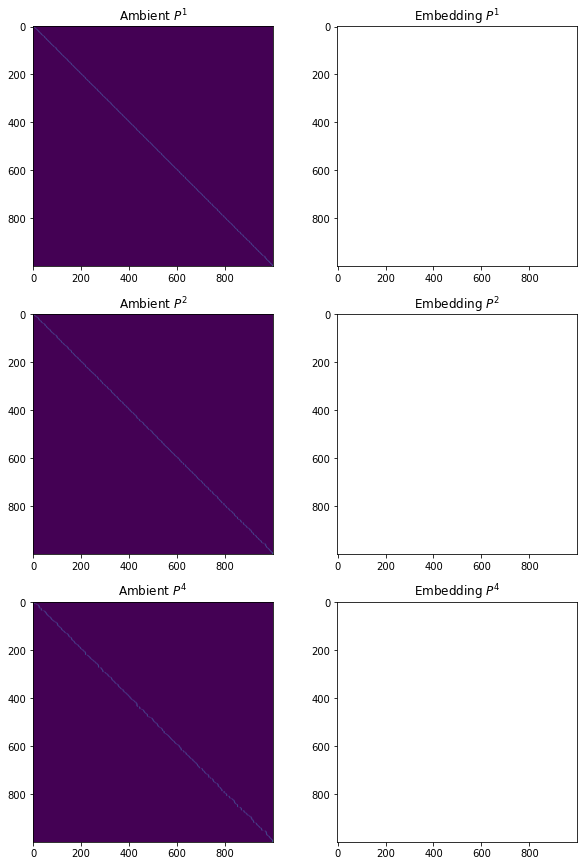

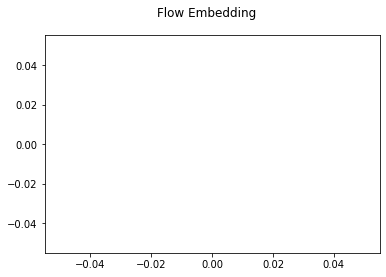

 88%|████████▊ | 8800/10000 [27:31<03:27,  5.78it/s]

EPOCH 8800. Loss nan. Flow strength nan. Heatmap of P embedding is 


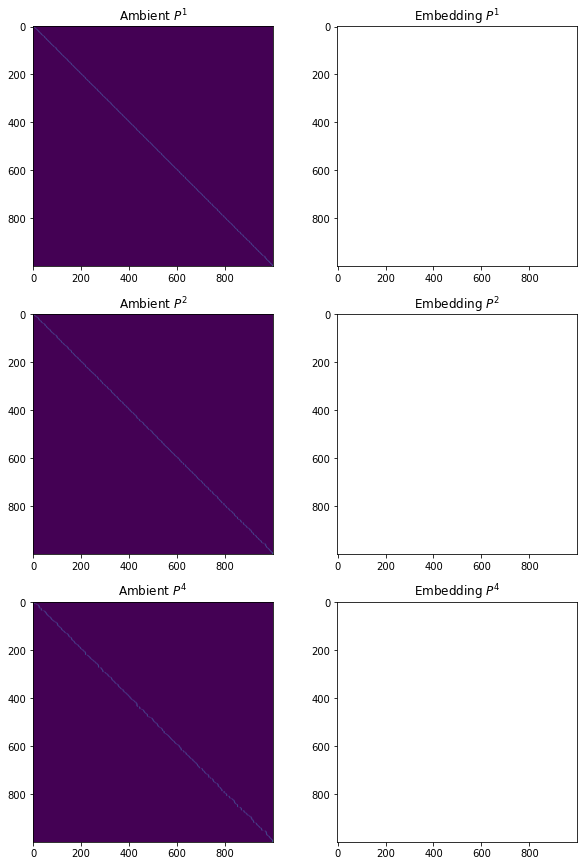

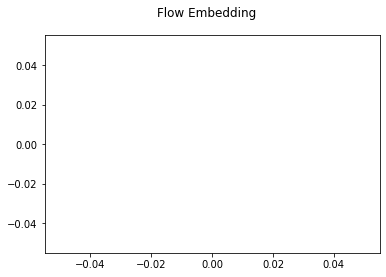

 89%|████████▉ | 8900/10000 [27:49<03:10,  5.78it/s]

EPOCH 8900. Loss nan. Flow strength nan. Heatmap of P embedding is 


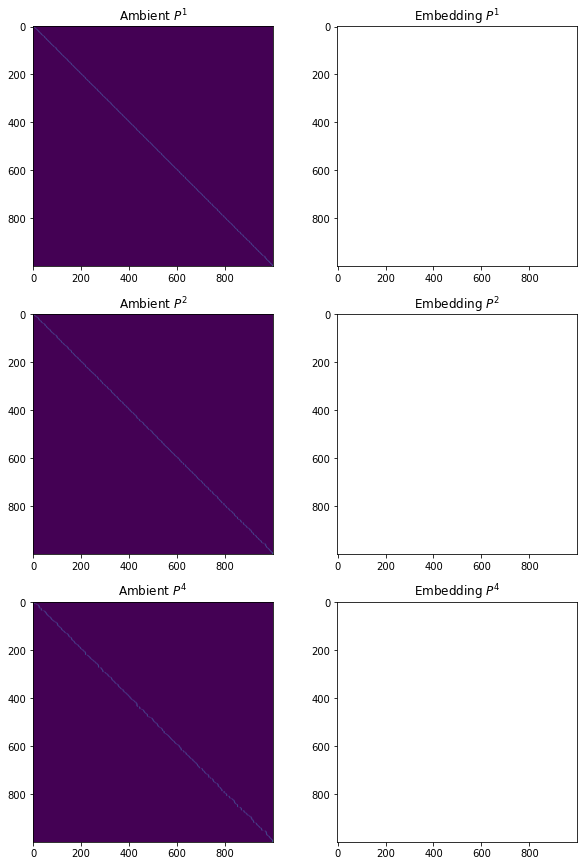

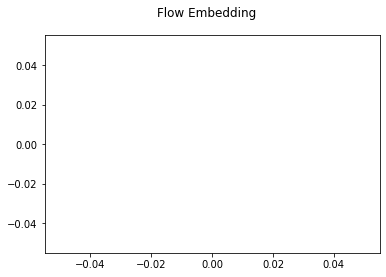

 90%|█████████ | 9000/10000 [28:08<02:53,  5.76it/s]

EPOCH 9000. Loss nan. Flow strength nan. Heatmap of P embedding is 


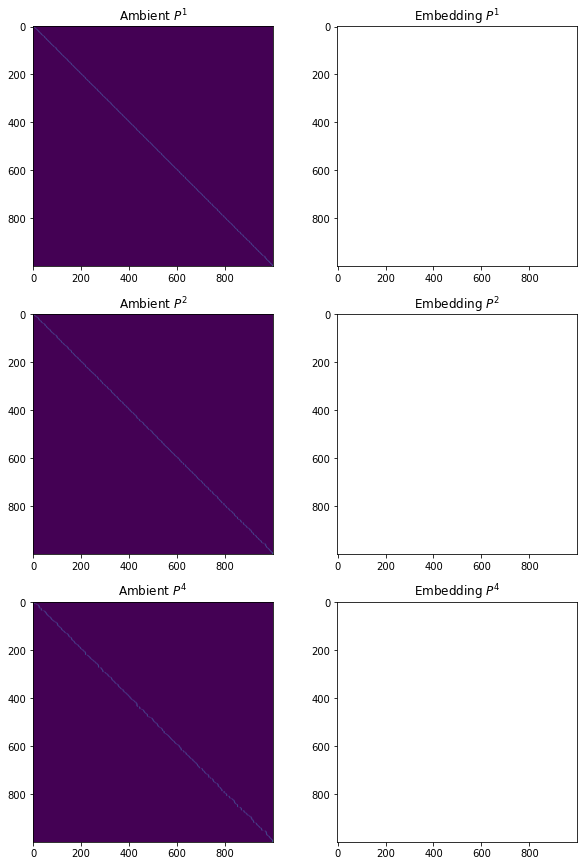

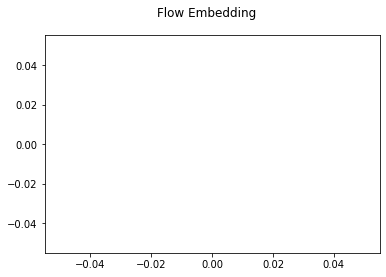

 91%|█████████ | 9100/10000 [28:27<02:36,  5.75it/s]

EPOCH 9100. Loss nan. Flow strength nan. Heatmap of P embedding is 


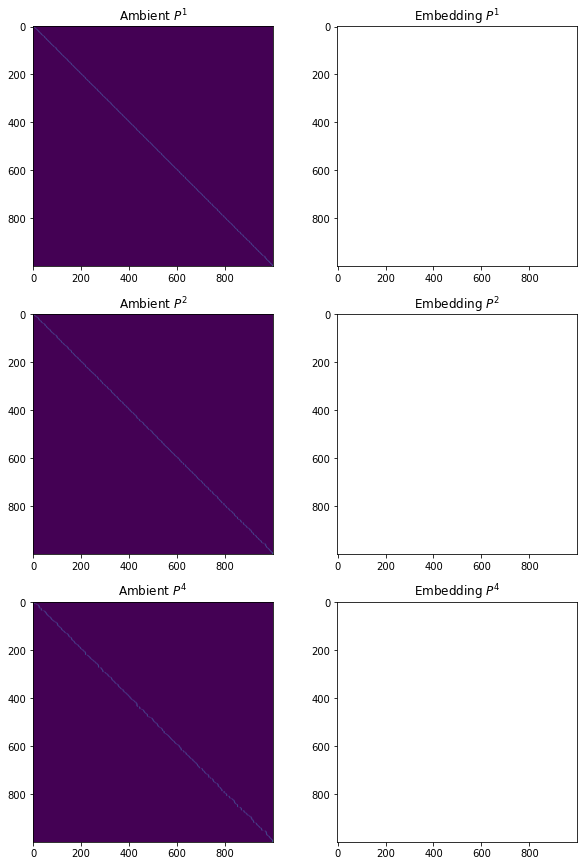

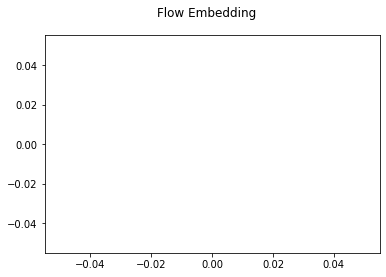

 92%|█████████▏| 9200/10000 [28:46<02:18,  5.76it/s]

EPOCH 9200. Loss nan. Flow strength nan. Heatmap of P embedding is 


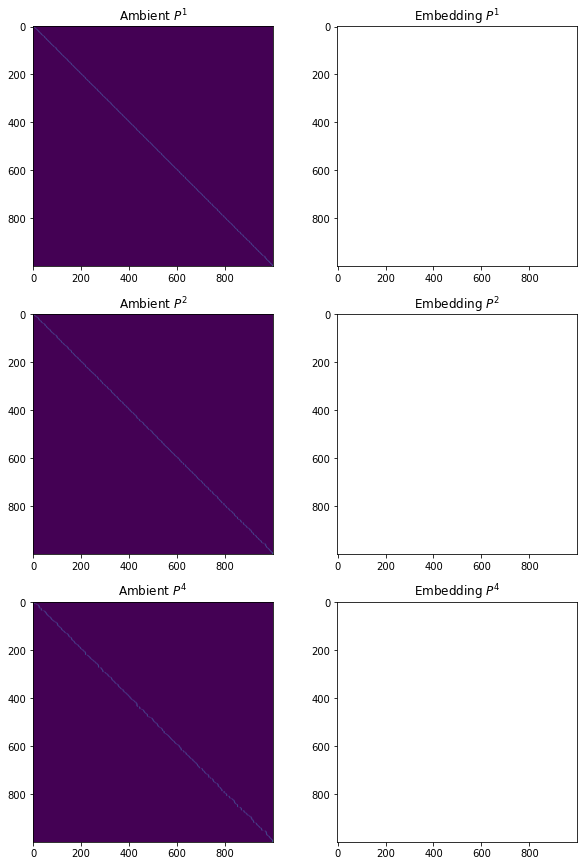

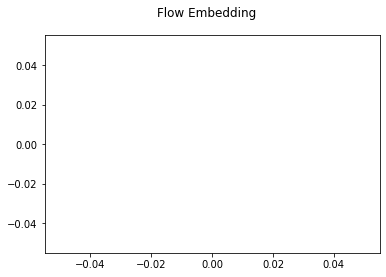

 93%|█████████▎| 9300/10000 [29:04<02:01,  5.78it/s]

EPOCH 9300. Loss nan. Flow strength nan. Heatmap of P embedding is 


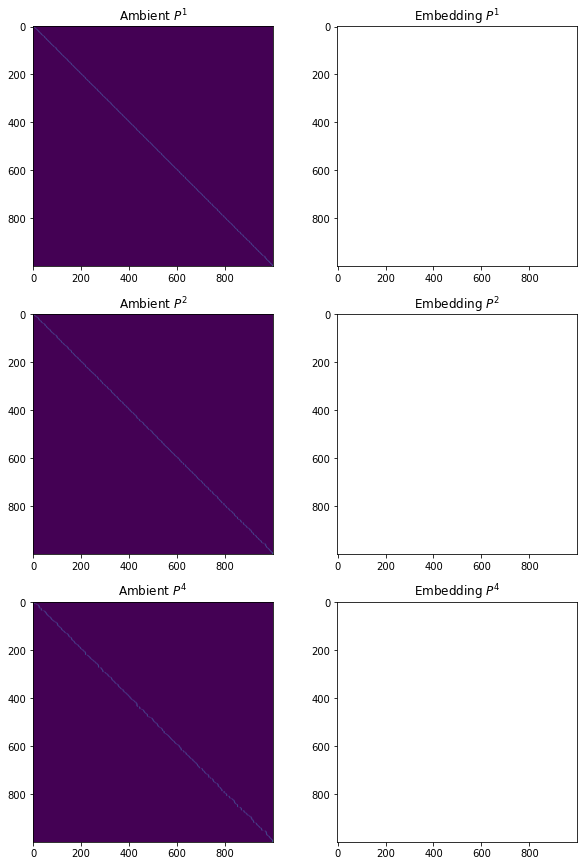

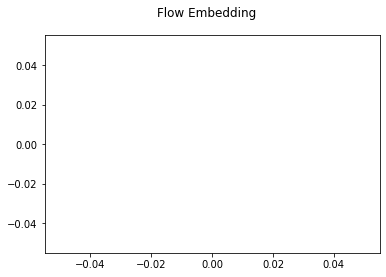

 94%|█████████▍| 9400/10000 [29:23<01:43,  5.77it/s]

EPOCH 9400. Loss nan. Flow strength nan. Heatmap of P embedding is 


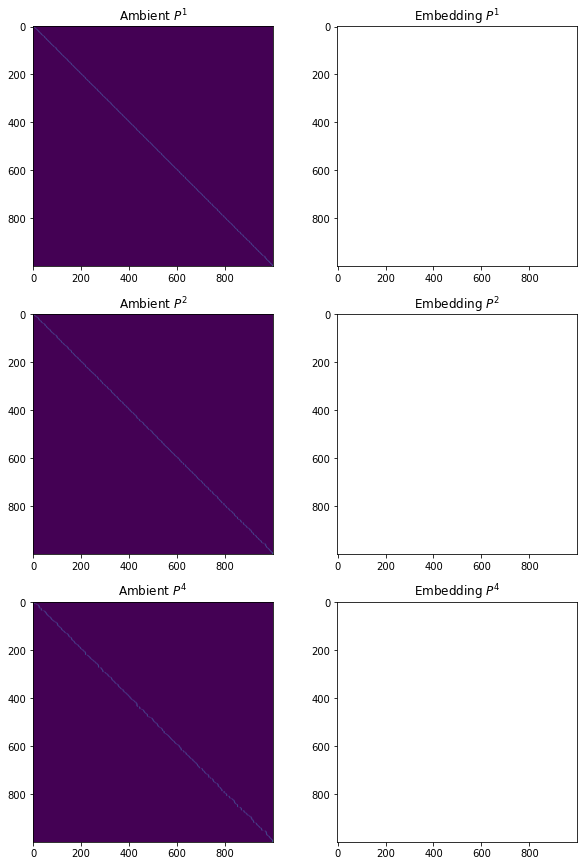

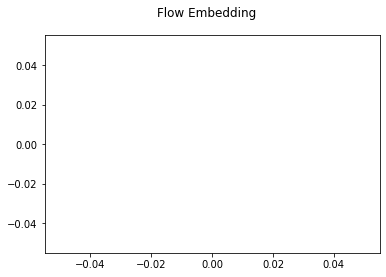

 95%|█████████▌| 9500/10000 [29:41<01:26,  5.79it/s]

EPOCH 9500. Loss nan. Flow strength nan. Heatmap of P embedding is 


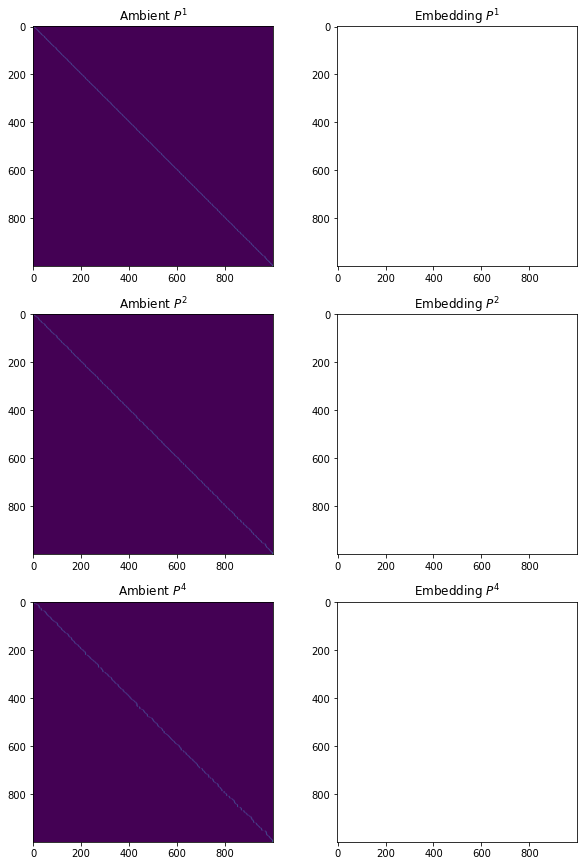

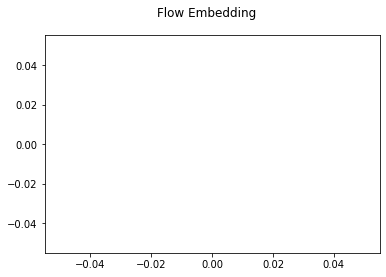

 96%|█████████▌| 9600/10000 [30:00<01:09,  5.76it/s]

EPOCH 9600. Loss nan. Flow strength nan. Heatmap of P embedding is 


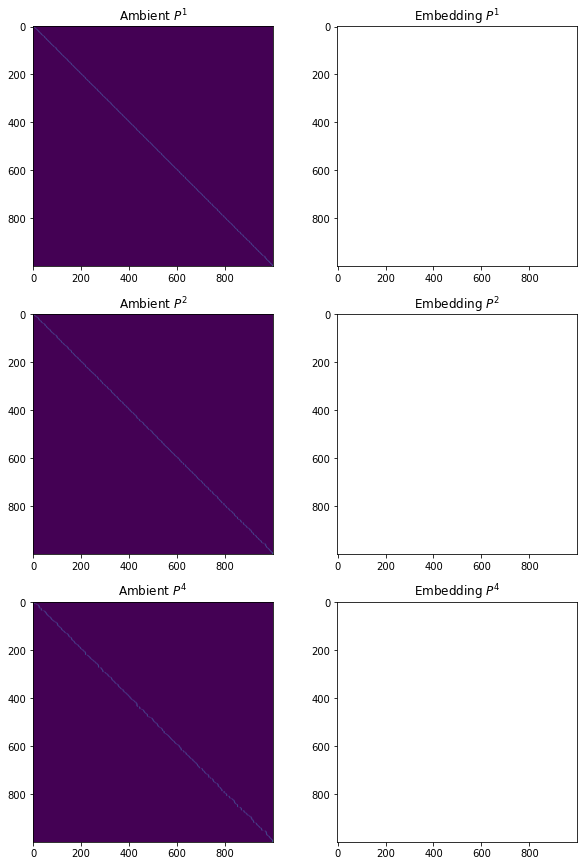

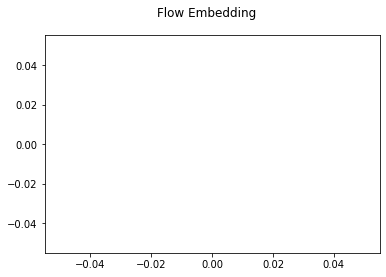

 97%|█████████▋| 9700/10000 [30:19<00:52,  5.76it/s]

EPOCH 9700. Loss nan. Flow strength nan. Heatmap of P embedding is 


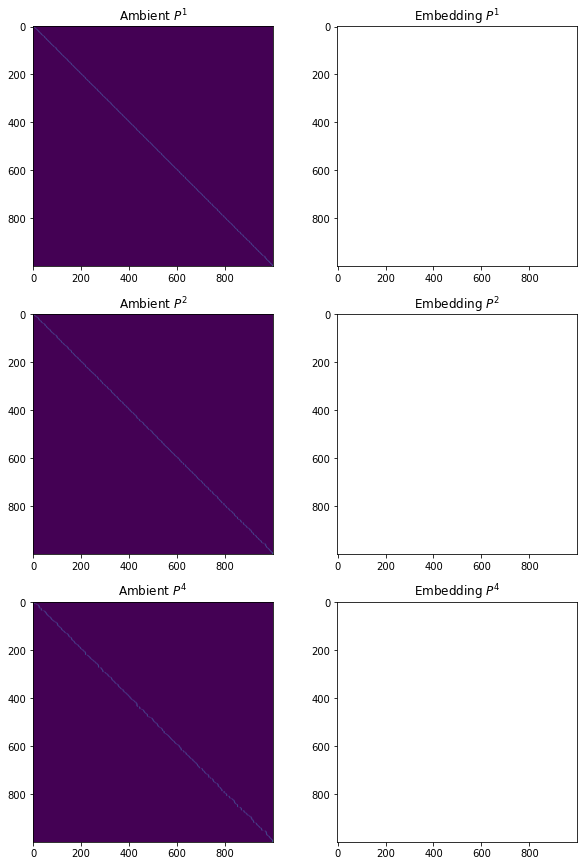

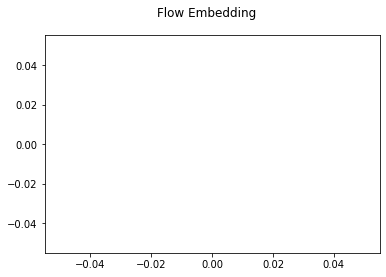

 98%|█████████▊| 9800/10000 [30:38<00:35,  5.71it/s]

EPOCH 9800. Loss nan. Flow strength nan. Heatmap of P embedding is 


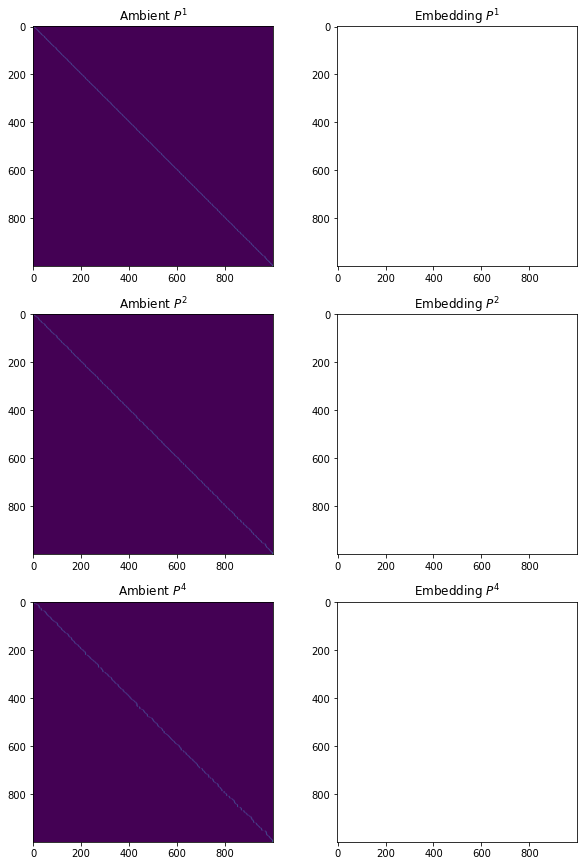

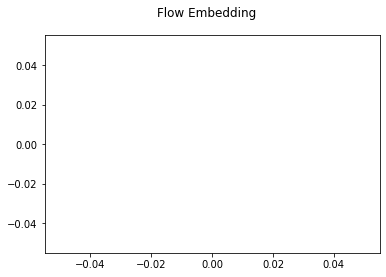

 99%|█████████▉| 9900/10000 [30:56<00:17,  5.81it/s]

EPOCH 9900. Loss nan. Flow strength nan. Heatmap of P embedding is 


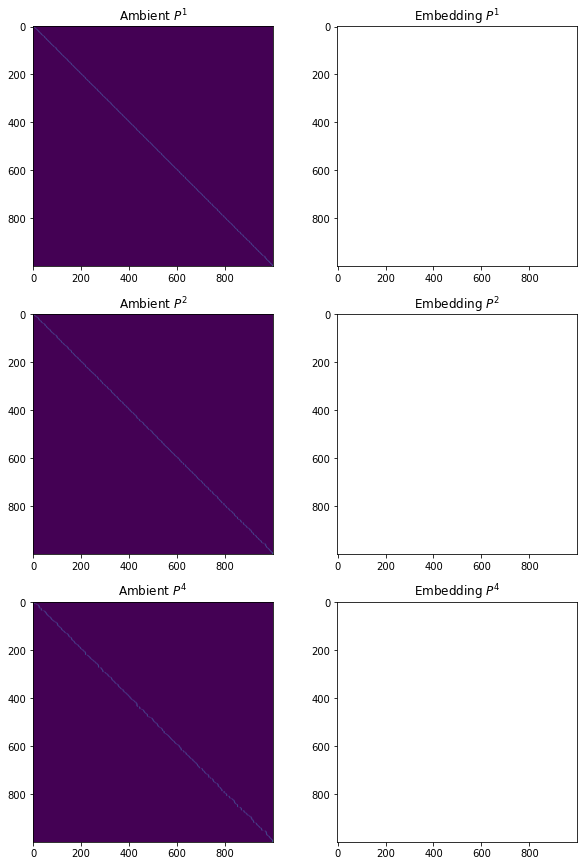

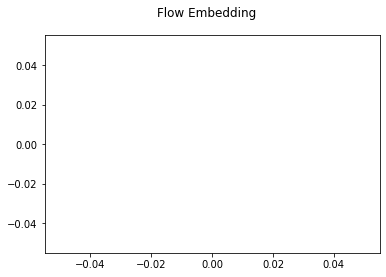

100%|██████████| 10000/10000 [31:15<00:00,  5.33it/s]


Exiting training with loss  tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)


tensor([[nan, nan],
        [nan, nan],
        [nan, nan],
        ...,
        [nan, nan],
        [nan, nan],
        [nan, nan]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
MFE.fit(n_steps=10000)